# Airbnb Listings Analysis

In [ ]:
# install pyspark 3.4.2 so we can use grapframes
!pip install pyspark==3.4.2

In [ ]:
# Necessary Imports
!pip install dython
from time import sleep
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('wordnet')
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler, StringIndexer, Tokenizer, StopWordsRemover, HashingTF, IDF, RegexTokenizer, CountVectorizer, MinHashLSH, PCA
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor, GBTRegressor, RandomForestRegressor
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from xgboost.spark import SparkXGBRegressor
from google.colab import drive

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
# Mount Google Drive
drive.mount("/content/gdrive", force_remount=True)

# Create a Spark session
spark = SparkSession.builder \
    .appName("Read Airbnb Data") \
    .getOrCreate()

# Path to the Parquet file
parquet_file_path = "/content/gdrive/MyDrive/DSC511/Airbnb.parquet"

# Read the Parquet file
df = spark.read.parquet(parquet_file_path)

# Show the first few rows of the DataFrame
df.show()

Mounted at /content/gdrive
+--------------------+------------+--------------------+---------------+----------------+---------------+---------------+---------+-------------+--------+----+------------------------------+---------------------+----------------+-------------------+------------+------------+--------------+------------+-----------------------------------+-------------------+------------+--------------------+------------+--------------------+---------------+----------------+------------------------------------+--------------------+--------+-------------------+--------------------+---------------+------------------+--------------------+------------------+------------------+----------+--------------------+-------------------------+--------------------+--------------------+--------------------+--------+--------------------+------------------+-----------+------------+------------------+-------+--------------------+--------------------+----------+--------------+--------------------+

In [ ]:
# First we filter the dataframe as to get only the countries of the United States
df = df.filter(df.country == "United States")
df.show()

+--------------------+------------+--------------------+---------------+----------------+---------------+---------------+---------+--------+--------+----+------------------------------+---------------------+----------------+-------------------+----------------+------------+-------------+------------+--------------------+-------------------+------------+--------------------+------------+--------------------+---------------+----------------+--------------------+--------------------+---------+-------------------+--------------------+-----------------+--------------------+--------------------+------------------+------------------+----------+--------------------+-------------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+-----------+------------+------------------+--------------------+--------------------+-------------------+----------------+--------------+--------------------+--------------+-------------+------

In [ ]:
df.count()

134545

# Data Engineering

## Data Period

In [ ]:
max_date = df.select(max("last_scraped").alias("Max Date"))
min_date = df.select(min("last_scraped").alias("Min Date"))

# Show the results
max_date.show()
min_date.show()

+----------+
|  Max Date|
+----------+
|2017-06-02|
+----------+

+----------+
|  Min Date|
+----------+
|2015-10-16|
+----------+



We will examine airbnb listings that were last scrapped from 16/10/2015 up until 02/06/2017.  

The column last_scrapped will not provide to us any significant information and we will remove this. We also notice that calendar_last_scrapped column provide the same information with the last_scrapped, with minor differences. For instance, last_scrapped have plus one day from calendar_last_scrapped but the main period remains the same, from 2015 to 2017. So, we will drop this column as well.

## Checking for duplicates

In [ ]:
# Count the occurrences of each id value
id_counts = df.groupBy("id").count()

# Filter for ids with more than one occurrence (indicating duplicates)
duplicate_ids = id_counts.filter(id_counts["count"] > 1)

# Show the duplicate ids
duplicate_ids.show()

+---+-----+
| id|count|
+---+-----+
+---+-----+



## Handling Missing Values

In [ ]:
# We create a function to count the NAs in every columun
def na_count_expr(column, dtype):
    if dtype in ['double', 'float']:  # Check if the data type is float or double
        return count(when(isnan(column) | col(column).isNull(), column)).alias(column + "_na_count")
    else:
        return count(when(col(column).isNull(), column)).alias(column + "_na_count")

na_counts_exprs = [na_count_expr(c, t) for c, t in df.dtypes]

In [ ]:
# Apply these expressions to the DataFrame
na_counts_df = df.select(na_counts_exprs)

# Show the results, displaying the count of NA values for each column
na_counts_df.show()

+---------------+---------------------+------------------+------------------------+-------------------------+------------------------+------------------------+------------------+-----------------+-----------------+-------------+---------------------------------------+------------------------------+-------------------------+----------------------------+-------------+---------------------+----------------+---------------------+--------------------+----------------------------+---------------------+-----------------+---------------------+--------------------+------------------------+-------------------------+-------------------+-----------------------------+----------------+----------------------------+----------------------+------------------+---------------------------+-------------------------+---------------------------+---------------------------+-------------------+---------------------------+----------------------------------+-----------------+---------------------------+----------

**Observations:**  
After the analysis of NA values for every column, we decided to remove the follwing columns as the majority of their values are NAs:
1. has_availability (129.913 missing values out of 134.545 observations)  
2. Host_acceptance_rate (115.795 missing values)
3. Licence (124.401 missing values)
4. Square_feet missing (132.454 missing values)

Also, we notice that only 1964 rows of our target variable (price) have missing values, which is less than the 10% of our observations and we decided to remove those rows.  

Moreover, we can observe that some of our features give us the same information, so we will fill some of the missing values with their equievalent one.

Further more, we decide to remove:
*   image and link columns because they contain links and they are not providing any information.
*   country and country code as we have choosen US only
*   geolocation but we will keep longtitude and latitude that provide the same informaton in two columns instead of one.

Since these columns: neighbourhood,neighbourhood_cleansed, neighbourhood_group_cleansed tell us the neighbourhood where the listing is located with neighbourhood and neighbourhood_group_cleansed having NAs values, and neighbourhood_cleansed have none missing values, so we will remove neighbourhood and neighbourhood_group_cleansed columns, and we will keep only the other one.  


In [ ]:
# Drop rows with null values in the price column
df = df.dropna(subset=["price"])

In [ ]:
# Dropping the url of the images since they cant be accessed and the url's dont work anymore and the rest of the above mentioned columns
# Country is also dropped since we have already choosen US and it is not necessary as an information anymore
df = df.drop(*['xl_picture_url', 'thumbnail_url', 'medium_url', 'picture_url', 'host_picture_url', 'host_thumbnail_url', 'country', 'country_code','calculated_host_listings_count','host_url', 'listing_url', 'geolocation','has_availability', 'host_acceptance_rate', 'license','square_feet',"calendar_last_scraped","calendar_updated","experiences_offered","jurisdiction_names", "last_scraped","neighbourhood", "neighbourhood_group_cleansed", "first_review", "last_review", "host_name", "scrape_id", "host_location", "host_neighbourhood"])
df.show()
df.count()

+--------------------+------------+--------------------+---------------+----------------+---------------+---------------+---------+--------+--------+----+-------------------+----------------+------------+--------------------+------------+--------------------+---------------+--------------------+---------+-------------------+------------------+------------------+----------+-------------------------+--------------------+--------------------+--------+--------------------+------------------+-------------------+----------------+--------------+--------------+-------------+--------------------+---------------------+----------------------+--------------------+-----------------+-----+-------------+----------------------+---------------------+-------------------------+---------------------------+----------------------+--------------------+-------------------+-----------------+---------------+----------------+--------------------+--------------------+-----+--------------------+-------------------

132581

In [ ]:
# Rename neighbourhood_cleansed column to neighbourhood
df = df.withColumnRenamed("neighbourhood_cleansed", "neighbourhood")

Handling NAs in **monthly_price** and **weekly_price** columns

After research we found that weekly discounts apply to reservations of 7 or more nights and monthly discounts apply to reservations of 28 or more nights.

So, we will fill missing values in:

 1.  monthly_price by multiplying the price * 28  

 2.  weekly_price by multiplying the price * 7

In [ ]:
# Fill null values in monthly_price column
df = df.withColumn("monthly_price",
                   when(col("monthly_price").isNull(), col("price") * 28).otherwise(col("monthly_price")))

# Fill null values in weekly_price column
df = df.withColumn("weekly_price",
                   when(col("weekly_price").isNull(), col("price") * 7).otherwise(col("weekly_price")))

# Show the updated DataFrame
df.select("monthly_price", "weekly_price").show()

+-------------+------------+
|monthly_price|weekly_price|
+-------------+------------+
|         3332|         833|
|         1820|         455|
|         3220|         805|
|         3080|         770|
|         5292|        1323|
|         2100|         525|
|         4200|        1050|
|         3000|         770|
|         1540|         385|
|         1300|         350|
|         1200|         350|
|          900|         250|
|         4480|        1120|
|         1960|         490|
|         1000|         300|
|         2520|         630|
|         4200|        1050|
|         6972|        1743|
|         2884|         721|
|         2100|         525|
+-------------+------------+
only showing top 20 rows



In [ ]:
# Check for null values in monthly_price column
null_monthly_price = df.filter(df["monthly_price"].isNull())

# Check for null values in weekly_price column
null_weekly_price = df.filter(df["weekly_price"].isNull())

# Count the number of null values in each column
count_null_monthly_price = null_monthly_price.count()
count_null_weekly_price = null_weekly_price.count()

# Print the counts to ensure we have no null
print("Number of null values in monthly_price column:", count_null_monthly_price)
print("Number of null values in weekly_price column:", count_null_weekly_price)

Number of null values in monthly_price column: 0
Number of null values in weekly_price column: 0


Getting meaninmgful information from host_since variable.

In [ ]:
# Convert host_since column to datetime data type
df = df.withColumn("host_since", df["host_since"].cast("date"))

# Derive host_years_since_joined
df = df.withColumn("host_years_since_joined", 2017 - year("host_since"))

# Show the updated DataFrame with only host_years_since_joined column
df.select("host_years_since_joined").show()

+-----------------------+
|host_years_since_joined|
+-----------------------+
|                      2|
|                      6|
|                      1|
|                      3|
|                      5|
|                      4|
|                      3|
|                      4|
|                      1|
|                      2|
|                      5|
|                      5|
|                      4|
|                      3|
|                      3|
|                      6|
|                      0|
|                      3|
|                      1|
|                      1|
+-----------------------+
only showing top 20 rows



In [ ]:
# Check if host_years_since_joined and host_since have NULL values in the same rows
same_null_rows = df.filter((col("host_years_since_joined").isNull()) & (col("host_since").isNull())).count()

if same_null_rows > 0:
    print("host_years_since_joined and host_since have NULL values in the same rows.")
else:
    print("host_years_since_joined and host_since do not have NULL values in the same rows.")


host_years_since_joined and host_since have NULL values in the same rows.


In [ ]:
# Count the rows where host_years_since_joined and host_since have NULL values in the same rows
same_null_rows_count = df.filter((col("host_years_since_joined").isNull()) & (col("host_since").isNull())).count()
print("Count of rows where host_years_since_joined and host_since have NULL values in the same rows:", same_null_rows_count)

Count of rows where host_years_since_joined and host_since have NULL values in the same rows: 285


In [ ]:
# Count of NULL values in host_since
count_null_host_since = df.filter(df["host_since"].isNull()).count()
print("Count of NULL values in host_since:", count_null_host_since)

Count of NULL values in host_since: 285


In [ ]:
# Drop the host_since column
df = df.drop("host_since")

In [ ]:
df.filter(col("host_years_since_joined").isNull()).count()

285

So, we keep only the host_years_since_joined columnn (which is the number of years that each host joined the Airbnb platform) that we have created, but we still need to handle the 285 NAs that we have. To approach this, we checked for duplicates on host_id which is something we expect as one host can have more than one listings. Our goal is to see if we can get the information of
host_years_since_joined from another listing that have the same host.

In [ ]:
# Check for duplicates in the host_id column
duplicate_count = df.groupBy("host_id").count().filter("count > 1").count()

if duplicate_count > 0:
    print("Duplicates found in the host_id column.")
else:
    print("No duplicates found in the host_id column.")


Duplicates found in the host_id column.


In [ ]:
from pyspark.sql.functions import col, count

# Group by host_id and count non-null and null values in host_years_since_joined
na_count_df = df.groupBy("host_id").agg(
    count(col("host_years_since_joined")).alias("non_null_count"),
    count("*").alias("total_count")
)

# Calculate the count of null values
na_count_df = na_count_df.withColumn(
    "null_count",
    col("total_count") - col("non_null_count")
)

# Show the result
na_count_df.show()

+---------+--------------+-----------+----------+
|  host_id|non_null_count|total_count|null_count|
+---------+--------------+-----------+----------+
| 23542770|             1|          1|         0|
| 26433326|             1|          1|         0|
|  5028116|             4|          4|         0|
| 32913755|             2|          2|         0|
| 54112668|             1|          1|         0|
| 45023447|             1|          1|         0|
| 67260887|             2|          2|         0|
|102163409|             1|          1|         0|
| 14339865|             5|          5|         0|
|   924059|             2|          2|         0|
| 48287191|             1|          1|         0|
|  1317588|             1|          1|         0|
| 15198359|             2|          2|         0|
|   646472|             1|          1|         0|
|   793021|             1|          1|         0|
| 10472095|             1|          1|         0|
|  5959653|             2|          2|         0|


Printing only the host_ids that have null values.

In [ ]:
from pyspark.sql.functions import col, count

# Group by host_id and count non-null and null values in host_years_since_joined
na_count_df = df.groupBy("host_id").agg(
    count(col("host_years_since_joined")).alias("non_null_count"),
    count("*").alias("total_count")
)

# Calculate the count of null values
na_count_df = na_count_df.withColumn(
    "null_count",
    col("total_count") - col("non_null_count")
)


# Print host_id with null values
print("Host IDs with null values:")
na_count_df.filter(col("null_count") > 0).count()



Host IDs with null values:


222

In [ ]:
na_count_df.filter(col("null_count") > 0).show()

+---------+--------------+-----------+----------+
|  host_id|non_null_count|total_count|null_count|
+---------+--------------+-----------+----------+
|110855248|             0|          3|         3|
| 80778982|             0|          1|         1|
|  3046221|             0|          1|         1|
|124486054|             0|          1|         1|
| 39126862|             0|          2|         2|
|  3044041|             0|          6|         6|
|  6639602|             0|          1|         1|
| 12128527|             0|          1|         1|
| 16727332|             0|          1|         1|
| 27868790|             0|          1|         1|
|  1525346|             0|          2|         2|
| 18933388|             0|          1|         1|
| 14726038|             0|          1|         1|
| 22547910|             0|          6|         6|
|  4138469|             0|          1|         1|
| 35387196|             0|          1|         1|
| 49448564|             0|          1|         1|


In [ ]:
# Check if total_count and null_count are identical
na_count_df.filter(col("total_count") == col("null_count")).count()

222

So we have proved that total_count of host_year_since_joined that have null values are equal to null_count of host_year_since_joined which means that we can't get the information that we said before for those host the year that they have joined.

In [ ]:
# Find distinct values of the column "host_years_since_joined"
distinct_values = df.select("host_years_since_joined").distinct().show()

+-----------------------+
|host_years_since_joined|
+-----------------------+
|                   null|
|                      1|
|                      6|
|                      3|
|                      5|
|                      9|
|                      4|
|                      8|
|                      7|
|                      2|
|                      0|
+-----------------------+



In [ ]:
# Drop rows with null values in host_years_since_joined as they are only 285
df = df.dropna(subset=["host_years_since_joined"])

In [ ]:
# Check if "host_response_rate" and "host_response_time" have null values at the same rows
matching_null_rows = df.filter((col("host_response_rate").isNull()) & (col("host_response_time").isNull()))

# Show the rows where both columns have null values
matching_null_rows.show()

+--------------------+------------+--------------------+---------------+----------------+---------------+---------------+---------+-------------+--------+----+-------------------+-------------+------------+--------------------+------------+--------------------+---------------+--------------------+---------+-------------------+------------------+------------------+-------------------------+--------------------+--------------------+--------+--------------------+------------------+-------------------+-------------+--------------+--------------+-------------+--------------------+---------------------+--------------------+--------------------+-----------------+-----+-------------+----------------------+---------------------+-------------------------+---------------------------+----------------------+--------------------+-------------------+-----------------+---------------+----------------+-----------------+--------------------+-----+--------------------+--------------------+---------------

We can observe that the response time and the response rate are both null in identical listings this indicates a clear absence of an observation. So we conclude that the null cases should be transformed to "0" instances meaning no interaction information.


### Handling missing values for numerical variables

In handling missing values within the dataset, a systematic approach has been devised to ensure consistency and reliability in the analysis. For numerical columns such as "bathrooms", "bedrooms", "beds", "host_listings_count","accommodates", and "host_total_listings_count", the mode – the most frequently occurring value – is employed for imputation. This choice is particularly suitable for categorical or discrete numerical variables where imputing with the mode ensures that the central tendency of the data is preserved.

On the other hand, for columns related to review scores – "review_scores_accuracy", "review_scores_checkin", "review_scores_cleanliness", "review_scores_communication", "review_scores_location", "review_scores_rating", "review_scores_value", and "reviews_per_month" – missing values are replaced with the mean of the respective columns. Utilizing the mean is advantageous as it accounts for the overall distribution of the data, providing a balanced representation of the central tendency.

For monetary and rate-related columns such as "cleaning_fee", "security_deposit", and "host_response_rate", missing values are imputed with 0. This approach is deemed appropriate as it signifies a lack of additional charges or interactions when information regarding these attributes is unavailable. By setting missing values to 0, it ensures a clear distinction between instances where a fee or rate is absent versus those where it may be present but unrecorded.

Replacing NAs for Numerical variables with the mean of each feature.

In [ ]:
# List of columns with missing values
columns_with_missing = ["review_scores_accuracy", "review_scores_checkin", "review_scores_cleanliness",
                        "review_scores_communication", "review_scores_location", "review_scores_rating",
                        "review_scores_value", "reviews_per_month"]

# Replace missing values with mean for each column
for col_name in columns_with_missing:
    # Calculate mean for the column
    column_mean = df.select(mean(col(col_name))).collect()[0][0]
    # Replace missing values with mean
    df = df.withColumn(col_name, when(col(col_name).isNull(), column_mean).otherwise(col(col_name)))

# Show the DataFrame with replaced missing values
df.show()

+--------------------+------------+--------------------+---------------+----------------+---------------+---------------+---------+--------+--------+----+-------------------+----------------+------------+--------------------+------------+--------------------+---------------+--------------------+---------+-------------------+------------------+------------------+-------------------------+--------------------+--------------------+--------+--------------------+------------------+-------------------+----------------+--------------+--------------+-------------+--------------------+---------------------+----------------+--------------------+-----------------+-----+-------------+----------------------+---------------------+-------------------------+---------------------------+----------------------+--------------------+-------------------+------------------+---------------+----------------+--------------------+--------------------+-----+--------------------+--------------------+--------------

In [ ]:
# List of columns with missing values
columns_with_missing = ["review_scores_accuracy", "review_scores_checkin", "review_scores_cleanliness",
                        "review_scores_communication", "review_scores_location", "review_scores_rating",
                        "review_scores_value", "reviews_per_month"]

# Check for null values in each column
for col_name in columns_with_missing:
    null_count = df.filter(col(col_name).isNull()).count()
    print(f"Null count in column {col_name}: {null_count}")

Null count in column review_scores_accuracy: 0
Null count in column review_scores_checkin: 0
Null count in column review_scores_cleanliness: 0
Null count in column review_scores_communication: 0
Null count in column review_scores_location: 0
Null count in column review_scores_rating: 0
Null count in column review_scores_value: 0
Null count in column reviews_per_month: 0


Replacing NAs for Numerical variables with the mode of each feature.

In [ ]:
# List of columns with missing values
columns_with_missing = ["bathrooms", "bedrooms", "beds", "host_listings_count", "host_total_listings_count","accommodates"]

# Replace missing values with mode for each column
for col_name in columns_with_missing:
    # Calculate mode for the column
    mode_value = df.groupBy(col_name).count().orderBy("count", ascending=False).first()[col_name]
    # Replace missing values with mode
    df = df.withColumn(col_name, when(df[col_name].isNull(), mode_value).otherwise(df[col_name]))

# Show the DataFrame with replaced missing values
df.show()

+--------------------+------------+--------------------+---------------+----------------+---------------+---------------+---------+--------+--------+----+-------------------+----------------+------------+--------------------+------------+--------------------+---------------+--------------------+---------+-------------------+------------------+------------------+-------------------------+--------------------+--------------------+--------+--------------------+------------------+-------------------+----------------+--------------+--------------+-------------+--------------------+---------------------+----------------+--------------------+-----------------+-----+-------------+----------------------+---------------------+-------------------------+---------------------------+----------------------+--------------------+-------------------+------------------+---------------+----------------+--------------------+--------------------+-----+--------------------+--------------------+--------------

In [ ]:
# List of columns with missing values
columns_with_missing = ["bathrooms", "bedrooms", "beds", "host_listings_count", "host_total_listings_count","accommodates"]

# Check for null values in each column
for col_name in columns_with_missing:
    null_count = df.filter(col(col_name).isNull()).count()
    print(f"Null count in column {col_name}: {null_count}")

Null count in column bathrooms: 0
Null count in column bedrooms: 0
Null count in column beds: 0
Null count in column host_listings_count: 0
Null count in column host_total_listings_count: 0
Null count in column accommodates: 0


Replacing NAs for Numerical variables with 0 of each feature.

In [ ]:
# List of columns with missing values
columns_with_missing = ["cleaning_fee", "security_deposit", "host_response_rate"]

# Replace missing values with 0 for each column
for col_name in columns_with_missing:
    df = df.withColumn(col_name, when(df[col_name].isNull(), 0).otherwise(df[col_name]))

# Show the DataFrame with replaced missing values
df.show()

+--------------------+------------+--------------------+---------------+----------------+---------------+---------------+---------+--------+--------+----+-------------------+----------------+------------+--------------------+------------+--------------------+---------------+--------------------+---------+-------------------+------------------+------------------+-------------------------+--------------------+--------------------+--------+--------------------+------------------+-------------------+----------------+--------------+--------------+-------------+--------------------+---------------------+----------------+--------------------+-----------------+-----+-------------+----------------------+---------------------+-------------------------+---------------------------+----------------------+--------------------+-------------------+------------------+---------------+----------------+--------------------+--------------------+-----+--------------------+--------------------+--------------

In [ ]:
# List of columns with missing values
columns_with_missing = ["cleaning_fee", "security_deposit", "host_response_rate"]

# Check for null values in each column
for col_name in columns_with_missing:
    null_count = df.filter(col(col_name).isNull()).count()
    print(f"Null count in column {col_name}: {null_count}")

Null count in column cleaning_fee: 0
Null count in column security_deposit: 0
Null count in column host_response_rate: 0


Now we are going to create a new variable total_review_scores to be the average review for a listing. But we notice that all the the variables review scores are rated between 0 and 10 but the  review_scores_rating  get rates from 0 to 100.

So we will convert review_scores_rating to ratings from 0 to 10 and then create the new variable total_review_scores  = (review_scores_accuracy+ review_scores_checkin+review_scores_cleanliness+ review_scores_communication+review_scores_location,review_scores_ rating+ review_scores_value)/7

In [ ]:
# Convert review_scores_rating column to numeric type
df = df.withColumn("review_scores_rating", col("review_scores_rating").cast("double"))
# Convert review_scores_rating from 0-100 scale to 0-10 scale
df = df.withColumn("review_scores_rating", col("review_scores_rating") / 10)

# Create total_review_scores variable
df = df.withColumn("total_review_scores",
                   (col("review_scores_accuracy") +
                    col("review_scores_checkin") +
                    col("review_scores_cleanliness") +
                    col("review_scores_communication") +
                    col("review_scores_location") +
                    col("review_scores_rating") +
                    col("review_scores_value")) / 7)

# Round total_review_scores to one decimal place
df = df.withColumn("total_review_scores", round(col("total_review_scores"), 1))

# Show the DataFrame with the new variable
df.select("total_review_scores").show()

+-------------------+
|total_review_scores|
+-------------------+
|               10.0|
|                8.6|
|                9.8|
|                9.1|
|                9.8|
|                9.6|
|               10.0|
|               10.0|
|               10.0|
|                9.1|
|                9.8|
|                9.5|
|                9.1|
|               10.0|
|                9.9|
|               10.0|
|                9.7|
|               10.0|
|                9.6|
|                9.6|
+-------------------+
only showing top 20 rows



In [ ]:
# Drop the specified columns
columns_to_drop = ["review_scores_accuracy",
                   "review_scores_checkin",
                   "review_scores_cleanliness",
                   "review_scores_communication",
                   "review_scores_location",
                   "review_scores_rating",
                   "review_scores_value"]

df = df.drop(*columns_to_drop)

# Show the DataFrame after dropping columns
df.show()

+--------------------+------------+--------------------+---------------+----------------+---------------+---------------+---------+--------+--------+----+-------------------+----------------+------------+--------------------+------------+--------------------+---------------+--------------------+---------+-------------------+------------------+------------------+-------------------------+--------------------+--------------------+--------+--------------------+------------------+-------------------+----------------+--------------+--------------+-------------+--------------------+---------------------+----------------+--------------------+-----------------+-----+-------------+------------------+---------------+----------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+------------+-------+-----------------------+-------------------+
|              access|accommodates|           amenities|availability_30|availability_365|a

### Handling missing values for text columns
Replacing null values in all text columns with an empty string.

In [ ]:
# Replace null values for every text column with an empty string
df = df.na.fill({"access": "", "description": "","host_about": "",\
                       "house_rules": "","interaction": "","name": "","neighborhood_overview": ""\
                       ,"notes": "","space": "","summary": "","transit":""})

# Show the updated DataFrame to verify the change
df.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Exploring the categorical variables

Here we found a free version of a csv file that includes around 31.000 cities in the US. We use this to check and validate if the cities we have are correct because we identified instances where the city was a wrong instance and it was actually a neighbourhood or something irrelevant. So here we first import the csv file. (file retrieved from https://simplemaps.com/data/us-cities)

In [ ]:
spark = SparkSession.builder.master("local[*]").appName("US Cities Data").getOrCreate()

# path to csv
file_path = "/content/gdrive/MyDrive/DSC511/uscities.csv"

# Read the CSV file into a PySpark DataFrame
uscities_df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the DataFrame
uscities_df.show()

+-------------+-------------+--------+--------------------+-----------+--------------------+-------+---------+----------+-------+------+--------+------------+-------------------+-------+--------------------+----------+
|         city|   city_ascii|state_id|          state_name|county_fips|         county_name|    lat|      lng|population|density|source|military|incorporated|           timezone|ranking|                zips|        id|
+-------------+-------------+--------+--------------------+-----------+--------------------+-------+---------+----------+-------+------+--------+------------+-------------------+-------+--------------------+----------+
|     New York|     New York|      NY|            New York|      36081|              Queens|40.6943| -73.9249|  18908608|11080.3| shape|   false|        true|   America/New_York|      1|11229 11228 11226...|1840034016|
|  Los Angeles|  Los Angeles|      CA|          California|       6037|         Los Angeles|34.1141|-118.4068|  11922389| 31

Below we will create a boolean column with true and false if the city from our data exists in the csv we have imported as well.

In [ ]:
# Collect the list of cities into a broadcast variable
cities_list = [row.city for row in uscities_df.select("city").distinct().collect()]
broadcast_cities = spark.sparkContext.broadcast(set(cities_list))

# Define a user-defined function (UDF) to validate cities
def is_valid_city(city):
    return city in broadcast_cities.value

is_valid_city_udf = udf(is_valid_city, BooleanType())

# Apply the UDF to create a new column that indicates whether each city is valid
df = df.withColumn("is_city_valid", is_valid_city_udf(col("city")))

# Show the result
df.select("city", "is_city_valid").show()

+----------------+-------------+
|            city|is_city_valid|
+----------------+-------------+
|          Denver|         true|
|     Los Angeles|         true|
|Hawaiian Gardens|         true|
|        Glendale|         true|
|     Playa Vista|        false|
|       Hollywood|         true|
|      Long Beach|         true|
|      Long Beach|         true|
|     Los Angeles|         true|
|     Los Angeles|         true|
| North Hollywood|        false|
|     Los Angeles|         true|
|     Los Angeles|         true|
|   Santa Clarita|         true|
|     Los Angeles|         true|
|     Los Angeles|         true|
|         Chicago|         true|
|     Los Angeles|         true|
|     Los Angeles|         true|
|        La Habra|         true|
+----------------+-------------+
only showing top 20 rows



In [ ]:
validity_counts = df.groupBy("is_city_valid").count()

# Show the count of valid and invalid city entries
validity_counts.show()

+-------------+------+
|is_city_valid| count|
+-------------+------+
|         true|130578|
|        false|  1718|
+-------------+------+



From the above we can see that we have around 1700 values of wrong instances so we decide to drop them as to be able to have a correct analysis and because this is a very small number of observations compared to our total instances.

In [ ]:
df = df.filter(col("is_city_valid") == True)

Next we will proceed to drop the smart_location, the state and the market. We do that because we will use our now correctly defined cities column from our df as to import state_id column from the other csv as to be able to correctly classify the states of each city because we could also have there wrong instances and NA values before. So we solve this issue of wrong instances while also fixing the missing values of the previous columns. Now it is clear that we have a city and a state and that gives us a clear picture.

In [ ]:
df = df.drop("smart_location", "state","market","is_city_valid")
uscities_df = uscities_df.dropDuplicates(['city'])

In [ ]:
df = df.join(uscities_df.select("city", "state_id"), on="city", how="left")
df.drop("is_city_valid")
# Show the DataFrame to verify the new 'state' column
df.show()

+----------------+--------------------+------------+--------------------+---------------+----------------+---------------+---------------+---------+--------+--------+----+-------------------+------------+--------------------+------------+--------------------+---------------+--------------------+---------+-------------------+------------------+------------------+-------------------------+--------------------+--------------------+--------+--------------------+------------------+-------------------+--------------+--------------+-------------+--------------------+---------------------+----------------+--------------------+-----------------+-----+-------------+------------------+---------------+----------------+--------------------+--------------------+--------------------+--------------------+------------+-------+-----------------------+-------------------+--------+
|            city|              access|accommodates|           amenities|availability_30|availability_365|availability_60|ava

Below we perform a count and order by to see the top cities of our data frame

In [ ]:
df.groupBy("city").count().orderBy(col("count").desc()).show()

+--------------+-----+
|          city|count|
+--------------+-----+
|      New York|19274|
|   Los Angeles|19160|
|      Brooklyn|16251|
|        Austin| 9141|
| San Francisco| 8476|
|    Washington| 7360|
|     San Diego| 6087|
|   New Orleans| 5242|
|       Chicago| 5167|
|       Seattle| 3809|
|      Portland| 3533|
|        Boston| 3371|
|     Nashville| 3191|
|        Queens| 2657|
|        Denver| 2490|
|       Oakland| 1593|
|    Long Beach| 1070|
|  Santa Monica|  980|
|West Hollywood|  926|
|         Bronx|  604|
+--------------+-----+
only showing top 20 rows



### Handling missing values for categorical features

Moving on to deal with missing other columns that have missing values we will create an unknown category in the "amenities", "host_responce_time", "property_type", "host_verifications", "features", that will replace the Null instances.

In [ ]:
# Fill missing values in the 'amenities' column with 'Unknown'
df = df.withColumn('amenities', when(col('amenities').isNull(), array(lit("Unknown"))).otherwise(col('amenities')))
# Fill missing values in the 'host_response_time' column with 'Unknown'
df = df.withColumn('host_response_time', when(col('host_response_time').isNull(), lit("Unknown")).otherwise(col('host_response_time')))
# Fill missing values in the 'property_type' column with 'Unknown'
df = df.withColumn('property_type', when(col('property_type').isNull(), lit("Unknown")).otherwise(col('property_type')))
# Fill missing values in the 'host_verifications' column with an array containing a single string "Unknown"
df = df.withColumn('host_verifications', when(col('host_verifications').isNull(), array(lit("Unknown"))).otherwise(col('host_verifications')))
# Fill missing values in the 'features' column with an array containing a single string "Unknown"
df = df.withColumn('features', when(col('features').isNull(), array(lit("Unknown"))).otherwise(col('features')))

df.select("amenities","host_response_time", "property_type", "features", "host_verifications").show(40)

+--------------------+------------------+--------------+--------------------+--------------------+
|           amenities|host_response_time| property_type|            features|  host_verifications|
+--------------------+------------------+--------------+--------------------+--------------------+
|[TV, Cable TV, In...|    within an hour|     Apartment|[Host Has Profile...|[email, phone, fa...|
|[TV, Internet, Wi...|           Unknown|      Bungalow|[Host Has Profile...|[email, phone, fa...|
|[TV, Cable TV, In...|within a few hours|         House|[Host Is Superhos...|[email, phone, re...|
|[TV, Wireless Int...|a few days or more|         House|[Host Has Profile...|[email, phone, fa...|
|[Internet, Wirele...|a few days or more|     Apartment|[Host Has Profile...|      [email, phone]|
|[TV, Wireless Int...|           Unknown|         House|[Host Has Profile...|[email, phone, re...|
|[Wireless Interne...|    within an hour|     Apartment|[Host Is Superhos...|[email, phone, re...|
|[TV, Inte

### Handling missing values in zip code column

Here we will calculate the most frequent zip code for each city and then fill the NA values on the zipcode with these most frequent occuring zip codes for each one.

In [ ]:
# Step 1: Calculate the most frequent zip code for each city
most_freq_zipcode = df.groupBy("city", "zipcode").count() \
    .groupBy("city") \
    .agg(F.max(F.struct(F.col("count"), F.col("zipcode"))).alias("max")) \
    .select("city", F.col("max.zipcode").alias("most_freq_zipcode"))

# Step 2: Join the most frequent zip code info back to the original DataFrame
# Renaming the original 'zipcode' to 'original_zipcode' to avoid conflict
df = df.withColumnRenamed("zipcode", "original_zipcode") \
    .join(most_freq_zipcode, "city", "left_outer")

# Step 3: Fill null values in the original zipcode column with the most frequent zip code for each city
df = df.withColumn("zipcode", F.when(F.col("original_zipcode").isNull(), F.col("most_freq_zipcode")).otherwise(F.col("original_zipcode"))) \
    .drop("original_zipcode", "most_freq_zipcode")  # Clean up, remove the temporary columns

# Show the df
df.show()

+----------------+--------------------+------------+--------------------+---------------+----------------+---------------+---------------+---------+--------+--------+----+-------------------+------------+--------------------+------------+--------------------+---------------+--------------------+---------+-------------------+------------------+------------------+-------------------------+--------------------+--------------------+--------+--------------------+------------------+-------------------+--------------+--------------+-------------+--------------------+---------------------+----------------+--------------------+-----------------+-----+-------------+------------------+---------------+----------------+--------------------+--------------------+--------------------+--------------------+------------+-----------------------+-------------------+--------+-------+
|            city|              access|accommodates|           amenities|availability_30|availability_365|availability_60|ava

In [ ]:
df.filter(df["zipcode"].isNull()).count()

3

After performing this we can see that we still have 3 remaining null values probably because they are unique cities with no information on the zipcode so we will proceed with removing these 3 rows.

In [ ]:
df = df.filter(F.col("zipcode").isNotNull())

In [ ]:
# Create a list of column expressions that count nulls per column
null_counts = [count(when(col(c).isNull(), c)).alias(c) for c in df.columns]

# Apply the expressions to the DataFrame
nulls_df = df.agg(*null_counts)

# Show the result
nulls_df.show(vertical=True)

-RECORD 0------------------------
 city                      | 0   
 access                    | 0   
 accommodates              | 0   
 amenities                 | 0   
 availability_30           | 0   
 availability_365          | 0   
 availability_60           | 0   
 availability_90           | 0   
 bathrooms                 | 0   
 bed_type                  | 0   
 bedrooms                  | 0   
 beds                      | 0   
 cancellation_policy       | 0   
 cleaning_fee              | 0   
 description               | 0   
 extra_people              | 0   
 features                  | 0   
 guests_included           | 0   
 host_about                | 0   
 host_id                   | 0   
 host_listings_count       | 0   
 host_response_rate        | 0   
 host_response_time        | 0   
 host_total_listings_count | 0   
 host_verifications        | 0   
 house_rules               | 0   
 id                        | 0   
 interaction               | 0   
 latitude     

In [ ]:
df.count()

130575

Now we have cleaned the dataframe that had null and NAN values and we have only deleted  3970 observeations which represent the 2.95% of our total observations.

# Parquet File Creation with our new dataframe

We will also write in a new parquet file our dataframe restart the runtime to clear the environment. Then we will re-read our new file to save memory and have faster computations.

In [ ]:
# Path where the Parquet file will be saved
output_parquet_path = "/content/gdrive/MyDrive/DSC511/Airbnb_clean.parquet"

# Write the DataFrame to a Parquet file
df.write.mode("overwrite").parquet(output_parquet_path)

## HERE WE RESTART THE RUNTIME AND READ THE NEW FILE AGAIN

In [ ]:
# install pyspark 3.4.2
!pip install pyspark==3.4.2

In [ ]:
# Necessary Imports
!pip install dython
from time import sleep
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('wordnet')
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler, StringIndexer, Tokenizer, StopWordsRemover, HashingTF, IDF, RegexTokenizer, CountVectorizer, MinHashLSH, PCA
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor, GBTRegressor, RandomForestRegressor
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from xgboost.spark import SparkXGBRegressor
from google.colab import drive

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
# Mount Google Drive
drive.mount("/content/gdrive", force_remount=True)

# Create a new Spark session
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Airbnb_Clean") \
    .getOrCreate()

df = spark.read.parquet("/content/gdrive/MyDrive/DSC511/Airbnb_clean.parquet")
df.show()

# path to csv file
file_path = "/content/gdrive/MyDrive/DSC511/uscities.csv"

# read csv file to pyspark
uscities_df = spark.read.csv(file_path, header=True, inferSchema=True)

Mounted at /content/gdrive
+----------+--------------------+------------+--------------------+---------------+----------------+---------------+---------------+---------+--------+--------+----+-------------------+------------+--------------------+------------+--------------------+---------------+--------------------+---------+-------------------+------------------+------------------+-------------------------+--------------------+--------------------+--------+--------------------+------------------+-------------------+--------------+--------------+-------------+--------------------+---------------------+----------------+--------------------+-----------------+-----+-------------+------------------+---------------+----------------+--------------------+--------------------+--------------------+--------------------+------------+-----------------------+-------------------+--------+-------+
|      city|              access|accommodates|           amenities|availability_30|availability_365|avai

# **Exploratory Data Analysis**

## Distribution of listing's Prices

<ipython-input-55-2cb773d44ab7>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_pandas["price"], shade=True)


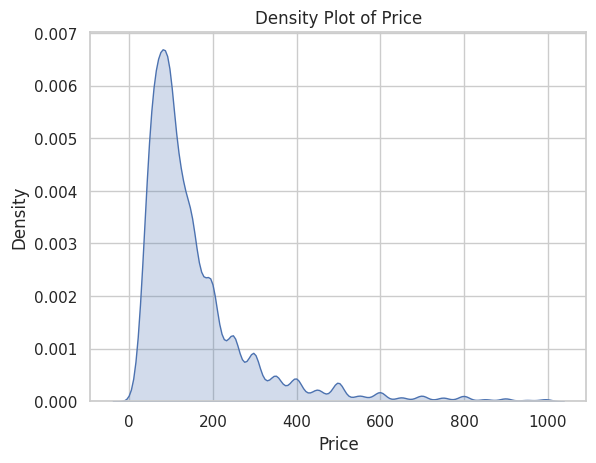

In [ ]:
# Convert the price column to float
df = df.withColumn("price", df["price"].cast("float"))

# Convert Spark DataFrame to Pandas DataFrame
df_pandas = df.select("price").toPandas()

# Plot density plot
sns.set(style="whitegrid")
sns.kdeplot(df_pandas["price"], shade=True)
plt.title("Density Plot of Price")
plt.xlabel("Price")
plt.ylabel("Density")
plt.show()

**Long Tail**: The plot exhibits a long tail to the right, indicating that while the majority of listings are at lower prices, there is a significant spread with some listings extending to higher prices, although they are fewer in number.

**Price Distribution**: The distribution of prices is right-skewed. This skewness indicates that the median price will be less than the mean price because of the influence of high-value outliers.

**Possible Outliers**: There appear to be spikes or bumps at higher prices which might suggest potential outliers or specific higher-priced segments within the listings.


## How do the number of bedrooms affect the price?

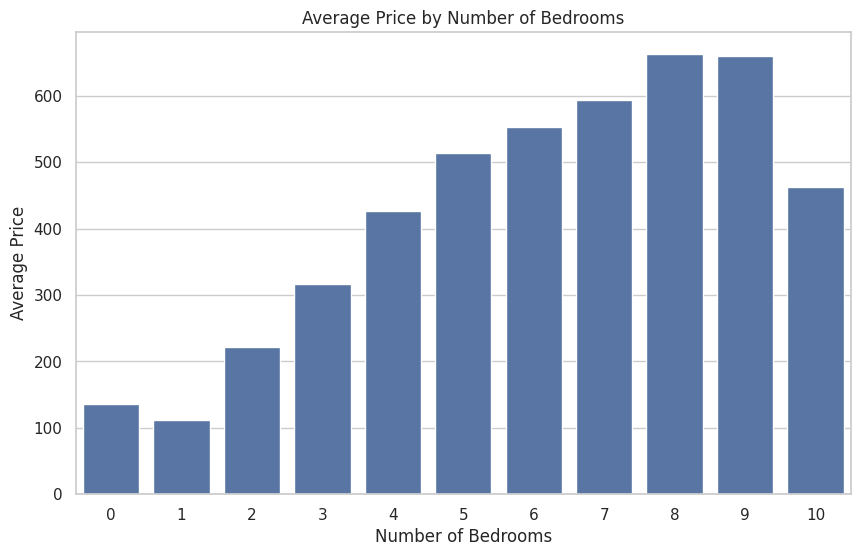

In [ ]:
# Aggregate data by number of bedrooms and compute average price
bedrooms_price = df.groupBy("bedrooms").agg({'price': 'mean'}).withColumnRenamed("avg(price)", "average_price")

# Convert to Pandas DataFrame for visualization
bedrooms_price_pd = bedrooms_price.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="bedrooms", y="average_price", data=bedrooms_price_pd)
plt.title('Average Price by Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Average Price')
plt.show()

**Increasing Trend**: We can observe a general increasing trend until in the average price until number of bedrooms reaches 8. This suggests that larger propertied with more bedrooms tend to be priced higher, which is expected as larger properties typically offer more space and can potentially accomodate more people.

**Variation in Increases**: The increases in average price are not uniform. The jump in average price from 2 to 3 bedrooms is notable and larger than the increase from 5 to 6 bedrooms.

**Decline for 10 Bedrooms**: There is a noticeable decrease in the average price for properties with 10 bedrooms compared to those with 9 bedrooms. This could suggest that such large properties are less common and perhaps less in demand, affecting their average market price.

**Data for 0 Bedrooms**: There are entries for properties with 0 bedrooms, which might represent studio apartments. These are priced lower than any other category, which aligns with market expectations that smaller units are less expensive.

## Property Type Analysis

In [ ]:
# Count the number of observations for each property type
property_type_counts = df.groupBy('property_type').count()

# Sort the counts in descending order to see the most common property types first
property_type_counts = property_type_counts.orderBy('count', ascending=False)

# Show the counts
property_type_counts.show()

+------------------+-----+
|     property_type|count|
+------------------+-----+
|         Apartment|74639|
|             House|40337|
|       Condominium| 4783|
|         Townhouse| 2788|
|              Loft| 2195|
|   Bed & Breakfast| 1090|
|             Other| 1070|
|        Guesthouse|  953|
|          Bungalow|  742|
|              Dorm|  325|
|             Villa|  264|
|         Camper/RV|  242|
|             Cabin|  242|
|    Boutique hotel|  164|
|         Timeshare|  134|
|            Hostel|  129|
|              Boat|  129|
|       Guest suite|   72|
|Serviced apartment|   47|
|              Tent|   41|
+------------------+-----+
only showing top 20 rows



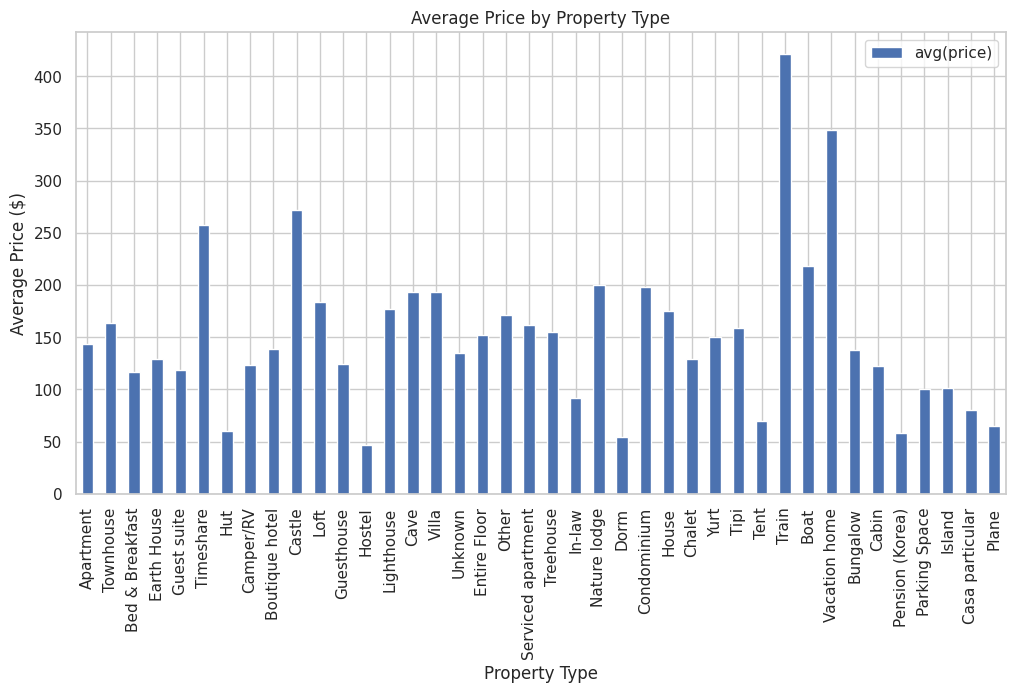

In [ ]:
# Group data by property type and calculate average price
avg_price_by_property_type = df.groupBy("property_type").avg("price")

# Plotting
avg_price_by_property_type.toPandas().plot(kind='bar', x='property_type', y='avg(price)', figsize=(12, 6))
plt.title('Average Price by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Average Price ($)')
plt.show()

**Diversity of Property Types**: The plot illustrates a wide variety of property types, from common ones like apartments and townhouses to unique options like boats and lighthouses.

**Highest Average Prices**: Certain property types, like lighthouses and castles, have the highest average prices among the categories listed. This could be due to their uniqueness, historical value, or luxury status.

**Variation in Average Price**:There is significant variation in the average price across different types of properties. This variation could be influenced by factors such as rarity, location, size, amenities, and the experience offered by the property.

**Conventional Properties**: More conventional properties like apartments, townhouses, and bed & breakfasts have relatively moderate average prices when compared to more unique or specialized property types.

**Lower-Priced Properties**: Some property types, like hostels, dorms, tents, and huts, have the lowest average prices. This is likely due to their less elaborate facilities and amenities or because usually in hostels or dorms you tend to live with strangers thus not making it comfortable for most people and consequently have low demand which drives the price.

**Special Properties**: Unique listings such as boat, caves,island ,villa, and treehouses command higher prices, possibly due to their niche appeal or the unique experiences they offer.

**Low Number of observations**: It is important to note that for some properties as we saw before with the count we have a low number of occurances and that could influence their pricing

We will group our property_type column into smallers groups for visualizations purposes.

In [ ]:
# Define a new column 'property_group' based on conditions
df = df.withColumn("property_group",
    when(col("property_type").isin(["Apartment", "Condominium", "House", "Townhouse", "Bungalow", "Villa", "Cabin", "Loft"]), "Standard Residences").
    when(col("property_type").isin(["Guesthouse", "Guest suite", "Serviced apartment", "Vacation home", "Entire Floor", "In-law"]), "Alternative Accommodations").
    when(col("property_type").isin(["Yurt", "Tipi", "Cave", "Island", "Lighthouse", "Treehouse", "Train", "Plane", "Boat", "Hut", "Casa particular", "Nature lodge", "Earth House", "Tent"]), "Unique and Exotic").
    when(col("property_type").isin(["Bed & Breakfast", "Hostel", "Dorm"]), "Hosted/Shared Spaces").
    when(col("property_type").isin(["Boutique hotel", "Timeshare", "Pension (Korea)"]), "Commercial or Specialized").
    when(col("property_type").isin(["Camper/RV", "Parking Space"]), "Mobile or Temporary Accommodations").
    otherwise("Other")
)

We will investigate the sentiment scores of the description column across the different property groups that we have created.

In [ ]:
# Initialize sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Define a function to calculate sentiment score
def calculate_sentiment_score(text):
    # Get the polarity scores for the text
    scores = sid.polarity_scores(text)
    # Return the compound score, which represents the overall sentiment
    return scores['compound']

nltk.download('vader_lexicon')

# Register the UDF
calculate_sentiment_udf = udf(calculate_sentiment_score, DoubleType())

# Apply sentiment analysis and create a new column 'sentiment_score' in your DataFrame
df = df.withColumn('sentiment_score', calculate_sentiment_udf(df['description']))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


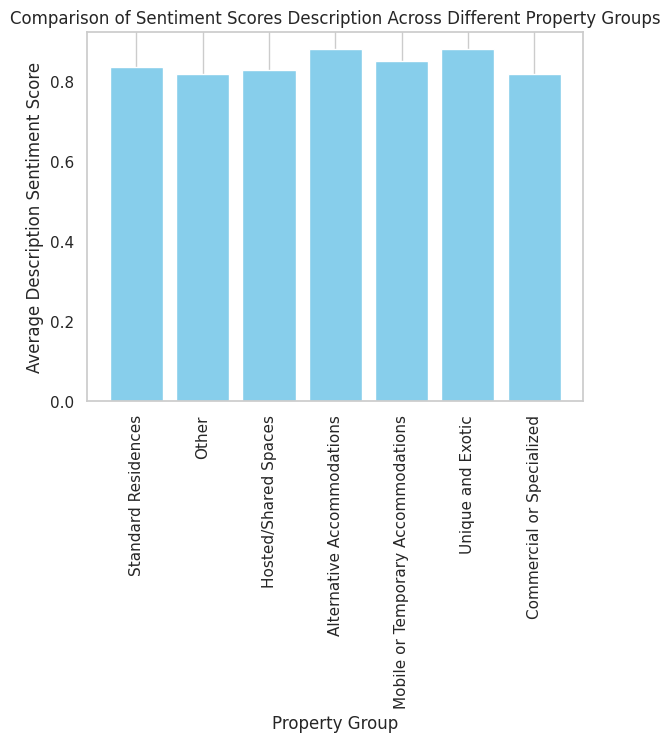

In [ ]:
# Group by property group and calculate average sentiment score
sentiment_by_property_group = df.groupBy('property_group').agg({'sentiment_score': 'mean'}).collect()

# Extract property groups and corresponding average sentiment scores
property_groups = [row['property_group'] for row in sentiment_by_property_group]
average_sentiment = [row['avg(sentiment_score)'] for row in sentiment_by_property_group]

# Plot average sentiment scores by property group
plt.bar(property_groups, average_sentiment, color='skyblue')
plt.xlabel('Property Group')
plt.ylabel('Average Description Sentiment Score')
plt.title('Comparison of Sentiment Scores Description Across Different Property Groups')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

**Alternative Accommodations** and **Unique and Exotic** property groups stand out with the highest average sentiment scores. This suggests that descriptions within these categories are perceived more positively compared to others. This could indicate that customers find these types of accommodations particularly appealing or interesting.   
Moreover, the remaining property groups seem to have relatively similar average sentiment scores. This suggests that, on average, descriptions within these groups evoke a comparable level of sentiment. It could imply that there's less variability in how customers perceive these types of accommodations.

## Relationship between number of reviews and price

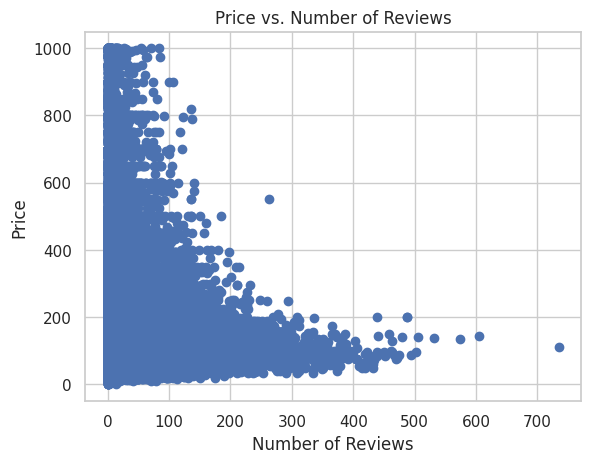

In [ ]:
# Relationship between number of reviews and price
reviews_vs_price = df.select("number_of_reviews", "price").toPandas()
plt.scatter(reviews_vs_price["number_of_reviews"], reviews_vs_price["price"])
plt.xlabel("Number of Reviews")
plt.ylabel("Price")
plt.title("Price vs. Number of Reviews")
plt.show()

**No Clear Correlation**: There does not appear to be a strong correlation between the price and the number of reviews. Listings are scattered throughout the plot without a clear pattern.

**Price Concentration**: A large concentration of listings is priced at $200 or less, regardless of the number of reviews. This suggests that lower-priced properties are more common in the dataset.

**Review Distribution**: Many listings have a low number of reviews, with the bulk of data points clustered around the lower end of the number of reviews axis. This might imply that either many properties are relatively new on the market or that a significant number of properties do not get reviewed often.

**High-Price Properties**: There are properties with very high prices that have a moderate number of reviews. This could indicate luxury properties that are less frequently booked but still receive some reviews.

## Host Response Time Distribution

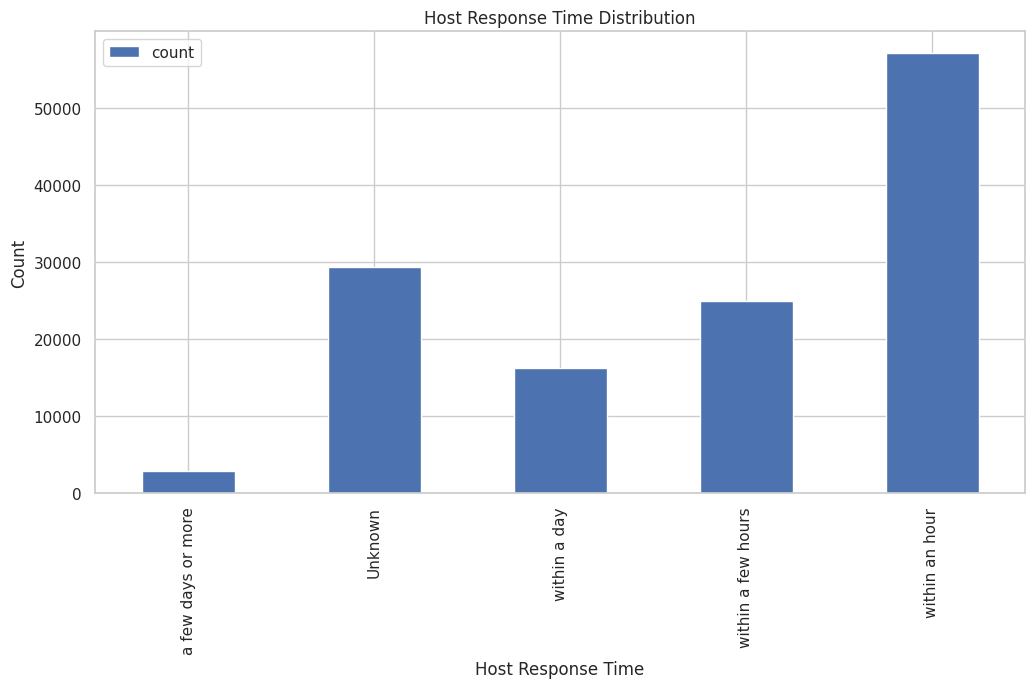

In [ ]:
# Count the occurrences of each host response time
response_time_distribution = df.groupBy("host_response_time").count()

# Plotting
response_time_distribution.toPandas().plot(kind='bar', x='host_response_time', y='count', figsize=(12, 6))
plt.title('Host Response Time Distribution')
plt.xlabel('Host Response Time')
plt.ylabel('Count')
plt.show()

**Most Hosts Respond Quickly**: The majority of hosts respond within an hour, indicating a high level of responsiveness among hosts on the platform.

**Significant Unknown Responses**: There is a notable number of hosts for whom the response time is unknown. This category has the second-highest count, suggesting that for a large segment of listings, the response time is not recorded, or hosts have not responded to messages yet most probable is a mix of both.

**Few Delays in Response**: A relatively small number of hosts respond in "a few days or more." This suggests that hosts who take longer to respond are the minority, which could be beneficial for the overall user experience on the platform.

**Conclusion**: These observations provide insights for the overall good communication of hosts on the platform but it can also signify an area for improvement in data collection or host engagement for those with unknown response times.

## Listing Availability Over Time

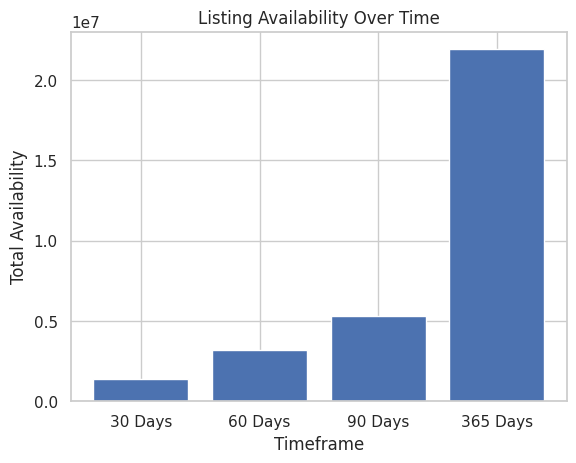

In [ ]:
# Select availability columns for the next 30, 60, 90, and 365 days
availability_df = df.select("availability_30", "availability_60", "availability_90", "availability_365")

# Sum up availability for each timeframe
availability_totals = availability_df.agg({"availability_30": "sum",
                                           "availability_60": "sum",
                                           "availability_90": "sum",
                                           "availability_365": "sum"}).collect()[0]

# Extract availability totals
availability_data = [availability_totals["sum(availability_30)"],
                     availability_totals["sum(availability_60)"],
                     availability_totals["sum(availability_90)"],
                     availability_totals["sum(availability_365)"]]

# Plot bar chart
timeframes = ["30 Days", "60 Days", "90 Days", "365 Days"]
plt.bar(timeframes, availability_data)
plt.xlabel("Timeframe")
plt.ylabel("Total Availability")
plt.title("Listing Availability Over Time")
plt.show()

**Increased Availability in Longer Timeframes**: There's a clear trend showing increased total availability as the timeframe extends.

**Short-Term Shortage**: The significant difference in availability between 30 days and 365 days indicates that listings are much less likely to be available in the short term. This might be due to advance bookings.

**Increase in Availability**: As the timeframe increases from 30 days to 90 days, there is a moderate increase in availability, indicating that while short-term availability is limited, hosts are more flexible with bookings that are at least a few months out.

## Relationship between Price and Total Review Scores

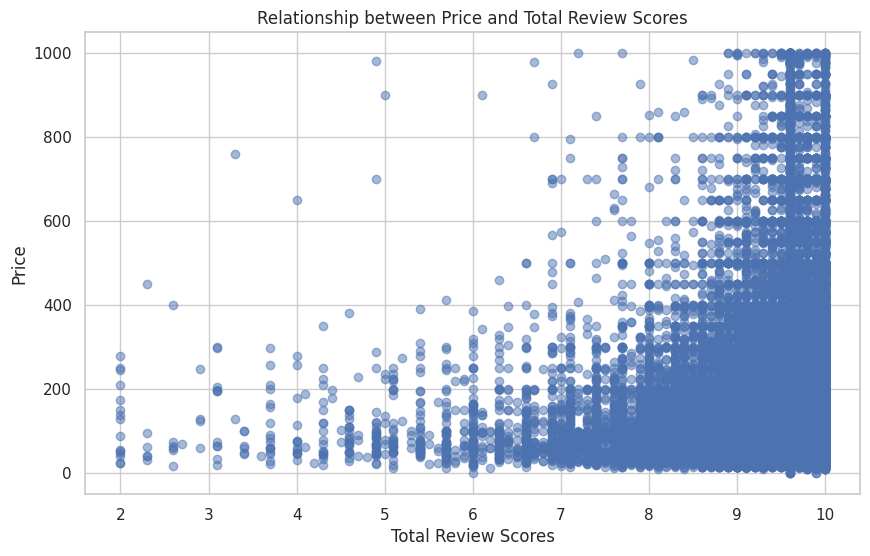

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for plotting
df_pd = df.select("price", "total_review_scores").toPandas()

# Plot scatter plot
plt.figure(figsize=(10, 6))
plt.scatter( df_pd["total_review_scores"],df_pd["price"], alpha=0.5)
plt.title("Relationship between Price and Total Review Scores")
plt.ylabel("Price")
plt.xlabel("Total Review Scores")
plt.grid(True)
plt.show()

**Wide Range of Prices Across Review Scores**: From the plot we can observe a wide range of prices across review scores. listings with high review scores (close to 10) span a wide range of prices, from the very low to the high end. This suggests that highly-rated listings are not exclusively expensive and that there are budget-friendly options with high review scores as well.

**Concentration of High Scores**: We also have a concentration of high scores. There's a heavy concentration of listings with review scores between 9 and 10, regardless of price. This could indicate that most listings on the platform are of high quality, or that users tend to leave favorable reviews.

**Less Variation in Lower Scores**: On the other hand we have less variation in lower scores. Listings with lower review scores (below 5) are relatively fewer and show less price variation compared to those with higher scores. This could imply that fewer listings perform poorly in terms of reviews, and those that do are clustered within a certain price range.

## Occurrence of Features by Room Type

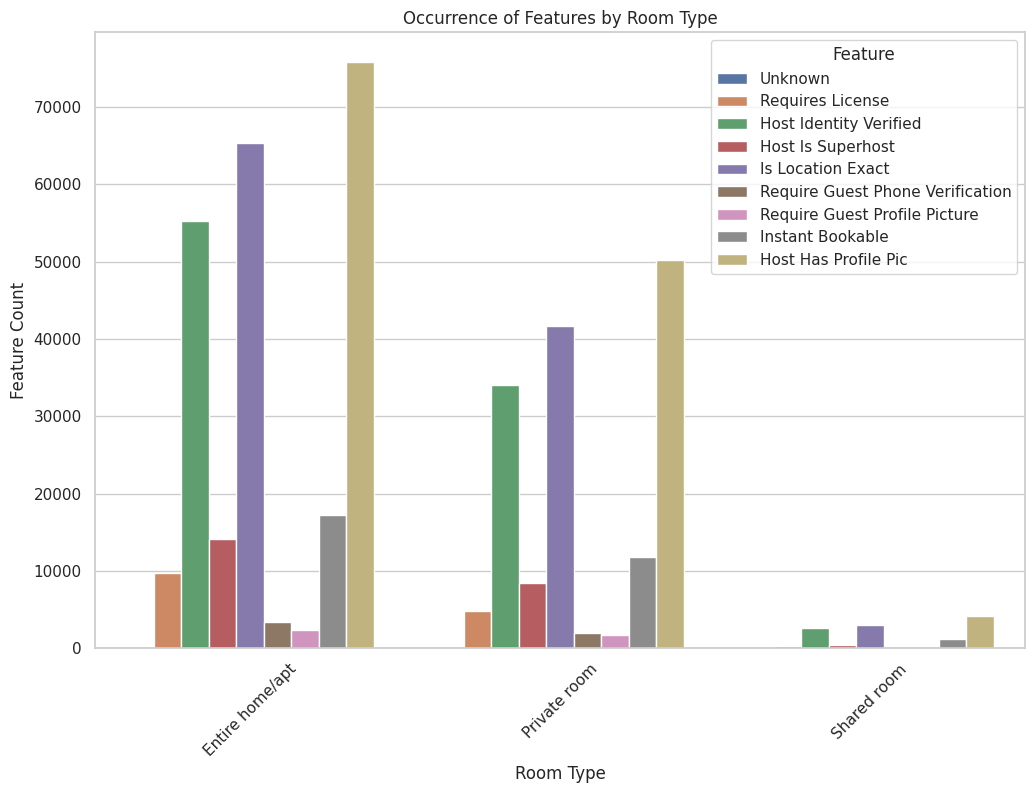

In [ ]:
# 1. Extract and explode the 'features' column
exploded_df = df.select(explode("features").alias("feature"), "room_type")

# 2. Count the occurrence of each feature by room type
feature_count_by_room_type = exploded_df.groupBy("room_type", "feature").count()

# Convert the result to Pandas DataFrame for easier plotting
feature_count_by_room_type_pandas = feature_count_by_room_type.toPandas()

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='room_type', y='count', hue='feature', data=feature_count_by_room_type_pandas)
plt.title('Occurrence of Features by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Feature Count')
plt.xticks(rotation=45)
plt.legend(title='Feature')
plt.show()

**Prevalence of Entire Home/Apt Listings**: There is a clear majority of listings of entire home/apt listings.

**Lest Features Shared Rooms**: "Shared room" listings generally have the lowest count which might suggest these types of listings are less common.

**Top 4 features across categories**: We can see in all categories the most frequent features are "Host has profile pic", "is location exact", "host identity verified" and "instante bookable". This indicates that regardless of the room type, hosts recognize the importance of having a profile picture and being verified are important features to build trust and attract guests.

## Urban vs Suburban City Types

We will categorize the cities based on their density, we got that information from the uscities.csv file. From exploration on the web we will set the threshold to 10.000.



In [ ]:
# Define a threshold for population density to classify as urban or suburban
density_threshold = 10000

# Classify cities in uscities_df as urban or suburban based on density
uscities_df = uscities_df.withColumn('urban_or_suburban',
                                     when(uscities_df['density'] >= density_threshold, 'Urban').otherwise('suburban'))

# Create a dictionary mapping cities to their classifications
city_classification_map = dict(uscities_df.select('city', 'urban_or_suburban').collect())

# Define a UDF to map city names to their classifications
classify_city_udf = F.udf(lambda city: city_classification_map.get(city, 'Unknown'), StringType())

# Apply the classification original DataFrame
df_with_classification = df.withColumn('urban_or_suburban', classify_city_udf(df['city']))

df_with_classification.show()

+----------+--------------------+------------+--------------------+---------------+----------------+---------------+---------------+---------+--------+--------+----+-------------------+------------+--------------------+------------+--------------------+---------------+--------------------+---------+-------------------+------------------+------------------+-------------------------+--------------------+--------------------+--------+--------------------+------------------+-------------------+--------------+--------------+-------------+--------------------+---------------------+----------------+--------------------+-----------------+-----+-------------+------------------+---------------+----------------+--------------------+--------------------+--------------------+--------------------+------------+-----------------------+-------------------+--------+-------+--------------------+---------------+-----------------+
|      city|              access|accommodates|           amenities|availabil

In [ ]:
# Count the number of suburban and urban cities
urban_count = df_with_classification.filter(col('urban_or_suburban') == 'Urban').count()
suburban_count = df_with_classification.filter(col('urban_or_suburban') == 'suburban').count()

# Print the counts
print("Number of Urban Cities:", urban_count)
print("Number of suburban Cities:", suburban_count)

Number of Urban Cities: 19878
Number of suburban Cities: 110697


<ipython-input-69-61480535fc30>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='urban_or_suburban', y='average_price', data=average_price_df, palette='viridis')


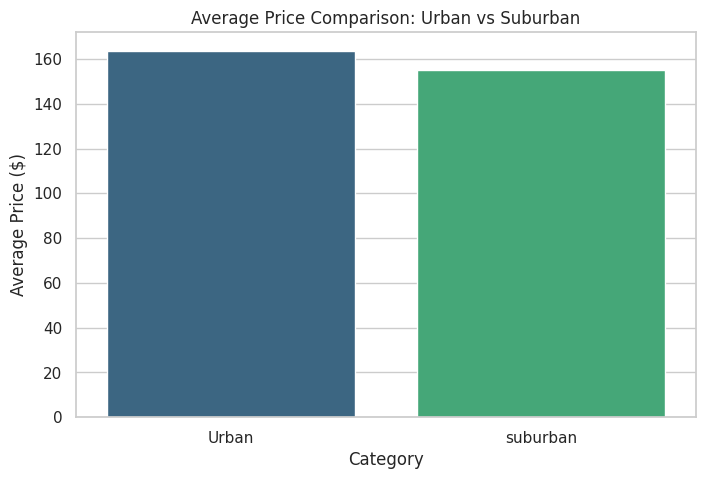

In [ ]:
average_prices = df_with_classification.groupBy("urban_or_suburban").agg(avg("price").alias("average_price"))

# Convert the Spark DataFrame to a Pandas DataFrame
average_price_df = average_prices.toPandas()

# Plotting the results with Seaborn
plt.figure(figsize=(8, 5))
sns.barplot(x='urban_or_suburban', y='average_price', data=average_price_df, palette='viridis')
plt.title('Average Price Comparison: Urban vs Suburban')
plt.xlabel('Category')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=0)
plt.show()

The average price of urban listings appears to be higher than that of suburban listings, suggesting that properties in urban areas may be priced at a premium compared to those in suburban areas.

There is a clear distinction between the two categories, which could be indicative of different market dynamics, such as demand and supply differences, between urban and suburban locations.

## Features column Analysis

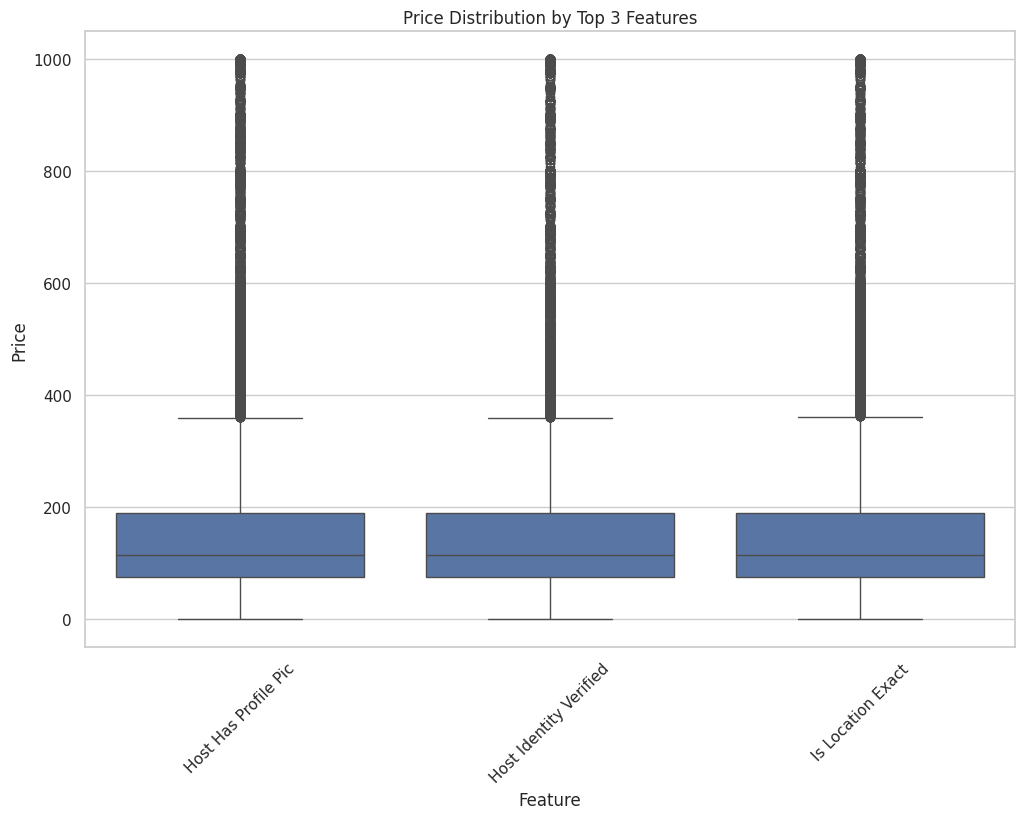

In [ ]:
# Filter DataFrame to include only the relevant columns
filtered_df = df.select("price", "features")

# Explode the 'features' column
exploded_df = filtered_df.select(explode("features").alias("feature"), "price")

# Filter for the top 3 features
top_features = ["Host Identity Verified", "Is Location Exact", "Host Has Profile Pic"]
filtered_exploded_df = exploded_df.filter(exploded_df["feature"].isin(top_features))

# Convert the result to Pandas DataFrame for easier plotting
filtered_exploded_pd = filtered_exploded_df.toPandas()

# Create box plots
plt.figure(figsize=(12, 8))
sns.boxplot(x="feature", y="price", data=filtered_exploded_pd)
plt.title('Price Distribution by Top 3 Features')
plt.xlabel('Feature')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

**Media Price**: The median prices for listings with "Host Has Profile Pic", "Host Identity Verified", and "Is Location Exact" features appear to be similar. This suggests that these top features do not drastically differentiate listings in terms of median pricing.

**Range of Prices**: All three features show a wide range of prices, with many outliers on the higher end. This indicates that while the median prices are similar, each feature category includes both budget and luxury listings.

From the above plot, we conclude that it doesn't mean the top 3 features will also have the highest prices. So, we will plot the price among with all the available fatures and not just the top 3.

<ipython-input-71-3cb4f6229058>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="feature", y="price", data=exploded_pd, palette="Set3")


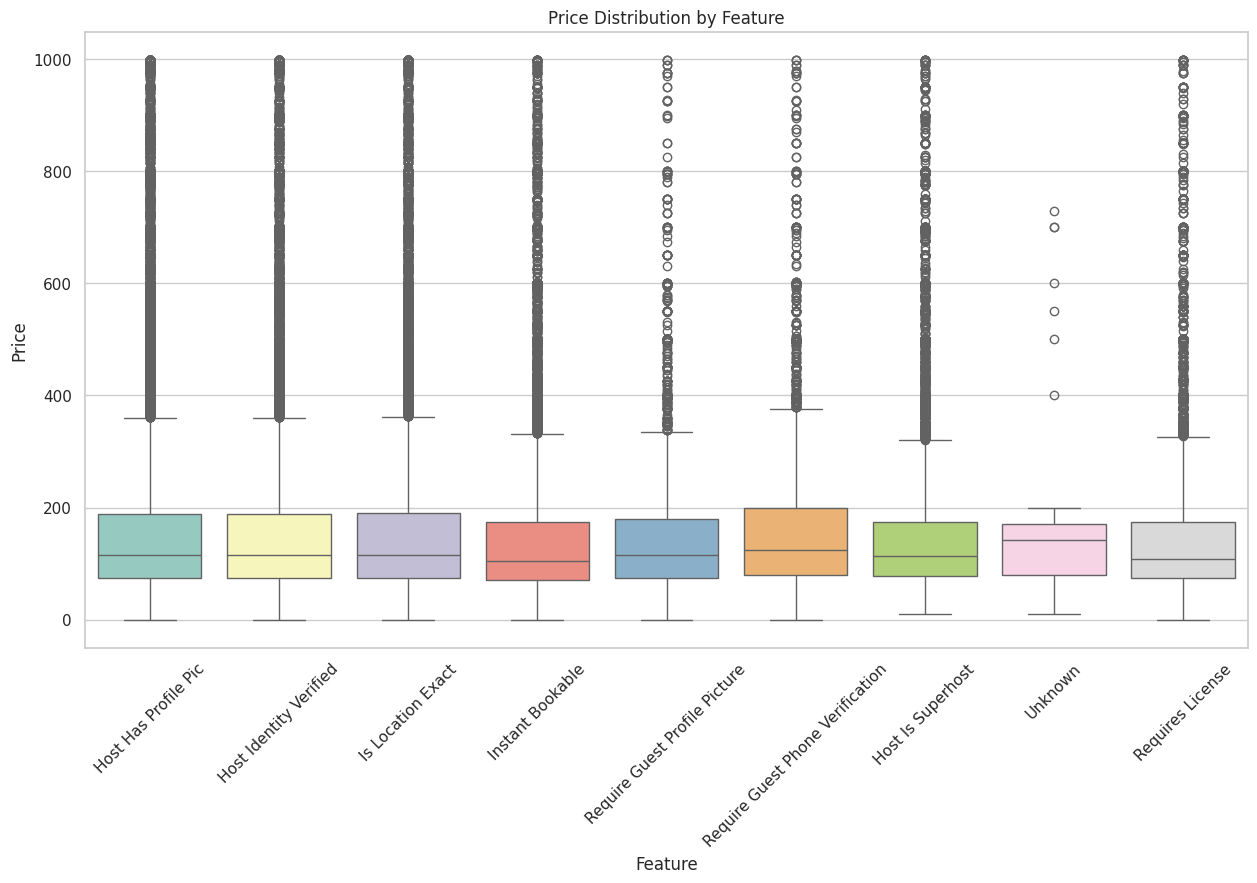

In [ ]:
# Filter DataFrame to include only the relevant columns
filtered_df = df.select("price", "features")

# Explode the 'features' column
exploded_df = filtered_df.select(explode("features").alias("feature"), "price")

# Convert the result to Pandas DataFrame for easier plotting
exploded_pd = exploded_df.toPandas()

# Create box plots
plt.figure(figsize=(15, 8))
sns.boxplot(x="feature", y="price", data=exploded_pd, palette="Set3")
plt.title('Price Distribution by Feature')
plt.xlabel('Feature')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

**Median observations**: The median prices across various features are quite uniform, with no significant differences. This indicates that these features, while they may be top-rated or most common, don't necessarily correspond to higher or lower median prices.

**Outliers**: There are numerous outliers in pricing across all features, extending to the upper price range of $1000. This suggests that regardless of the feature, there are always listings that are priced significantly higher than the average. Only exceptiong to the outliers is the feature "Unknown".



## Amenities Column

In [ ]:
# Explode the amenities column to create a row for each amenity
exploded_amenities_df = df.withColumn("amenity", explode(df["amenities"]))

# Count the occurrences of each amenity
amenity_counts = exploded_amenities_df.groupBy("amenity").count()

# Order by count in descending order and select the top 20
top_20_amenities = amenity_counts.orderBy(desc("count")).limit(20)

# Show the top 20 amenities
top_20_amenities.show(truncate=False)

+-------------------------+------+
|amenity                  |count |
+-------------------------+------+
|Wireless Internet        |125172|
|Heating                  |119023|
|Kitchen                  |119018|
|Essentials               |111238|
|TV                       |93677 |
|Smoke detector           |90270 |
|Shampoo                  |89340 |
|Internet                 |88458 |
|Washer                   |83059 |
|Dryer                    |82343 |
|Air conditioning         |81877 |
|Hangers                  |79953 |
|Iron                     |68931 |
|Carbon monoxide detector |66821 |
|Laptop friendly workspace|62183 |
|Hair dryer               |61800 |
|Family/kid friendly      |56865 |
|Fire extinguisher        |48303 |
|Cable TV                 |45658 |
|Free parking on premises |42953 |
+-------------------------+------+



### Average Price by Top 20 Amenities

<ipython-input-73-c7c8794b7d8b>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="avg(price)", y="amenity", data=top_20_amenity_price_avg_pd, palette="viridis")


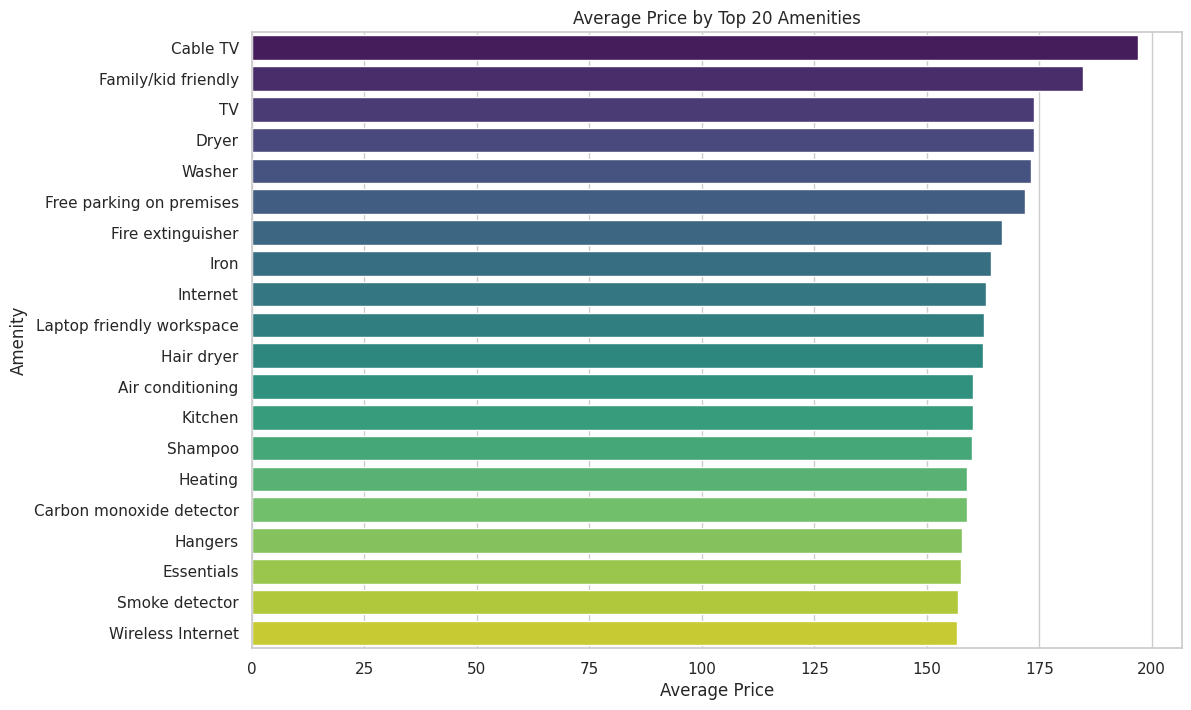

In [ ]:
# Calculate the average price for listings with each amenity
amenity_price_avg = exploded_amenities_df.groupBy("amenity").agg({"price": "avg"})

# Filter for the top 20 amenities
top_20_amenities_list = [row.amenity for row in top_20_amenities.collect()]
top_20_amenity_price_avg = amenity_price_avg.filter(amenity_price_avg["amenity"].isin(top_20_amenities_list))

# Convert DataFrame to Pandas for plotting
top_20_amenity_price_avg_pd = top_20_amenity_price_avg.toPandas()

# Sort the data by average price in descending order
top_20_amenity_price_avg_pd = top_20_amenity_price_avg_pd.sort_values(by="avg(price)", ascending=False)

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x="avg(price)", y="amenity", data=top_20_amenity_price_avg_pd, palette="viridis")
plt.title("Average Price by Top 20 Amenities")
plt.xlabel("Average Price")
plt.ylabel("Amenity")
plt.show()

**Cable TV Commands Higher Prices**: Listings that offer Cable TV appear to have the highest average price among the top 20 amenities.

**Importance of Family-Friendly Amenities**: The second-highest average price is associated with properties labeled as family/kid-friendly, suggesting that accommodations suitable for families may be able to command higher prices, potentially due to their larger size or additional facilities.

**Standard Amenities Across Various Prices**: Amenities like "Wireless Internet", "Smoke Detector", and "Essentials" are present in listings across a broad range of average prices, highlighting that these are likely standard offerings and not differentiators for higher-priced listings.



From the above plot, we can clearly see that while Wireless Internet is the most common amenity, listings that have it do not also have the higher average price.
While we capture the higher average price with Cable TV amenity, but only among top 20 amenities, we can not be sure that any other amenity not included in the top amenities can appear with the highest average price.

So, we will create a plot with all the amenities sorted by average price.

<ipython-input-74-312c22b94654>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="avg(price)", y="amenity", data=top_amenities_pd, palette="viridis")


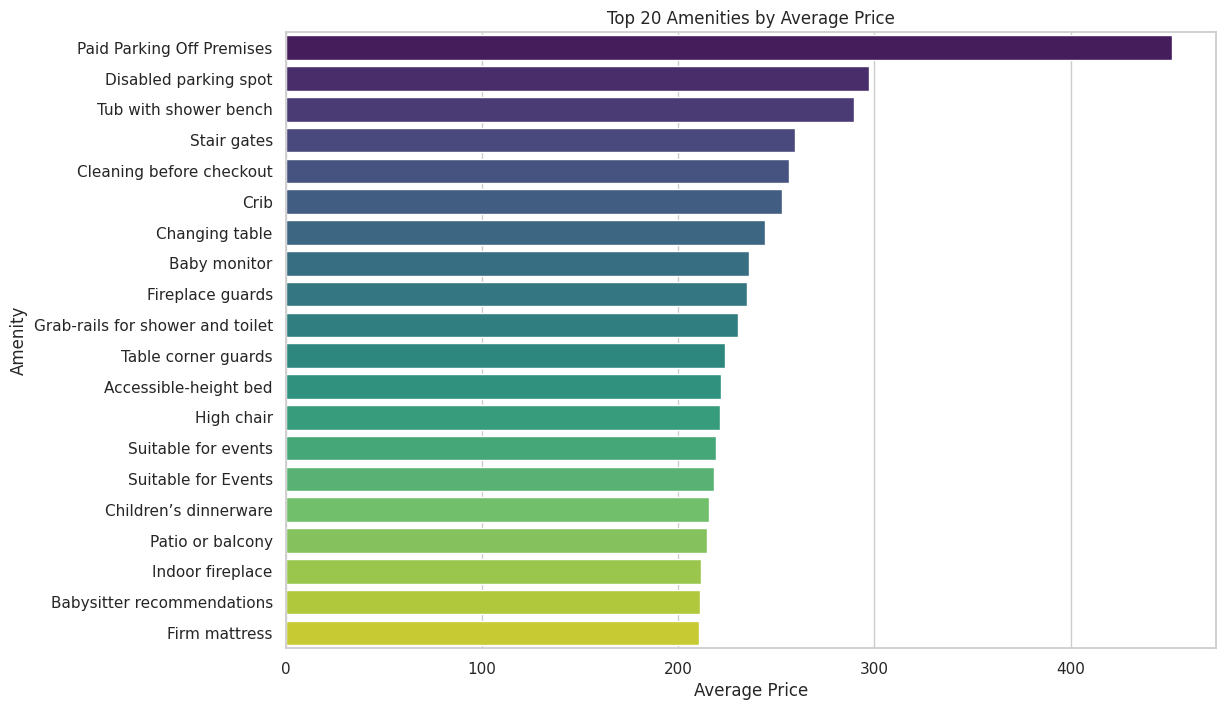

In [ ]:
# Calculate the average price for listings with each amenity
amenity_price_avg = exploded_amenities_df.groupBy("amenity").agg({"price": "avg"})

# Sort the data by average price in descending order
amenity_price_avg = amenity_price_avg.sort("avg(price)", ascending=False)

# Filter for the top amenities with the highest average prices
top_amenities_count = 20
top_amenities = amenity_price_avg.limit(top_amenities_count)

# Convert DataFrame to Pandas for plotting
top_amenities_pd = top_amenities.toPandas()

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x="avg(price)", y="amenity", data=top_amenities_pd, palette="viridis")
plt.title(f"Top {top_amenities_count} Amenities by Average Price")
plt.xlabel("Average Price")
plt.ylabel("Amenity")
plt.show()

**Parking Commands High Prices**: The highest average price with a big difference from the second amenity is associated with listings that offer "Paid Parking Off Premises," suggesting that listings with paid parking facilities, potentially in areas where parking is scarce or expensive, can command higher prices.

**Accessibility Features**: Amenities related to accessibility, such as "Disabled parking spot" and "Tub with shower bench," are associated with higher average prices. This may indicate that listings with features catering to guests with disabilities or mobility issues are fewer and can charge more due to their specialized nature.

**Child-Friendly Features**: Amenities like "Stair gates," "Crib," and "Baby monitor" are in the upper range, which could imply that listings equipped to accommodate families with young children tend to have a higher average price, possibly reflecting the added value or costs of providing these features.


This plot agree with our hypothesis, as there are other amenities that have higher average prices rather the most frequent ones.

## Average Price for every State

<ipython-input-75-6067b5d2f9b2>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='state_id', y='avg(price)', data=average_price_by_state_pd, palette=color_palette)


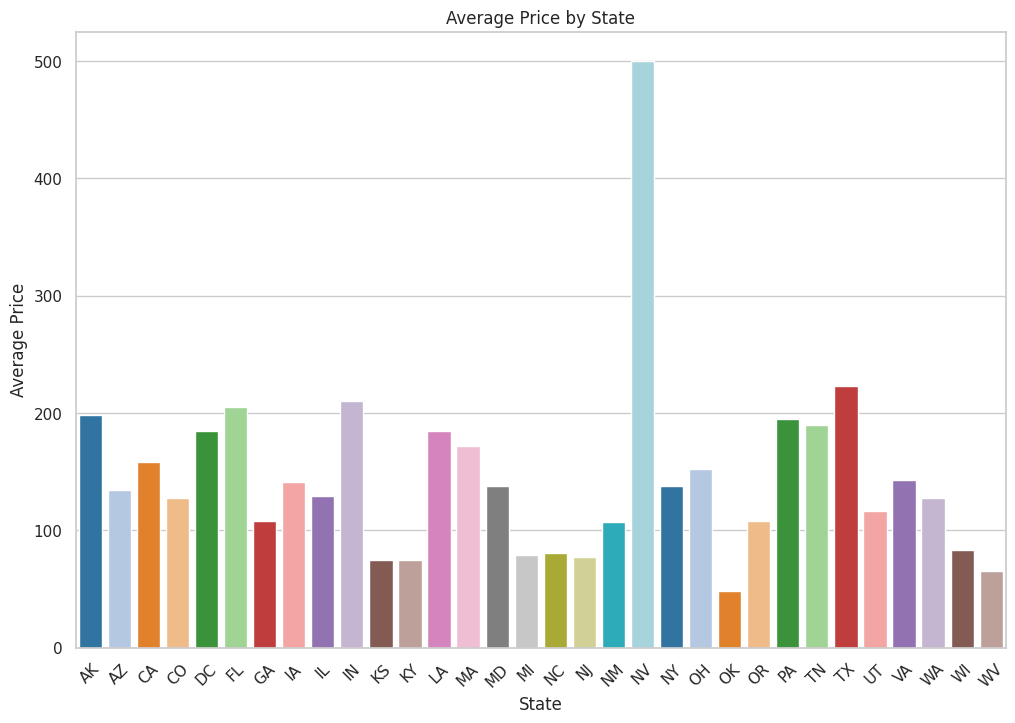

In [ ]:
# Calculate the average price for each state
average_price_by_state = df.groupBy("state_id").avg("price").orderBy("state_id")

# Convert DataFrame to Pandas for plotting
average_price_by_state_pd = average_price_by_state.toPandas()

# Set a color palette with distinct colors for each state
color_palette = sns.color_palette("tab20", n_colors=len(average_price_by_state_pd))

# Plot the average price for each state with distinct colors
plt.figure(figsize=(12, 8))
sns.barplot(x='state_id', y='avg(price)', data=average_price_by_state_pd, palette=color_palette)
plt.title('Average Price by State')
plt.xlabel('State')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

**Significant Variation Between States**: There is a significant variation in average prices between different states. This could reflect the cost of living, tourism demand, or availability of rental properties in each state.

**Peak Average Price in One State**: One state, which appears to be Nevada (NV), stands out with a much higher average price compared to the others. This could be due to the most popular city in this state Los Angeles which is a popular vacation destination and very high cost of living driving up the average cost of rentals.

**Consistent Mid-Range Prices**: Many states have average prices clustered in the mid-range, between \$100 and \$200. This suggests that there is a common price range that is likely acceptable to a broad segment of the market across various states.

**Lower Average Price States**: Some states appear to have notably lower average prices, potentially indicating a lower cost of living, less demand for vacation rentals, or more competition among hosts.

## Average Price vs Host Years Since Joined

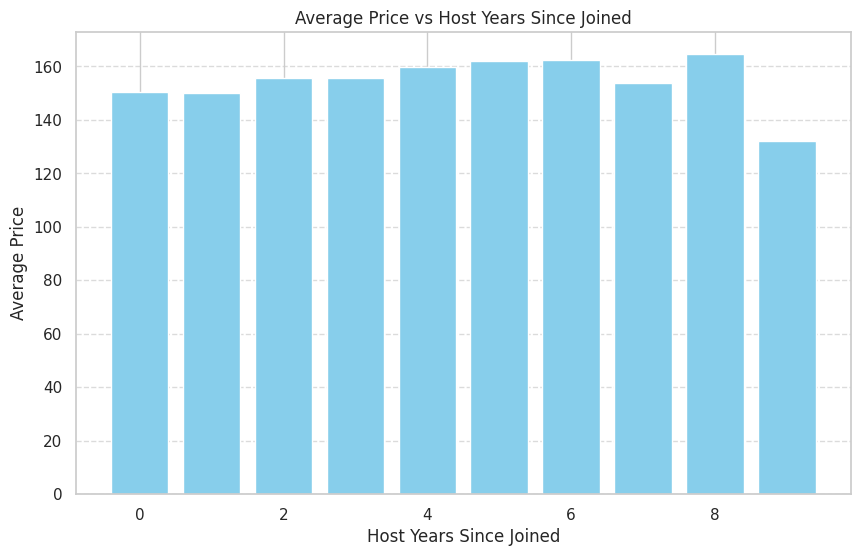

In [ ]:
# Calculate the average price for each host_years_since_joined category
average_price_by_year = df.groupBy("host_years_since_joined").avg("price").orderBy("host_years_since_joined")

# Convert DataFrame to Pandas for plotting
average_price_by_year_pd = average_price_by_year.toPandas()

# Plot the average price vs host_years_since_joined
plt.figure(figsize=(10, 6))
plt.bar(average_price_by_year_pd["host_years_since_joined"], average_price_by_year_pd["avg(price)"], color='skyblue')
plt.title('Average Price vs Host Years Since Joined')
plt.xlabel('Host Years Since Joined')
plt.ylabel('Average Price')
plt.xticks()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**No Clear Trend with Experience**: There doesn't appear to be a clear upward or downward trend in average price based on the number of years a host has been with the platform. This suggests that experience as measured by years on the platform doesn’t necessarily equate to higher or lower pricing.

**Slight Peak at Mid-Tenure**: Hosts who have been on the platform for approximately 6 years have a slightly higher average price compared to those with more or less experience. This could indicate that mid-tenure hosts might have optimized their pricing based on their experience and market knowledge.

**Newest and Most Experienced Hosts**: Both the newest hosts (0 years) and the most experienced hosts (8 years) have lower average prices compared to mid-tenure hosts. New hosts might be pricing competitively to attract initial reviews, while veterans could be offering discounts due to established reputation or possibly older listings with outdated pricing.

**Relative Price Consistency**: Despite some variation, the overall price range across different host tenures is relatively consistent, indicating that other factors besides the length of time a host has been on the platform may play more significant roles in pricing decisions.

# Sentiment Analysis

## Name of listing Sentiment Analysis

Perform sentiment analysis on the listing names to check if certain types of names attract more people and how this affects the price.

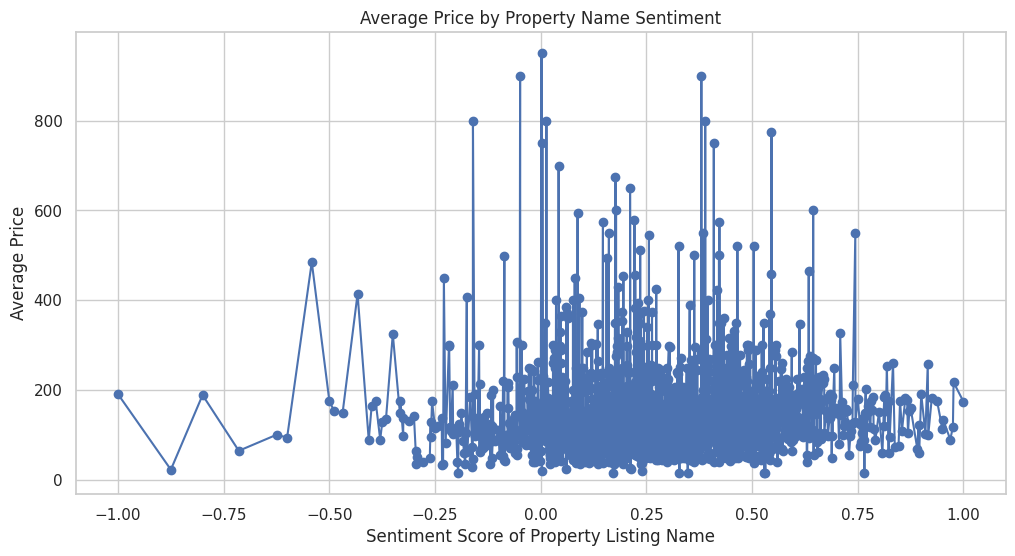

In [ ]:
from textblob import TextBlob
from pyspark.sql.types import FloatType

# Define a function to calculate sentiment score
def get_sentiment_score(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Define a UDF for the sentiment analysis function
sentiment_udf = udf(get_sentiment_score, FloatType())

# Apply sentiment analysis to the listing names
df_with_sentiment = df.withColumn('name_sentiment', sentiment_udf(df['name']))

# Group by sentiment score and calculate the average price
avg_price_sentiment = df_with_sentiment.groupBy('name_sentiment').agg({"price": "avg"}).orderBy('name_sentiment')

# Convert Spark DataFrame to Pandas DataFrame
avg_price_sentiment_pd = avg_price_sentiment.toPandas()

# Plot the average price by sentiment score
plt.figure(figsize=(12, 6))
plt.plot(avg_price_sentiment_pd['name_sentiment'], avg_price_sentiment_pd['avg(price)'], marker='o')
plt.xlabel('Sentiment Score of Property Listing Name')
plt.ylabel('Average Price')
plt.title('Average Price by Property Name Sentiment')
plt.grid(True)
plt.show()

**Wide Range of Prices Across Sentiments**: The plot shows a wide range of average prices for listings across the sentiment score spectrum. This indicates that the sentiment of a listing's name does not have a clear relationship with its pricing.

**Sparse Data at Negative Sentiment**: There are fewer data points with strongly negative sentiment scores. This sparsity could be because most hosts opt for positive or neutral names to attract guests, as negative sentiment might be unappealing in a listing.

We also observe that even though a listing's name could potentially have an impact from a marketing perspective it seems to have a complex relationship with the listing's price.

We can conclude from all the above that there are other variables that influence the pricing more directly.

## Transit Sentiment Analysis

Perform a similar analysis for transit information

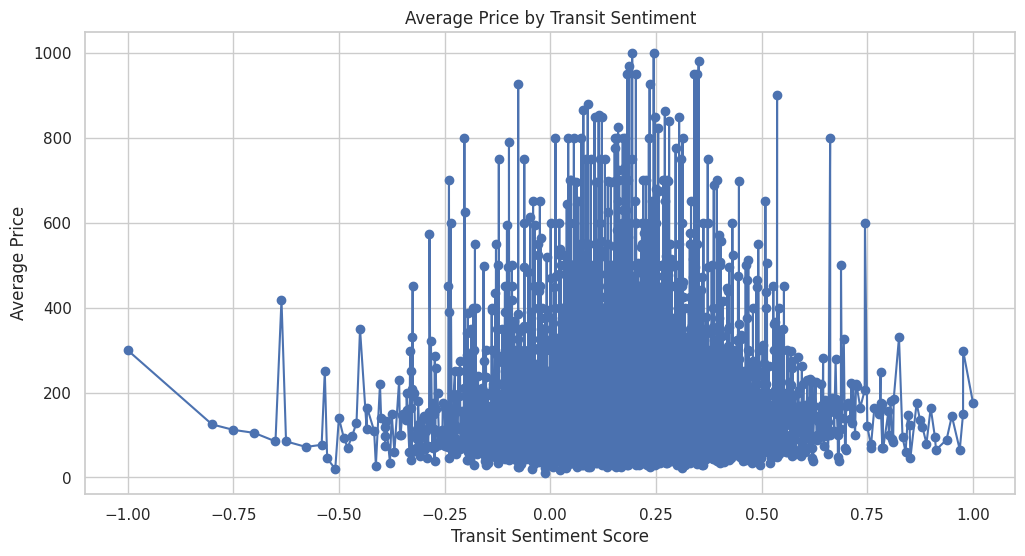

In [ ]:
# Define a UDF to calculate sentiment score for transit information
transit_sentiment_udf = udf(get_sentiment_score, FloatType())

# Apply sentiment analysis to the transit information
df_with_transit_sentiment = df.withColumn('transit_sentiment', transit_sentiment_udf(df['transit']))

# Group by transit sentiment score and calculate the average price
avg_price_transit_sentiment = df_with_transit_sentiment.groupBy('transit_sentiment').agg({"price": "avg"}).orderBy('transit_sentiment')

# Convert Spark DataFrame to Pandas DataFrame
avg_price_transit_sentiment_pd = avg_price_transit_sentiment.toPandas()

# Plot the average price by transit sentiment score
plt.figure(figsize=(12, 6))
plt.plot(avg_price_transit_sentiment_pd['transit_sentiment'], avg_price_transit_sentiment_pd['avg(price)'], marker='o')
plt.xlabel('Transit Sentiment Score')
plt.ylabel('Average Price')
plt.title('Average Price by Transit Sentiment')
plt.grid(True)
plt.show()

We can make the same observations of wide range of prices across sentiment score for the transit variable and Sparse Data at Negative Sentiment which means that there are fewer data points with strongly negative sentiment scores.

We also again conclude there are other variables that influence the pricing more directly.

## Description & Name Sentiment Analysis

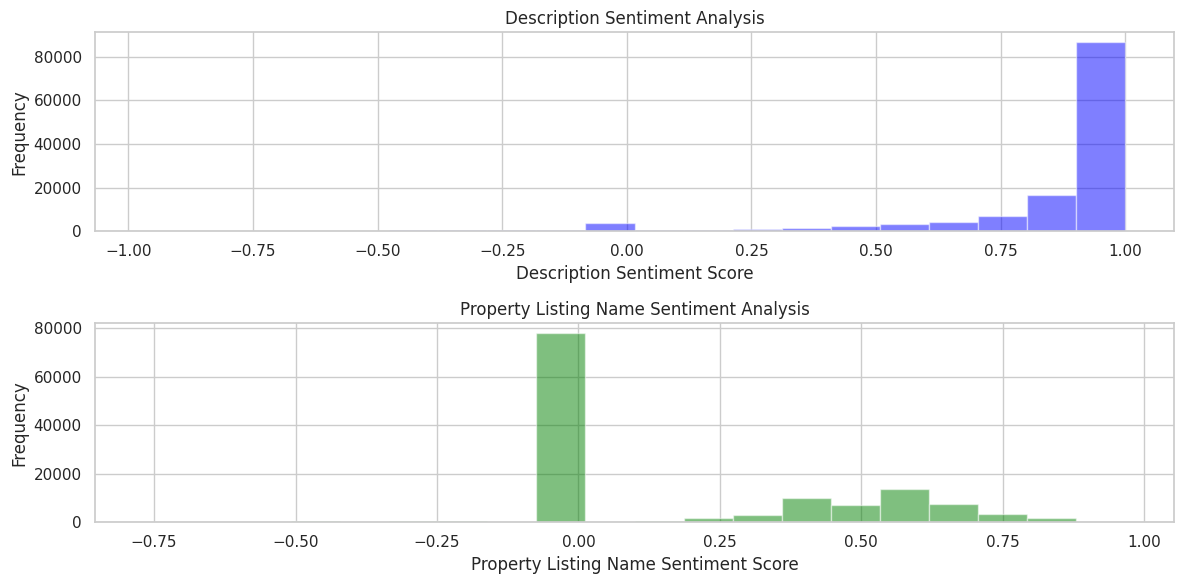

In [ ]:
# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Define a UDF for sentiment analysis
sentiment_udf = udf(lambda text: sid.polarity_scores(text)['compound'], FloatType())

# Perform sentiment analysis on descriptions
df_with_sentiment = df.withColumn('description_sentiment', sentiment_udf('description'))

# Perform sentiment analysis on names
df_with_sentiment = df_with_sentiment.withColumn('name_sentiment', sentiment_udf('name'))

# Plotting
plt.figure(figsize=(12, 6))

# Description Analysis plot
plt.subplot(2, 1, 1)
df_desc_sentiment_pd = df_with_sentiment.select('description_sentiment').toPandas()
plt.hist(df_desc_sentiment_pd['description_sentiment'], bins=20, color='blue', alpha=0.5)
plt.xlabel('Description Sentiment Score')
plt.ylabel('Frequency')
plt.title('Description Sentiment Analysis')

# Name Analysis plot
plt.subplot(2, 1, 2)
df_name_sentiment_pd = df_with_sentiment.select('name_sentiment').toPandas()
plt.hist(df_name_sentiment_pd['name_sentiment'], bins=20, color='green', alpha=0.5)
plt.xlabel('Property Listing Name Sentiment Score')
plt.ylabel('Frequency')
plt.title('Property Listing Name Sentiment Analysis')

plt.tight_layout()
plt.show()

1. For the Description plot:

**Positive Sentiment Dominance**: The overwhelming majority of property descriptions have positive sentiment scores, with most observations being close to 1.

**Sparse Negative Sentiment**: Negative statements cannot be seen so they are either zero or maybe a few that cannot be seen.

**Neutral Sentiments Are Uncommon**: There's a noticeable lack of descriptions with a neutral sentiment around 0, suggesting that most listings are intentionally written with positive language to attract guests which is expected.


2. For the listings name plot:

**Predominance of Neutral Names**: The highest frequency of sentiment scores for property names is centered around the neutral score 0, suggesting that property names are more likely to be descriptive without strong positive or negative connotations.

**Some Positively Skewed Names**: There's a smaller, yet significant number of property names with positive sentiment scores, implying that some hosts use positive language in their property names as well.

## Sentiment Analysis Distribution for Host About

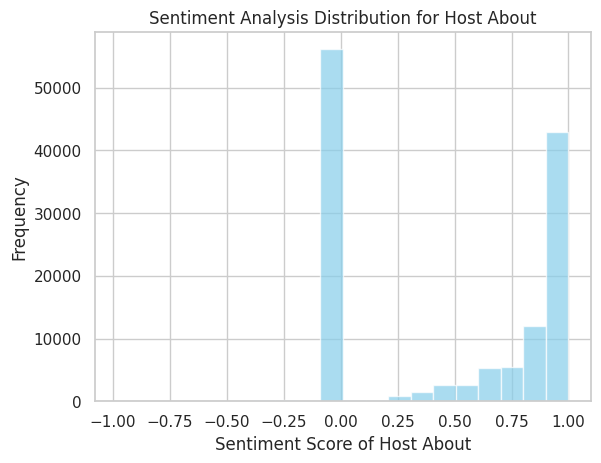

In [ ]:
# Define a sentiment analysis function
sid = SentimentIntensityAnalyzer()
calculate_sentiment_udf = udf(lambda text: sid.polarity_scores(text)['compound'], FloatType())

# Calculate sentiment score for the host about section
df = df.withColumn("host_about_sentiment", calculate_sentiment_udf(df['host_about']))

# Plot sentiment distribution for host about section
plt.hist(df.select('host_about_sentiment').rdd.flatMap(lambda x: x).collect(), bins=20, color='skyblue', alpha=0.7)
plt.xlabel('Sentiment Score of Host About')
plt.ylabel('Frequency')
plt.title('Sentiment Analysis Distribution for Host About')
plt.show()

**Neutral Sentiment Prevalence**: There is a high frequency of neutral sentiment scores but, that is due to the number of missing values we had (close to 49000) which we imputed as empty strings (" ") which gives a sentiment score of 0. It's also important to note that the null values could indeed represent the absence of host about meaning that most hosts are not inclined to write about themselves.

**Positive Sentiment is also Common**: There's a substantial number of hosts with positive sentiment scores, indicating that a good portion of hosts choose to present themselves positively which is expected.

**Absence of Negative scores**: There is also an absence of negative scores below 0 which is expected since the hosts want to present themselves as friendly.

## Sentiment Analysis for Summary & Description

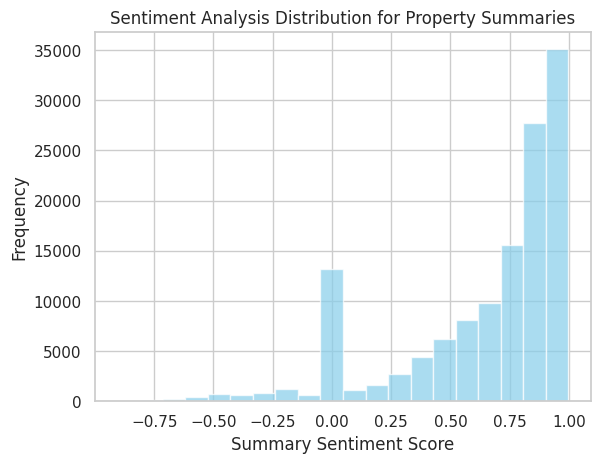

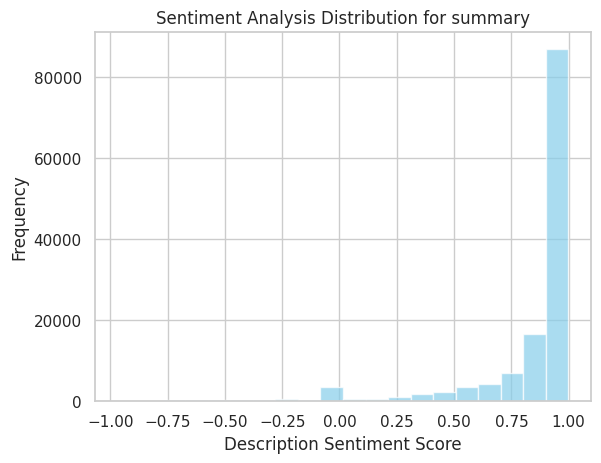

In [ ]:
# Calculate sentiment score for the summary
df = df.withColumn("summary_sentiment", calculate_sentiment_udf(df['summary']))

# Plot sentiment distribution for property summaries
plt.hist(df.select('summary_sentiment').rdd.flatMap(lambda x: x).collect(), bins=20, color='skyblue', alpha=0.7)
plt.xlabel('Summary Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Analysis Distribution for Property Summaries')
plt.show()

# Calculate sentiment score for the description
df = df.withColumn("description_sentiment", calculate_sentiment_udf(df['description']))

# Plot sentiment distribution for description
plt.hist(df.select('description_sentiment').rdd.flatMap(lambda x: x).collect(), bins=20, color='skyblue', alpha=0.7)
plt.xlabel('Description Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Analysis Distribution for summary')
plt.show()

**Strong Positive Sentiment**: The distribution of sentiment scores is heavily skewed toward the positive end, particularly with a large frequency of scores near 1. This indicates that the language used in property summaries is generally very positive.

**Few Negative Sentiments**: There are relatively few property summaries with negative sentiment scores reaching up to about -0.65. This could be for the same reasons as the previous sentiment analyses since host try to present their listing as positive as possible but this time there are at least some visible negative sentiment scores.

**Popular Neutral to Positive Sentiment**: There's a noticeable concentration of sentiment scores in the neutral 0 score, suggesting that while most summaries are positive, a considerable number are written in a more neutral tone, possibly to appear straightforward and trustworthy while it's also important to note that almsot 4.200 observations were null and were transformed to empty strings constributing to the zero sentiment score.

## Sentiment Analysis Distribution for House Rules

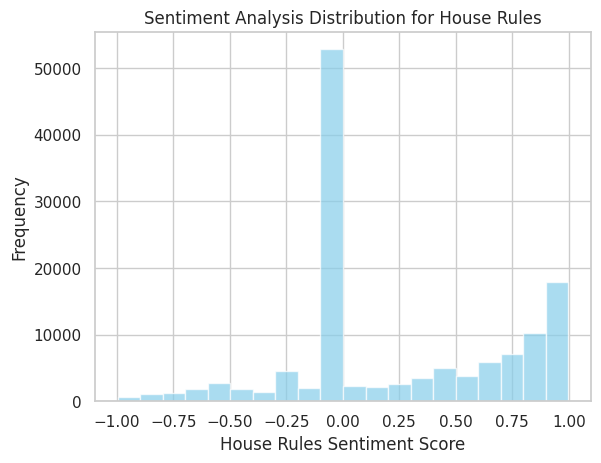

In [ ]:
# Calculate sentiment score for the house rules
df = df.withColumn("house_rules_sentiment", calculate_sentiment_udf(df['house_rules']))

# Plot sentiment distribution for house rules
plt.hist(df.select('house_rules_sentiment').rdd.flatMap(lambda x: x).collect(), bins=20, color='skyblue', alpha=0.7)
plt.xlabel('House Rules Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Analysis Distribution for House Rules')
plt.show()

**Neutral Sentiment Prevalence**: The highest frequency by far is for sentiment scores near 0 this could be again due to the transformation of null values to empty strings. Having close to 50.000 null values which results in a very high number of empty strings and thus observations with "0" sentiment score definetely influences this plot.

**Positive Sentiments**: There are some entries with positive sentiment scores. This might be because house rules typically outline what is not allowed without using negative sentiment.

**Negative Sentiments**: We can also observe plenty of negative sentiment score observations in this column and this is probably due to the strict language used by some hosts to outline the importance and that they forbid certain actions.

## Sentiment Analysis Distribution for Interaction

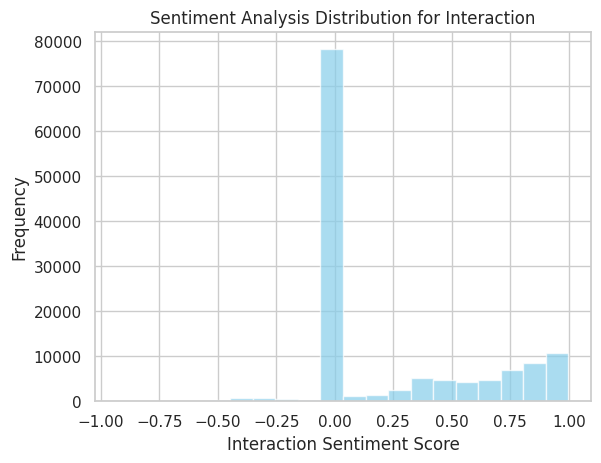

In [ ]:
# Calculate sentiment score for the interaction
df = df.withColumn("interaction_sentiment", calculate_sentiment_udf(df['interaction']))

# Plot sentiment distribution for interaction
plt.hist(df.select('interaction_sentiment').rdd.flatMap(lambda x: x).collect(), bins=20, color='skyblue', alpha=0.7)
plt.xlabel('Interaction Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Analysis Distribution for Interaction')
plt.show()

**Dominance of Neutral Sentiment**: The most common sentiment score is neutral (0), which is disproportionately high due to the treatment of missing data. This suggests that a significant portion of the interaction text is either neutral by nature or absent (45% missing values).

**Moderate Positive Sentiment**: The distribution has a moderate number of entries in the positive sentiment range, indicating that when interaction information is provided, it tends to have a positive tone.

**Negative Sentiment**: Negative sentiment scores are less common. This is probably because hosts prefer to convey a positive tone.

## Sentiment Analysis Distribution for Neighborhood Overview

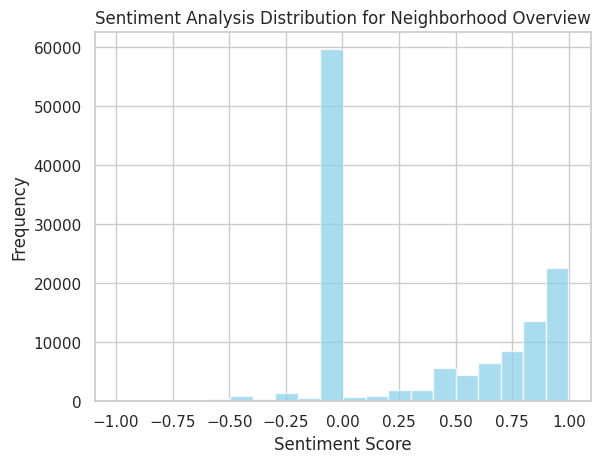

In [ ]:
# Calculate sentiment score for the neighborhood overview
df = df.withColumn("neighborhood_overview_sentiment", calculate_sentiment_udf(df['neighborhood_overview']))

# Plot sentiment distribution for neighborhood overview
plt.hist(df.select('neighborhood_overview_sentiment').rdd.flatMap(lambda x: x).collect(), bins=20, color='skyblue', alpha=0.7)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Analysis Distribution for Neighborhood Overview')
plt.show()

**Dominance of Neutral Sentiment**: Like the previous plot the most common sentiment score is neutral (0) which is due to the treatment of missing values as empty strings. About 50.000 of the observations were null values.

**Positive Sentiment**: The dominant positive sentiment score indicates that when the hosts decide to write a neighbourhood overview it tends in the majority to be positive.

**Negative Sentiment**: Negative sentiment scores are barely visible. This is probably because hosts prefer to present a positive neighbourhood overview or not proide one at all.

# Transit Column Analysis & Clustering

In [ ]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

# Define the regex tokenizer
tokenizer = RegexTokenizer(inputCol="transit", outputCol="words", pattern="\\W|\\b\\d+\\b")

# Define the stopwords remover
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

# Define the lemmatization function
def lemmatize(words):
    return [lemmatizer.lemmatize(word) for word in words]

# Define the lemmatization user defined function
lemmatize_udf = udf(lemmatize, ArrayType(StringType()))

# Apply lemmatization
lemmatized_df = stopwords_remover.transform(tokenizer.transform(df))
lemmatized_df = lemmatized_df.withColumn("lemmatized_words", lemmatize_udf(col("filtered_words")))

# Count vectorize the tokenized transit descriptions
vectorizer = CountVectorizer(inputCol="lemmatized_words", outputCol="rawFeatures")

# Apply TF-IDF to the count vectors
idf = IDF(inputCol="rawFeatures", outputCol="features_idf")

# Create a Pipeline
pipeline_prep = Pipeline(stages=[vectorizer, idf])

# Fit the pipeline to the DataFrame
pipeline_model = pipeline_prep.fit(lemmatized_df)

# Transform the DataFrame
df_transformed = pipeline_model.transform(lemmatized_df)

# Show the transformed DataFrame
df_transformed.select("transit", "features_idf").show(truncate=False)

[nltk_data] Downloading package wordnet to /root/nltk_data...


+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|transit                                                                                                                 

Text Clustering:
Cluster transit descriptions to group similar transit options together.
Use K-means clustering to group listings based on the type of transit options available.

In [ ]:
# Define K-means model
kmeans = KMeans(k=4, seed=1, featuresCol="features_idf", predictionCol="cluster")

# Fit the K-means model
kmeans_model = kmeans.fit(df_transformed)

# Get the cluster centers
cluster_centers = kmeans_model.clusterCenters()

# Show the most common words in each cluster
vocab = pipeline_model.stages[0].vocabulary
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i}:")
    indices = center.argsort()[-10:][::-1]
    print([vocab[index] for index in indices])
    print()



Cluster 0:
['bus', 'block', 'train', 'minute', 'away', 'walk', 'line', 'stop', 'uber', 'street']

Cluster 1:
['km', 'mile', 'theatre', 'comedy', 'studio', 'improv', 'bowl', 'knott', 'pantages', 'kodak']

Cluster 2:
['mile', 'min', 'drive', 'hollywood', 'minute', 'center', 'mi', 'beach', 'studio', 'la']

Cluster 3:
['minute', 'street', 'take', 'walk', 'line', 'train', 'station', 'bus', 'block', 'away']



Based on the clustering results:

**Cluster 0:** Words like 'bus', 'block', 'minute', 'away', 'line', 'train', 'uber', 'walk', 'stop', 'street' suggest that this cluster primarily includes listings where public transportation (especially buses and trains) is readily accessible, along with options like Uber.

**Cluster 1:** Terms such as 'minute', 'mile', 'downtown', 'bus', 'street', 'line', 'parking', 'car', 'station' imply a mix of urban accessibility, likely where personal vehicles and bus lines are common, possibly with mentions of proximity to downtown areas.

**Cluster 2:** Featuring 'train', 'manhattan', 'subway', 'min', 'walk', 'brooklyn', 'square', 'stop', 'take', this cluster seems to focus on listings in New York (mentioning Manhattan and Brooklyn), highlighting accessibility to trains and subways.

**Cluster 3:** Dominated by 'mi', 'min', 'drive', 'pulaski', 'line', 'international', 'mindistance', 'accurate', 'field', 'ca', indicating listings possibly near airports ('international', 'field') and require driving ('drive', 'mi' for miles).

We decided to not convert the transit column to the four categories that we got from the above clustering results.

## Transit-based Listing Recommendation System

In order to enhance user experience and facilitate easier access to desired amenities, we implemented a transit-based listing recommendation system. This system allows users to specify their transit preferences, and based on their input, the system recommends the top 10 listings that best match their criteria.

For example, if a user prefers a listing with access to bus transit, they simply input "bus" as their query. Similarly, if they prefer a listing near an airport, they input "near airport" as their query. The system then analyzes the listings and returns the top 10 most similar listings to the user's query, making the search process more efficient and tailored to individual preferences.

In [ ]:
# Pre-processing Steps
# Create a user-defined stemmer for the dataset
def stemming(x):
  import nltk
  ps = nltk.PorterStemmer()
  return [str(ps.stem(w)) for w in x]

stemming_udf = udf(stemming, ArrayType(StringType()))

# Tokenizer based on REGEX
tokenizer = RegexTokenizer()
tokenizer.setPattern("[\\W_]+") # pattern="\\W|\\b\\d+\\b"
tokenizer.setMinTokenLength(4)
tokenizer.setInputCol("transit")
tokenizer.setOutputCol("tokens_")

# Remove Stopwords
remover_stopwords = StopWordsRemover()
remover_stopwords.setInputCol("tokens")
remover_stopwords.setOutputCol("words")

# Calculate term frequency
#Preprocessing of Corpus
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=10000)

# Calculate the inverse document frequency
idf = IDF(inputCol="rawFeatures", outputCol="features_hash")

In [ ]:
# preprocess the dataset for tokenizer and stemming
corpus_df = tokenizer.transform(df)
corpus_df = corpus_df.withColumn("tokens", stemming_udf(col("tokens_")))
# Add stopwords removers, TF and TF-IDF pipeline
pipeline = Pipeline(stages = [remover_stopwords, hashingTF, idf])
# Create the pipeline object and perform the transformation and create tf-idf dataframe
pipeline_obj = pipeline.fit(corpus_df)
tfidfData = pipeline_obj.transform(corpus_df).cache()

In [ ]:
# Number of Results
k = 10

# Input Query
query = 'bus'

# Transform the input query
input_df = spark.createDataFrame([(query,)], ["transit"])
input_df = tokenizer.transform(input_df)
input_df = input_df.withColumn("tokens", stemming_udf(col("tokens_")))
input_df = pipeline_obj.transform(input_df)
question = input_df[["features_hash"]]

# Question
translated_question = question.collect()[0]["features_hash"]

In [ ]:
# disseminate the query via broadcast variable
broadcastVar = spark.sparkContext.broadcast(translated_question)

# Define a UDF to calculate dot product similarity
def dot_product_similarity(a):
    return float(a.dot(broadcastVar.value))


similarity_udf = udf(dot_product_similarity, DoubleType())


# Compute similarity and sort by similarity
result_df = tfidfData.withColumn('similarity', similarity_udf(col("features_hash")))
result_df = result_df.sort(result_df.similarity.desc())

final_results = result_df.limit(k).select("name", "transit").toPandas()
broadcastVar.destroy()

In [ ]:
print(final_results)

                                                name  \
0                                West Hills CA house   
1                                     Bed for night-   
2                                Shared room-(Bed 2)   
3                 Cozy House in Hollywood 1-6 guests   
4                      Hollywood Posh 1b1b + Parking   
5                2 bdr/2bth Hollywood Hills Hideaway   
6                 Charming Bedroom for your NY stay!   
7                   Hollywood Private Room Twin Beds   
8  Cozy Heart of Hollywood Home Sleeps 8 rooftop ...   
9                      SunSet - Vine Craftsman House   

                                             transit  
0                                                     
1  Nearest subway is woodheavan (URL HIDDEN)  loc...  
2  7-10 minutes by walk to the Flushing Meadow-Co...  
3  LA = Traffic. No getting around it. We take th...  
4  Metro and bus station is few minutes away from...  
5  Close to bus and train. Walk to the shops and ... 

We can change every time the query and we can find each time their relevant listings. For instance the query could be: "train","taxi".

# Text Column Analyis
Moving forward, we will apply pre-processing methods to our text columns. It is important to notice that some of our text columns contain non-English languages. After performing research, we discovered that this has little effect on the pre-processing processes as the majority of them are universal and work regardless of the the language of the text, with no noticeable differences.

The preprocessing includes tokenization, stop word removal, lemmatization, and TF-IDF transformation. It begins by tokenizing the text using regular expressions, removing stop words, and then lemmatizing the words using NLTK's WordNet Lemmatizer. After preprocessing, it counts the occurrence of each word and applies TF-IDF transformation. Finally, it uses PySpark's Pipeline to automate the process and iterates through specified text columns in a DataFrame, applying the preprocessing steps to each column.

In [ ]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, StringType
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def preprocess_text_column(df, column):
    # Define the regex tokenizer
    tokenizer = RegexTokenizer(inputCol=column, outputCol=column+"_words", pattern="\\W|\\b\\d+\\b")

    # Define the stopwords remover
    stopwords_remover = StopWordsRemover(inputCol=column+"_words", outputCol=column+"_filtered_words")

    # Define the lemmatization function
    def lemmatize(words):
        return [lemmatizer.lemmatize(word) for word in words]

    # Define the lemmatization user-defined function
    lemmatize_udf = udf(lemmatize, ArrayType(StringType()))

    # Apply lemmatization
    lemmatized_df = stopwords_remover.transform(tokenizer.transform(df))
    lemmatized_df = lemmatized_df.withColumn(column+"_lemmatized_words", lemmatize_udf(col(column+"_filtered_words")))

    # Count vectorize the tokenized transit descriptions
    vectorizer = CountVectorizer(inputCol=column+"_lemmatized_words", outputCol=column+"_rawFeatures")

    # Apply TF-IDF to the count vectors
    idf = IDF(inputCol=column+"_rawFeatures", outputCol=column+"_features_idf")

    # Create a Pipeline
    pipeline_prep = Pipeline(stages=[vectorizer, idf])

    # Fit the pipeline to the DataFrame
    pipeline_model = pipeline_prep.fit(lemmatized_df)

    # Transform the DataFrame
    df_transformed = pipeline_model.transform(lemmatized_df)

    return df_transformed

# Define the list of text columns
text_columns = ["access", "host_about", "description", "house_rules", "summary", "transit", "interaction", "notes", "space",'neighborhood_overview']

# Apply preprocessing to each text column
for column in tqdm(text_columns):
    df = preprocess_text_column(df, column)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 10/10 [10:33<00:00, 63.37s/it]


## Sentiment Analysis on pre-processed text columns

Now we will investage the seniment scores of the pre-processed text columns and create also their sentiment's scores plots.

This function assigns a sentiment score (1 for positive, -1 for negative, and 0 for neutral) to each text. Next, a User Defined Function (UDF) is created to apply the sentiment analysis function to the text columns in the DataFrame. Finally, sentiment analysis is applied to each text column, and new sentiment columns are added to the DataFrame, representing the sentiment class for each text.


In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

# Load VADER
sia = SentimentIntensityAnalyzer()

# Define a function to perform sentiment analysis using VADER
def get_sentiment_vader(text):
    text = " ".join(text)
    score = sia.polarity_scores(text)
    compound_score = score['compound']
    if compound_score > 0:
        return 1  # Positive sentiment
    elif compound_score < 0:
        return -1  # Negative sentiment
    else:
        return 0  # Neutral sentiment

# Define a UDF for sentiment analysis
sentiment_udf = udf(get_sentiment_vader, IntegerType())

# Apply sentiment analysis to all text columns
for column in text_columns:
    df = df.withColumn(column+"_sentiment", sentiment_udf(column+"_lemmatized_words"))

# Show the dataframe with the new sentiment columns
for column in text_columns:
    df.select(column+"_sentiment").distinct().show(truncate=False)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


+----------------+
|access_sentiment|
+----------------+
|-1              |
|1               |
|0               |
+----------------+

+--------------------+
|host_about_sentiment|
+--------------------+
|-1                  |
|1                   |
|0                   |
+--------------------+

+---------------------+
|description_sentiment|
+---------------------+
|-1                   |
|1                    |
|0                    |
+---------------------+

+---------------------+
|house_rules_sentiment|
+---------------------+
|-1                   |
|1                    |
|0                    |
+---------------------+

+-----------------+
|summary_sentiment|
+-----------------+
|-1               |
|1                |
|0                |
+-----------------+

+-----------------+
|transit_sentiment|
+-----------------+
|-1               |
|1                |
|0                |
+-----------------+

+---------------------+
|interaction_sentiment|
+---------------------+
|-1         

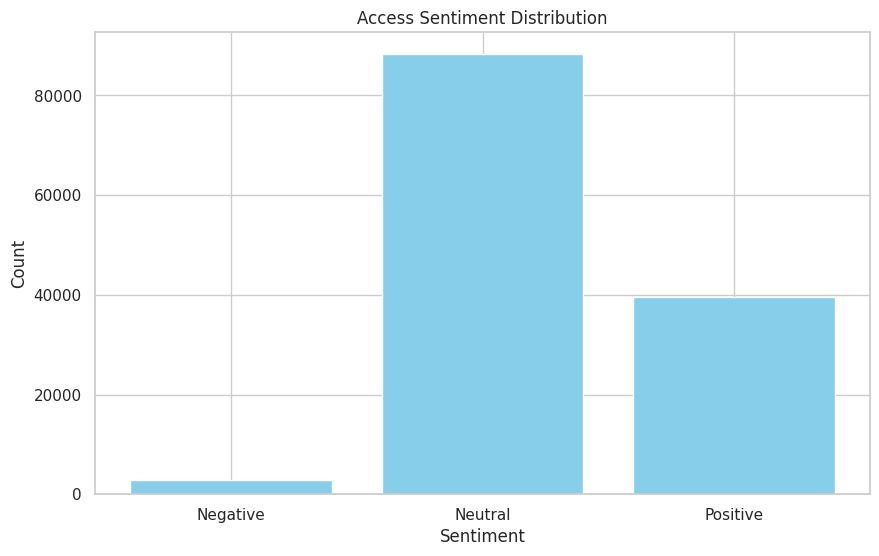

<Figure size 1000x600 with 0 Axes>

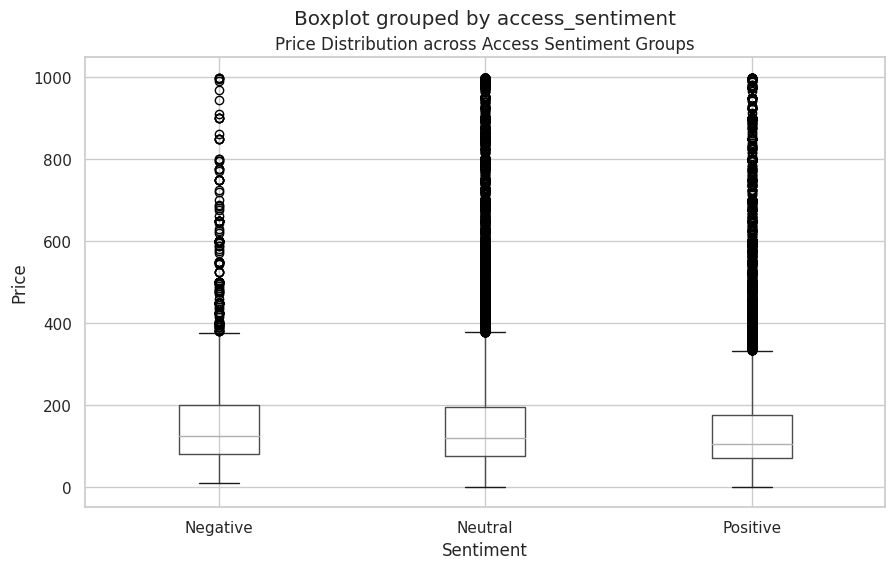

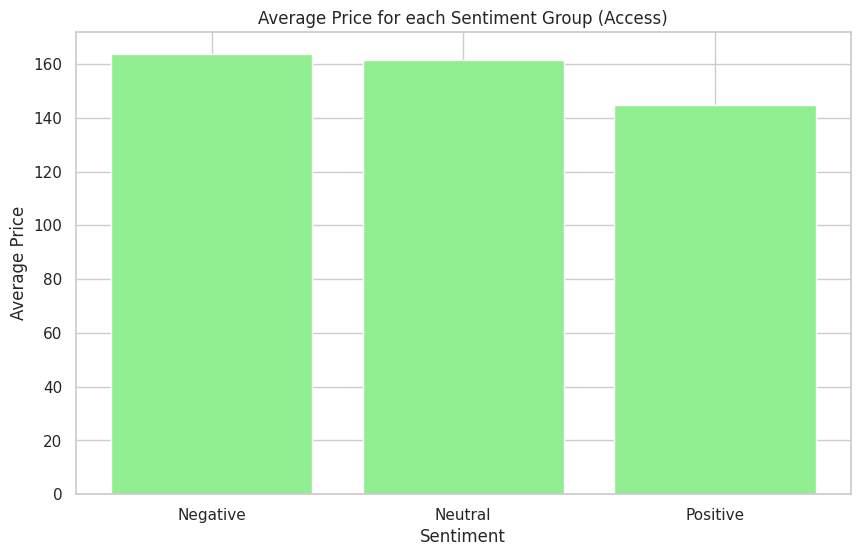

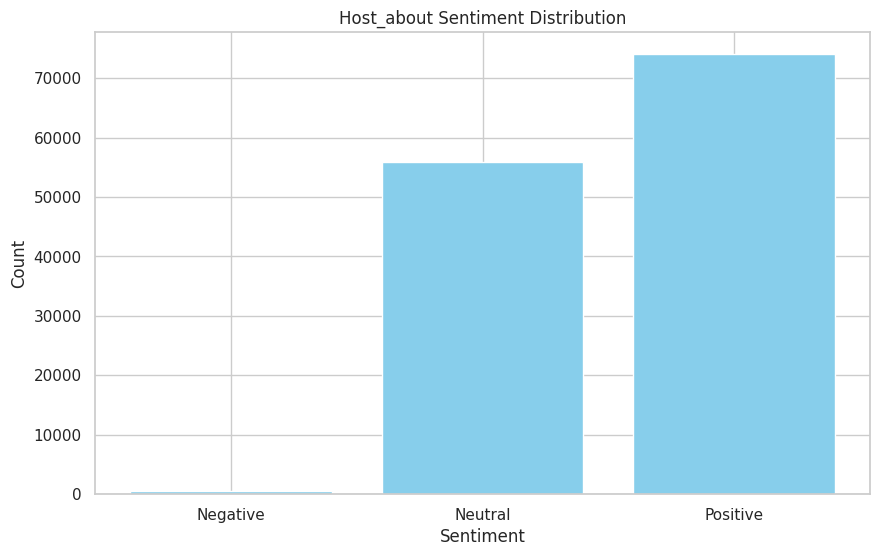

<Figure size 1000x600 with 0 Axes>

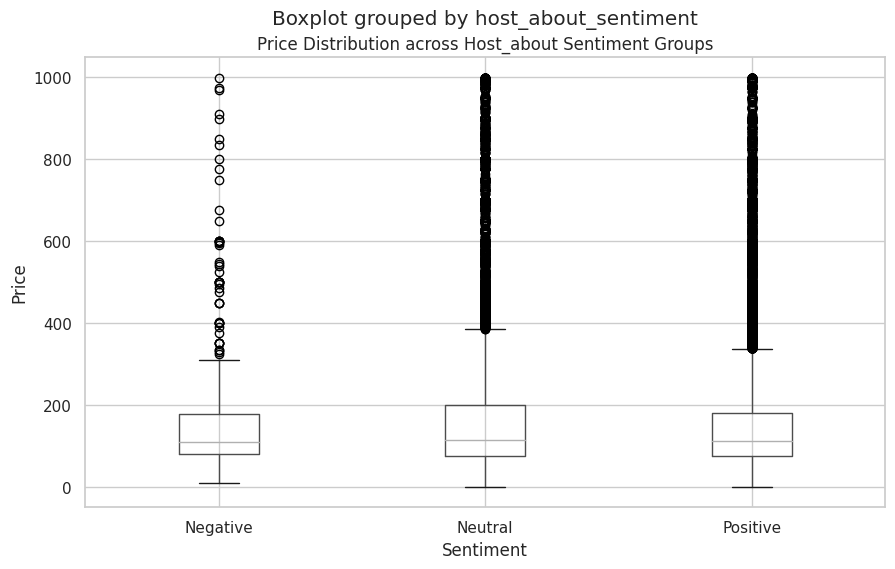

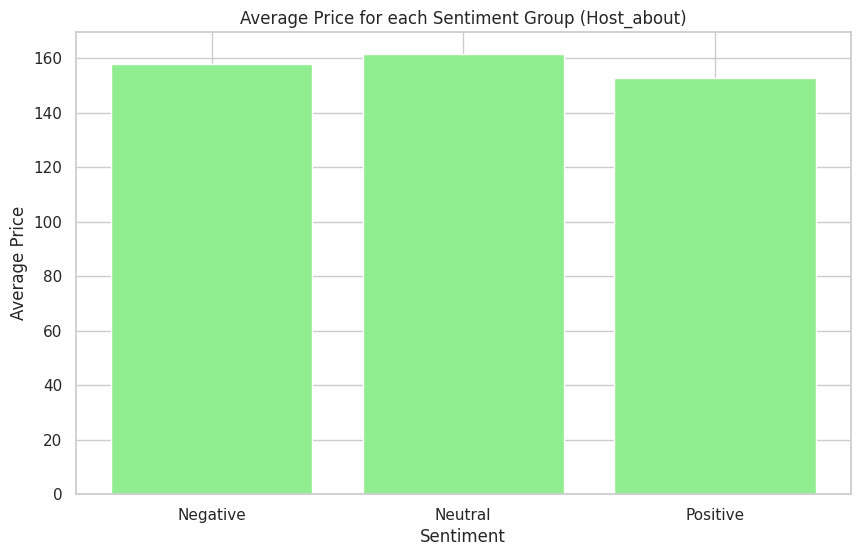

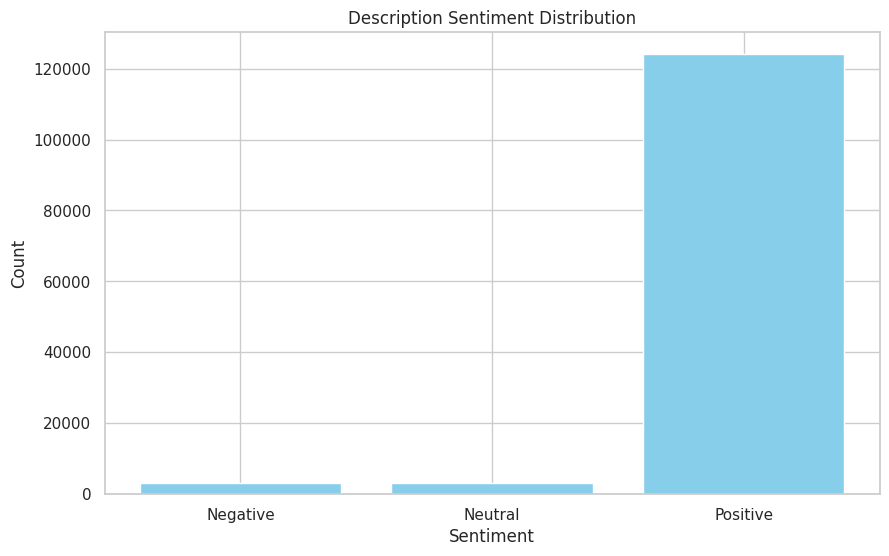

<Figure size 1000x600 with 0 Axes>

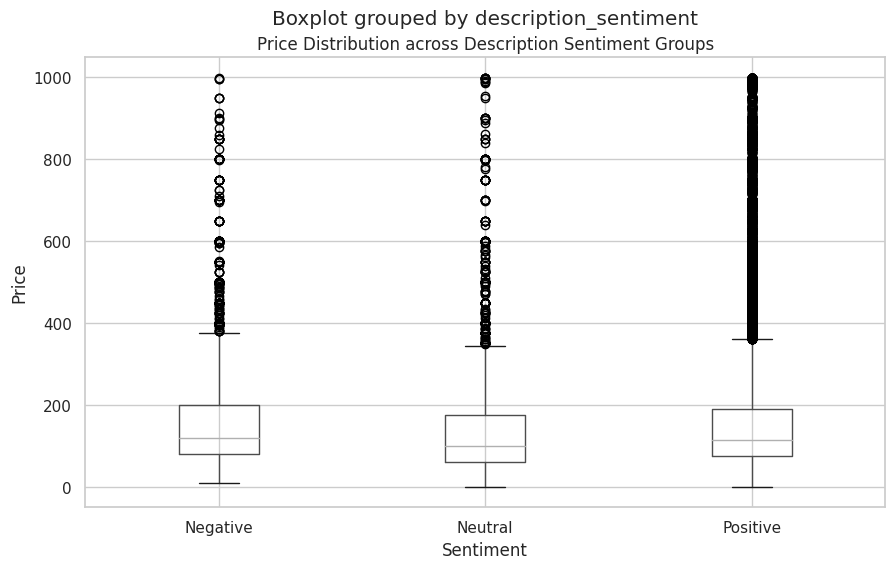

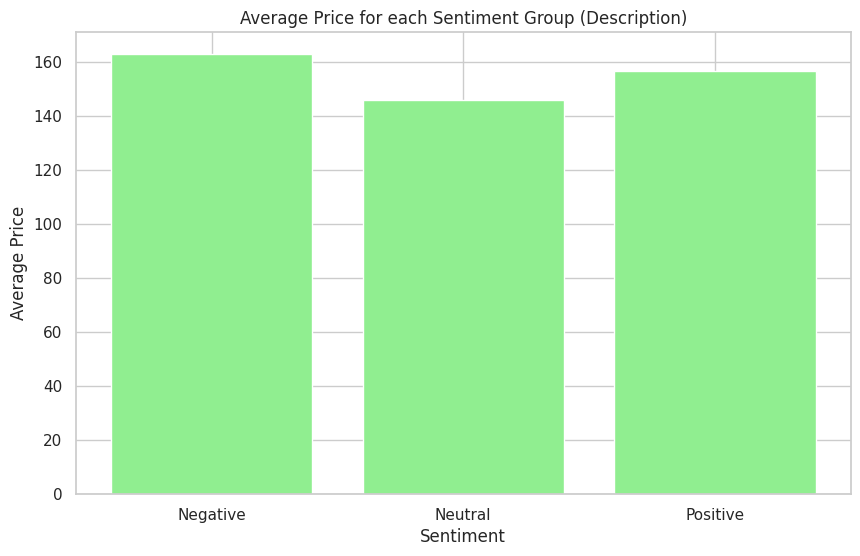

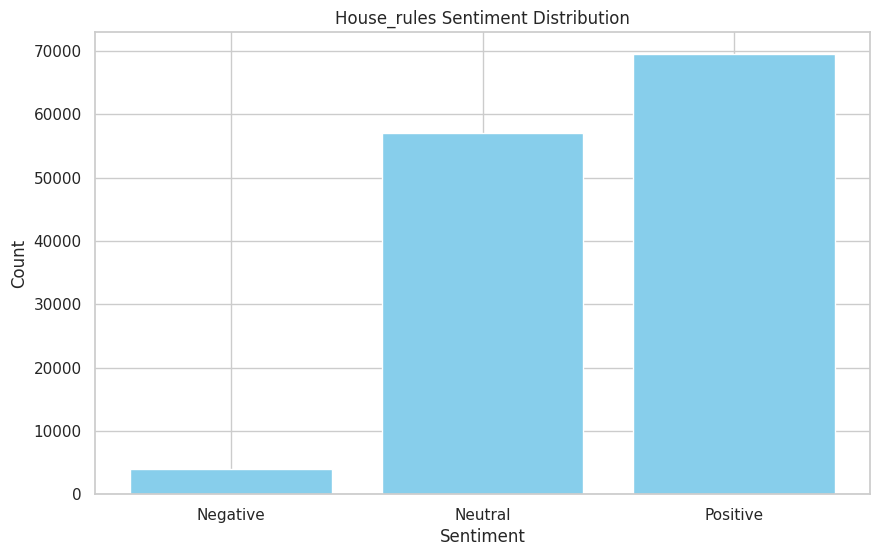

<Figure size 1000x600 with 0 Axes>

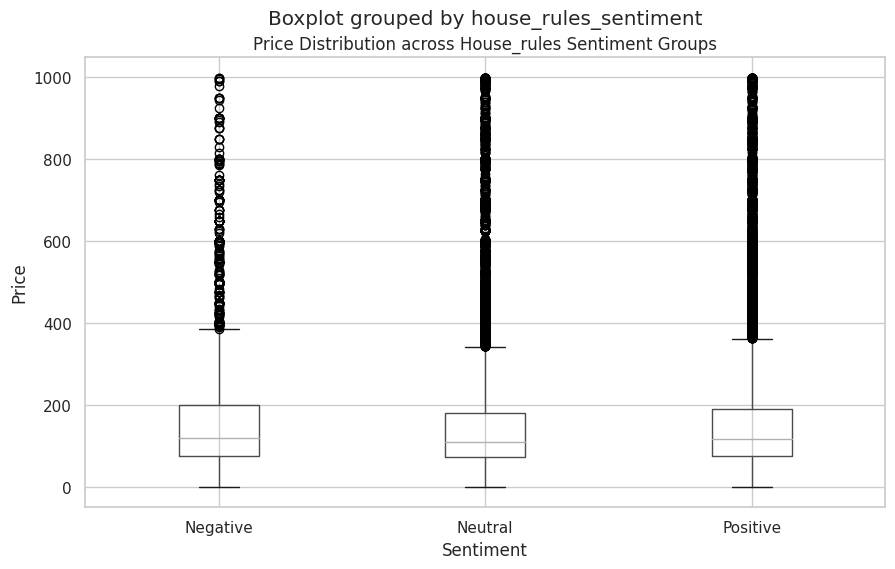

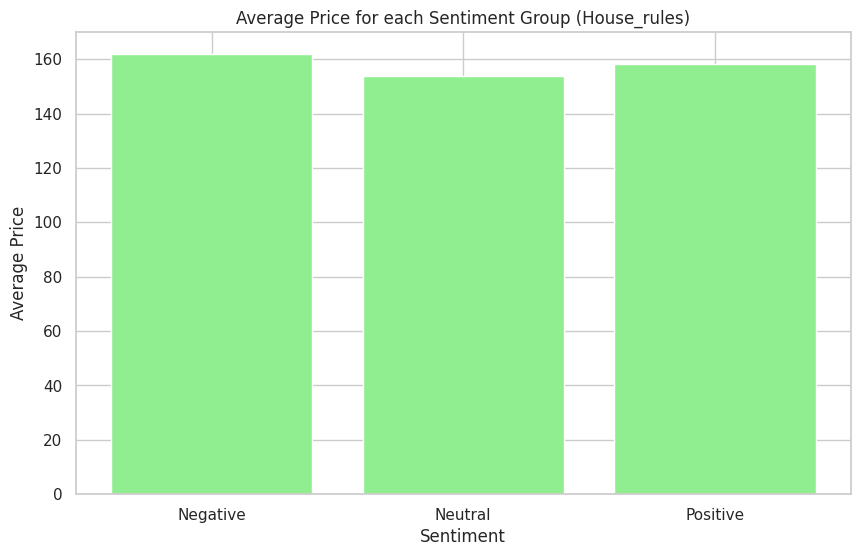

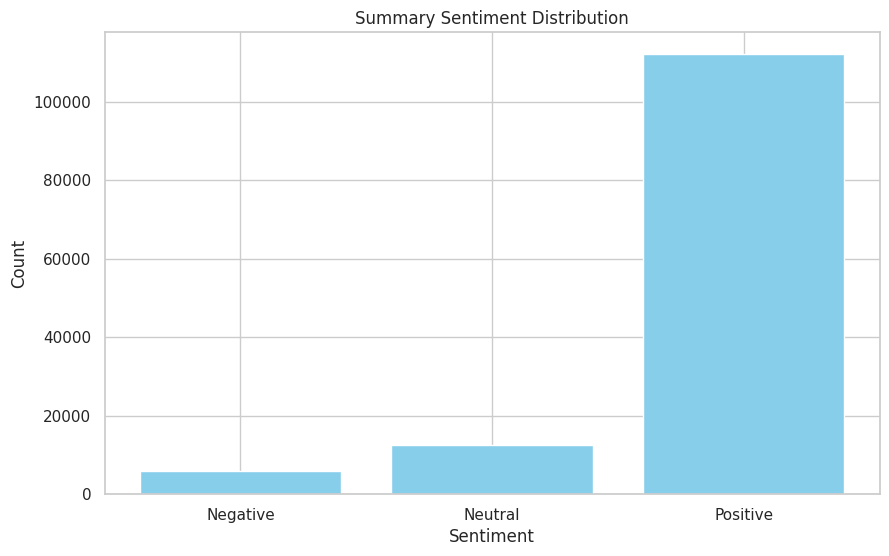

<Figure size 1000x600 with 0 Axes>

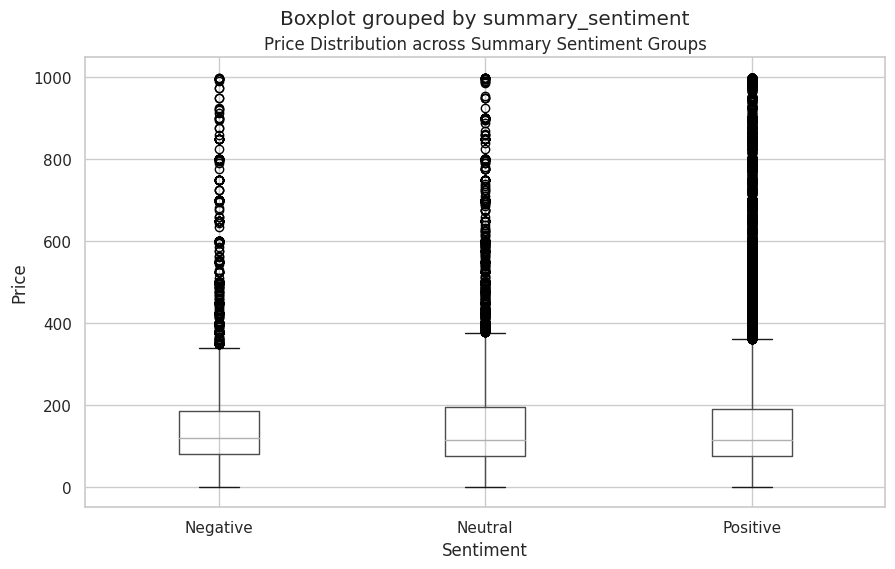

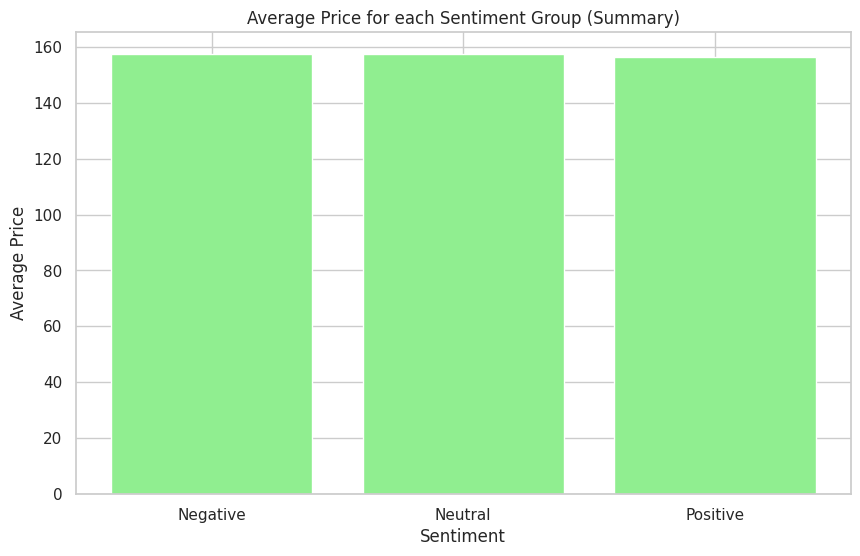

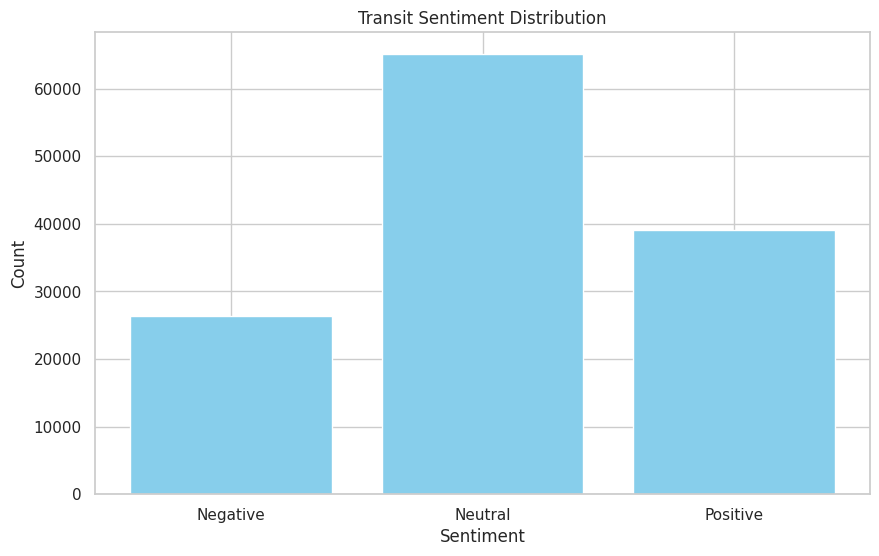

<Figure size 1000x600 with 0 Axes>

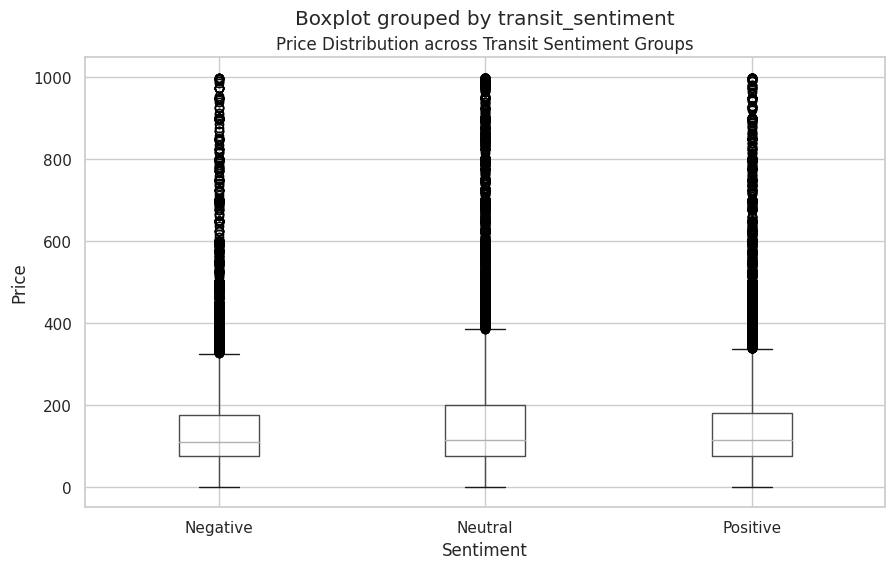

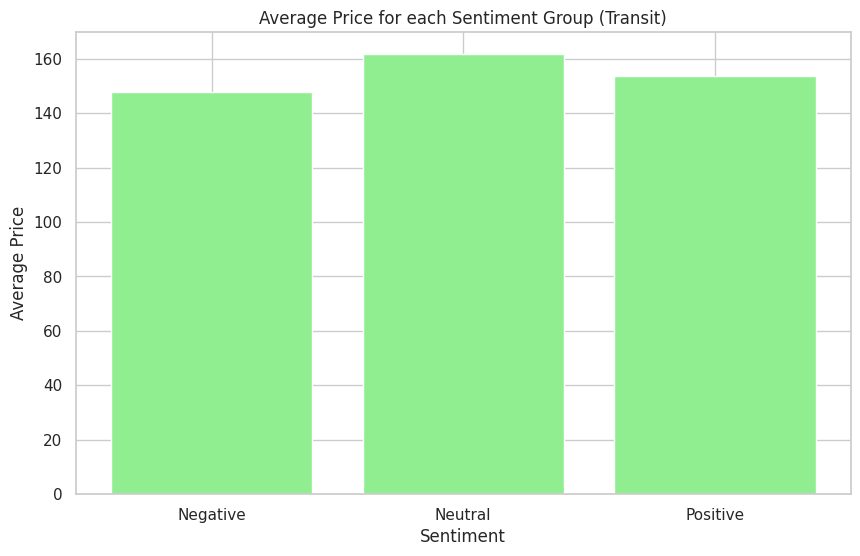

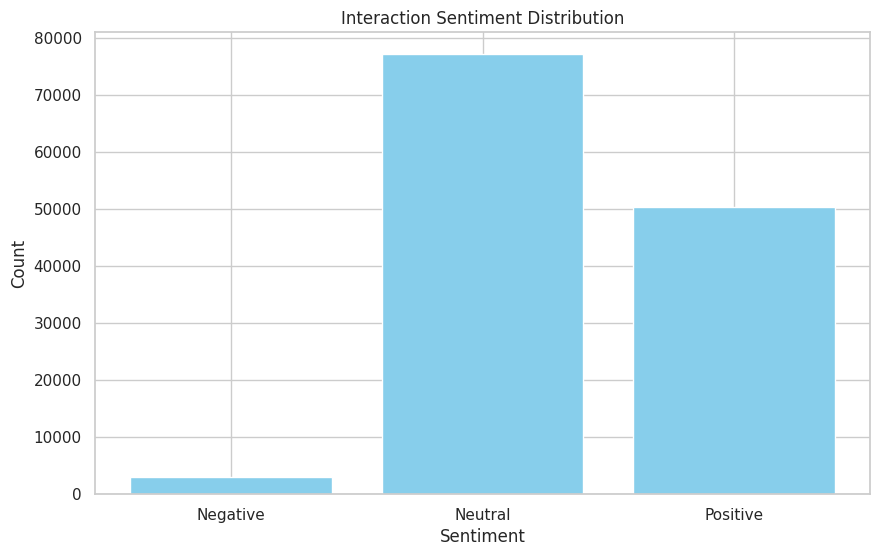

<Figure size 1000x600 with 0 Axes>

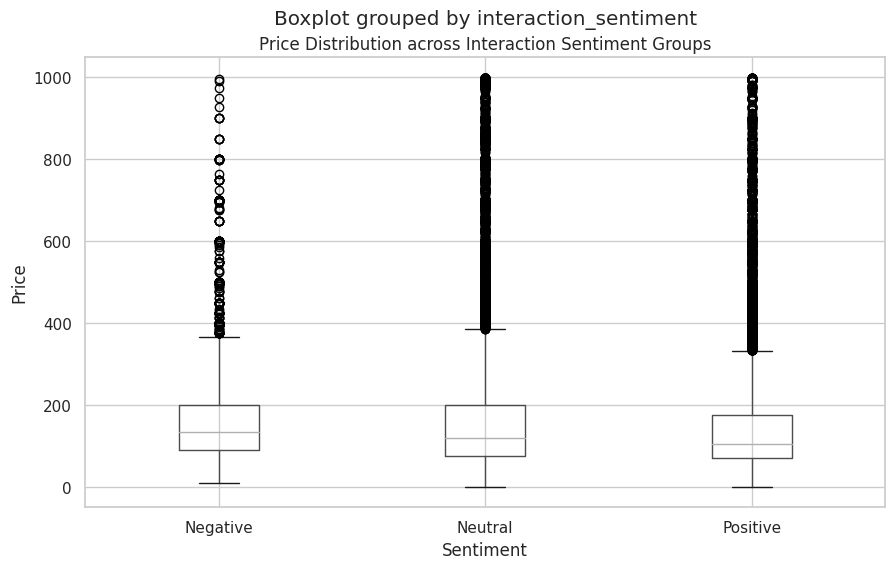

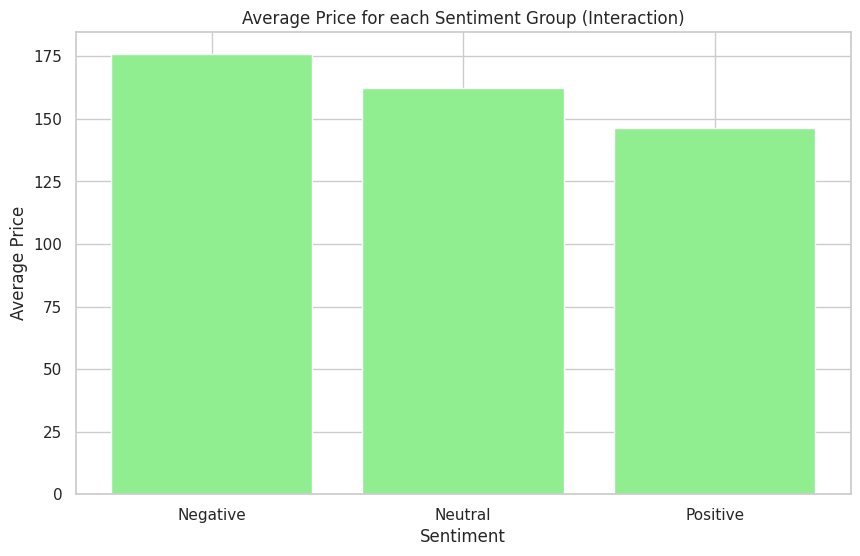

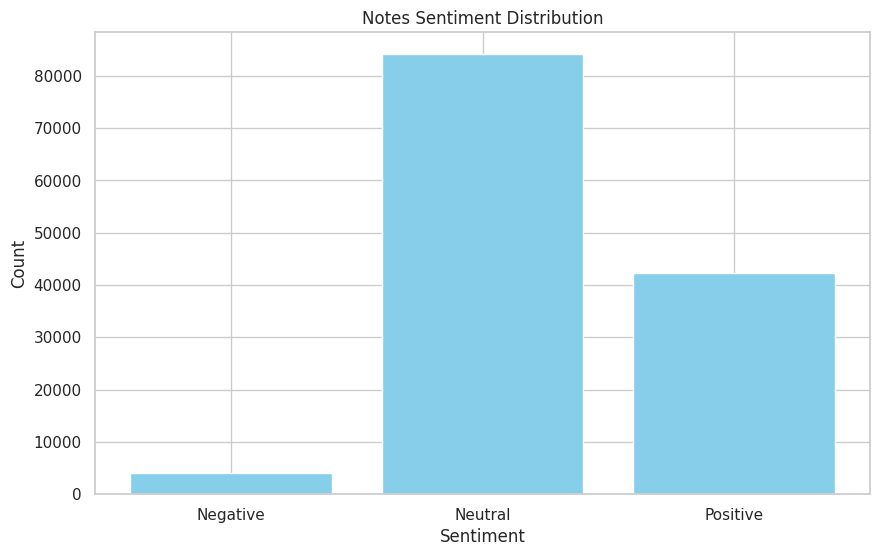

<Figure size 1000x600 with 0 Axes>

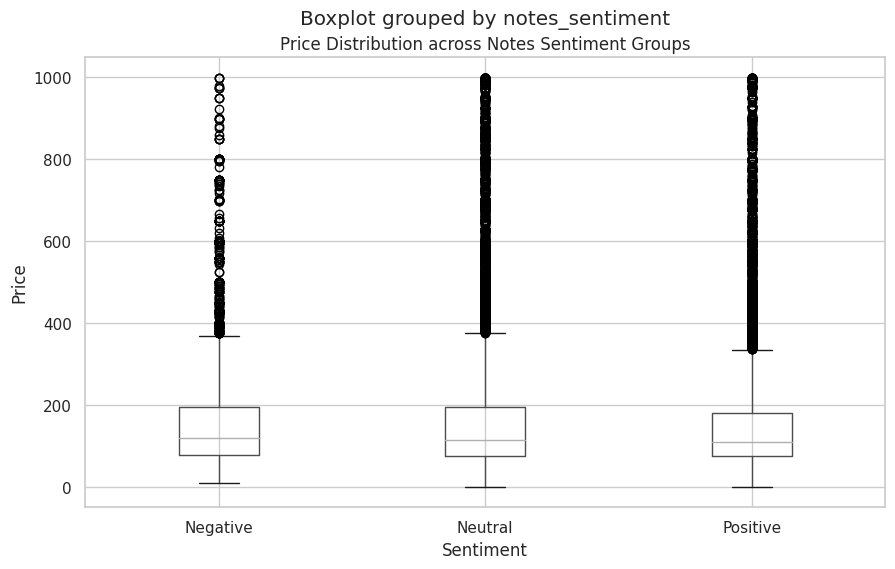

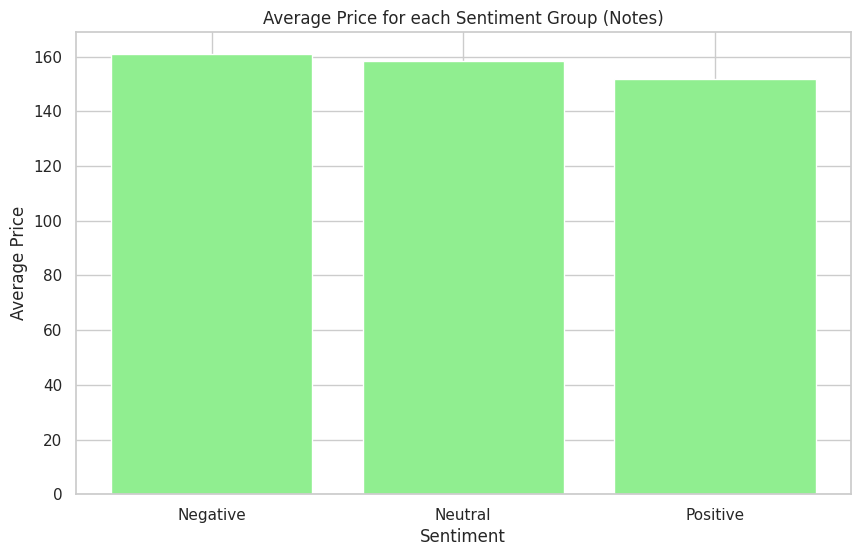

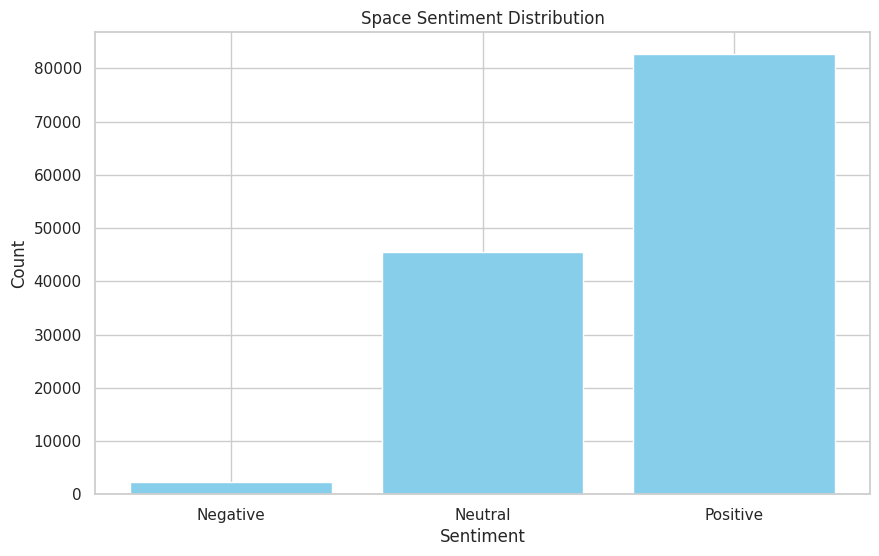

<Figure size 1000x600 with 0 Axes>

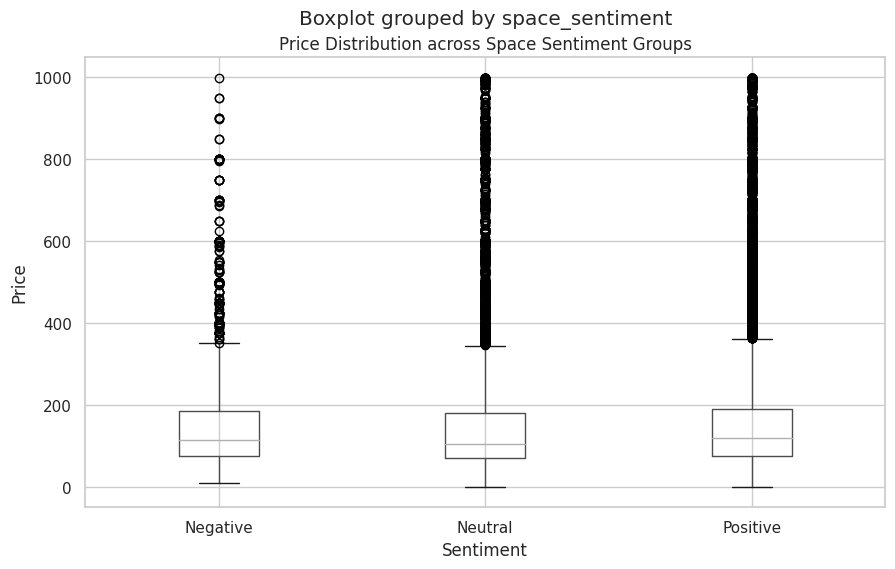

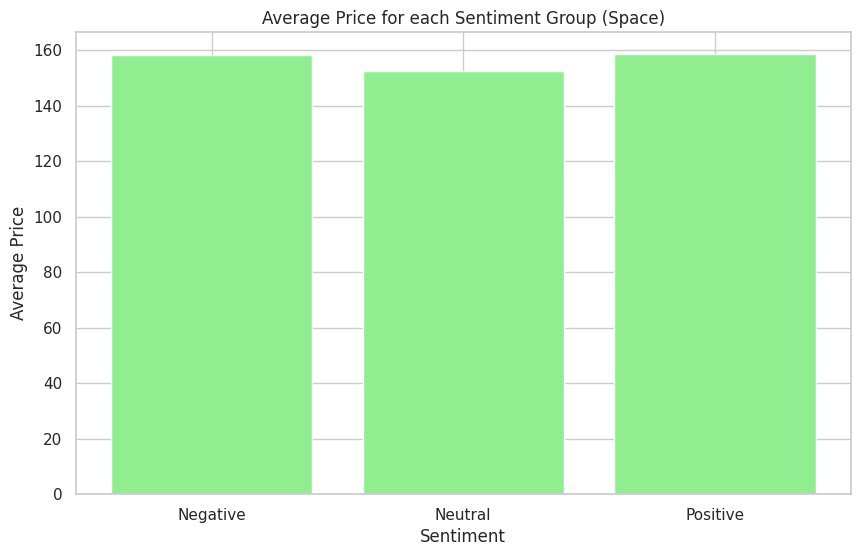

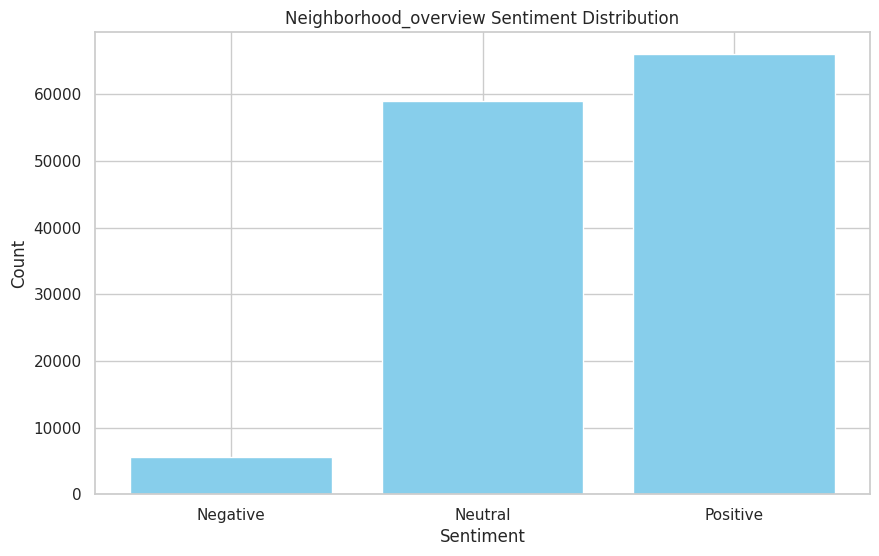

<Figure size 1000x600 with 0 Axes>

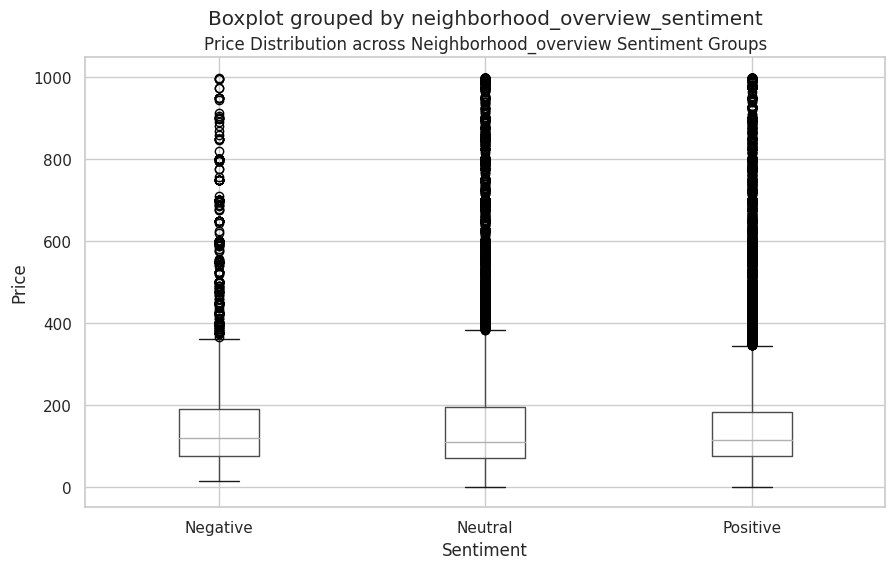

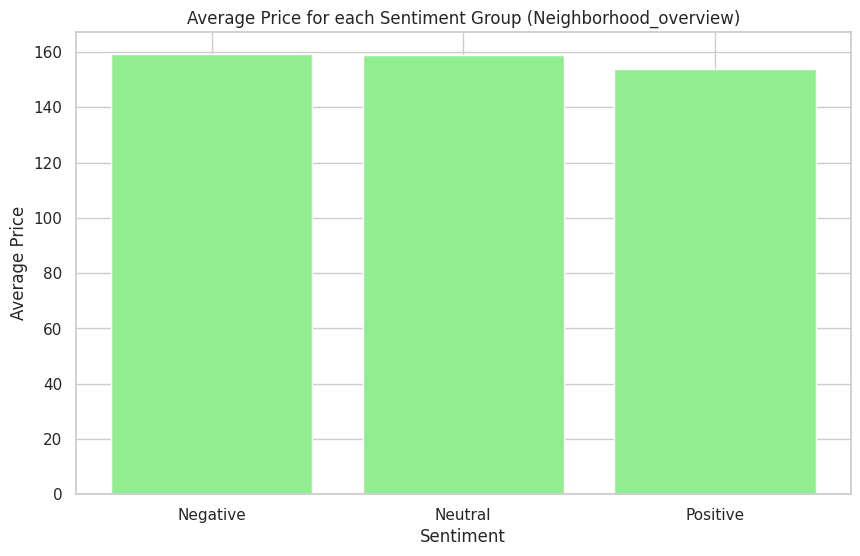

In [ ]:
# Sentiment distribution and Price distribution across different sentiment groups for each text column
for column in text_columns:
    # Sentiment distribution
    sentiment_distribution = df.groupBy(column+"_sentiment").count().collect()

    sentiments = [row[column+"_sentiment"] for row in sentiment_distribution]
    counts = [row["count"] for row in sentiment_distribution]

    plt.figure(figsize=(10, 6))
    plt.bar(sentiments, counts, color='skyblue')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.title(f'{column.capitalize()} Sentiment Distribution')
    plt.xticks([-1, 0, 1], ['Negative', 'Neutral', 'Positive'])
    plt.show()

    # Price distribution across different sentiment groups
    plt.figure(figsize=(10, 6))
    df.select(column+"_sentiment", "price").toPandas().boxplot(by=column+"_sentiment", figsize=(10, 6))
    plt.title(f'Price Distribution across {column.capitalize()} Sentiment Groups')
    plt.xlabel('Sentiment')
    plt.ylabel('Price')
    plt.xticks([1, 2, 3], ['Negative', 'Neutral', 'Positive'])
    plt.show()

    # Average price for each sentiment group
    average_price_df = df.groupBy(column+"_sentiment").avg("price").collect()

    sentiments = [row[column+"_sentiment"] for row in average_price_df]
    average_prices = [row["avg(price)"] for row in average_price_df]

    plt.figure(figsize=(10, 6))
    plt.bar(sentiments, average_prices, color='lightgreen')
    plt.xlabel('Sentiment')
    plt.ylabel('Average Price')
    plt.title(f'Average Price for each Sentiment Group ({column.capitalize()})')
    plt.xticks([-1, 0, 1], ['Negative', 'Neutral', 'Positive'])
    plt.show()

**Observations:**

**Count Bar Plots:**
Across all text columns, the count of observations in the negative sentiment group is lower compared to the neutral and positive sentiment groups.

**Box Plots:**
The median prices across all three sentiment categories are similar. This suggests that regardless of the sentiment group, the price does not significantly vary. Thus, it appears that the sentiment of the text columns does not influence the target variable, as shown by the plots.

**Average Price Bar Plots:**
For most text columns, the bar plots showing the average price across sentiment groups have similar heights, indicating that the sentiment groups of text columns do not significantly affect the price. However, there are some exceptions:
In the "access" column, the average price of the negative sentiment group is slightly higher compared to the other groups, followed by a decrease. However, this observation is not conclusive because the median prices across all sentiment groups are similar, and the counts of each group are different.
Similar observations can be made for the "interaction" column.

In the "description" column, the neutral sentiment group has a lower average price compared to the other two groups, while the average prices of the positive and negative sentiment groups are very similar. The same pattern is observed for the "house_rules" column, albeit with a smaller difference. However, similar to the previous cases, the median prices across all sentiment groups are comparable, and the counts of each group vary. Hence, it is difficult to draw firm conclusions based solely on the average price bar plots.

In [ ]:
# Dropping the columns we dont need
columns_to_drop = [
    'access_words', 'access_filtered_words', 'access_lemmatized_words', 'access_rawFeatures',
    'host_about_words', 'host_about_filtered_words', 'host_about_lemmatized_words', 'host_about_rawFeatures',
    'description_words', 'description_filtered_words', 'description_lemmatized_words', 'description_rawFeatures',
    'house_rules_words', 'house_rules_filtered_words', 'house_rules_lemmatized_words', 'house_rules_rawFeatures',
    'summary_words', 'summary_filtered_words', 'summary_lemmatized_words', 'summary_rawFeatures',
    'transit_words', 'transit_filtered_words', 'transit_lemmatized_words', 'transit_rawFeatures',
    'interaction_words', 'interaction_filtered_words', 'interaction_lemmatized_words', 'interaction_rawFeatures',
    'notes_words', 'notes_filtered_words', 'notes_lemmatized_words', 'notes_rawFeatures',
    'space_words', 'space_filtered_words', 'space_lemmatized_words', 'space_rawFeatures',
    'neighborhood_overview_words', 'neighborhood_overview_filtered_words', 'neighborhood_overview_lemmatized_words', 'neighborhood_overview_rawFeatures'
]

df = df.drop(*columns_to_drop)

# Since we have transformed the text columns to tf-idf we will proceed and drop the old ones since we won't need them in further

df = df.drop("access", "description", "host_about", "house_rules", "interaction", "neighborhood_overview", "neighbourhood", "notes", "space", "street", "summary", "transit")

# Correlation Matrices

Moving forward we will plot the correlation matrices.

In [ ]:
sampled_df = df.sample(False, 0.2, seed=123)

numerical_columns = [
    "accommodates", "availability_30", "availability_365", "availability_60", "availability_90",
    "cleaning_fee", "extra_people", "guests_included", "host_listings_count",
    "latitude", "longitude", "maximum_nights", "minimum_nights",
    "monthly_price", "number_of_reviews", "price", "reviews_per_month",
    "security_deposit", "weekly_price", "host_years_since_joined", "bathrooms",
    "bedrooms", "beds", "host_response_rate", "total_review_scores", "host_id"
]

# Select only the numerical columns from the sampled DataFrame
sampled_numerical_df = sampled_df.select(numerical_columns)

pandas_df = sampled_numerical_df.toPandas()

correlation_matrix = pandas_df.corr()

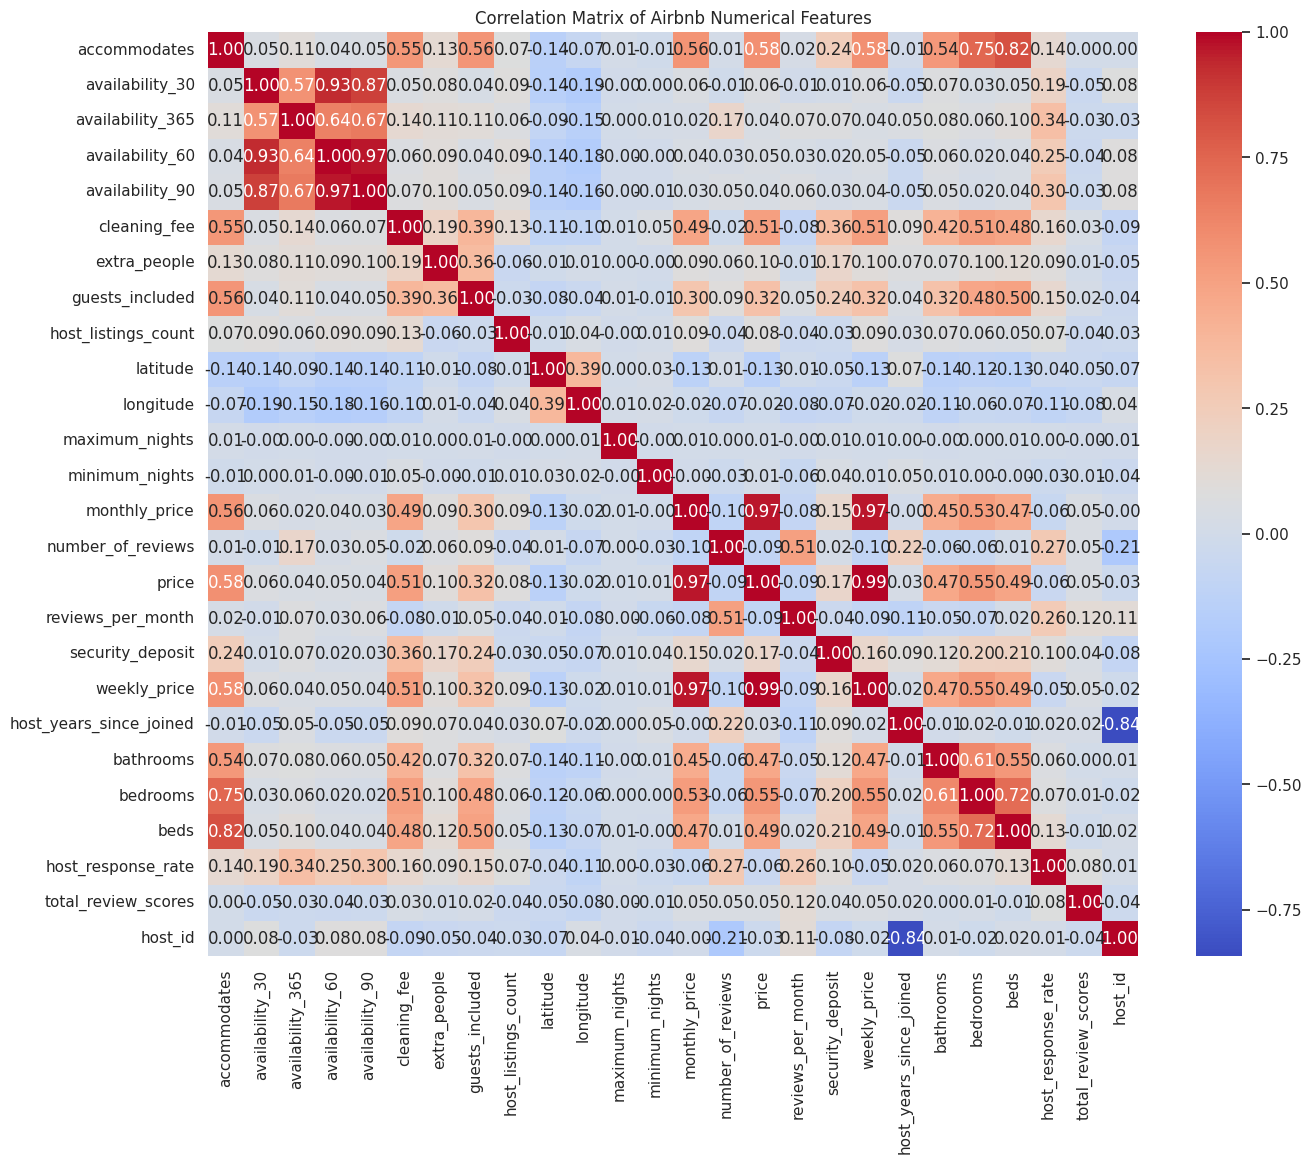

In [ ]:
# Heatmap of the correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Airbnb Numerical Features")
plt.show()

**High Correlation between Availability Variables**: There's a high correlation among availability_30, availability_60, availability_90, and availability_365. This is expected as they represent the availability of a listing over different time frames, so they are related.

**Price-Related Features Correlation**: The price has a high correlation with cleaning_fee, weekly_price, and monthly_price, suggesting that these are not independent in terms of how they contribute to the cost of a listing.

**Accommodates and Guest-Related Features**: The accommodates feature has strong correlations with guests_included and cleaning_fee, indicating that properties that can accommodate more people tend to include more guests in the base price and charge more for extra people and for cleaning fee due to extra people.

**Geographical Coordinates**: There is no correlation between latitude/longitude and other features, suggesting that the location coordinates themselves don’t have a linear relationship with the other numerical features.

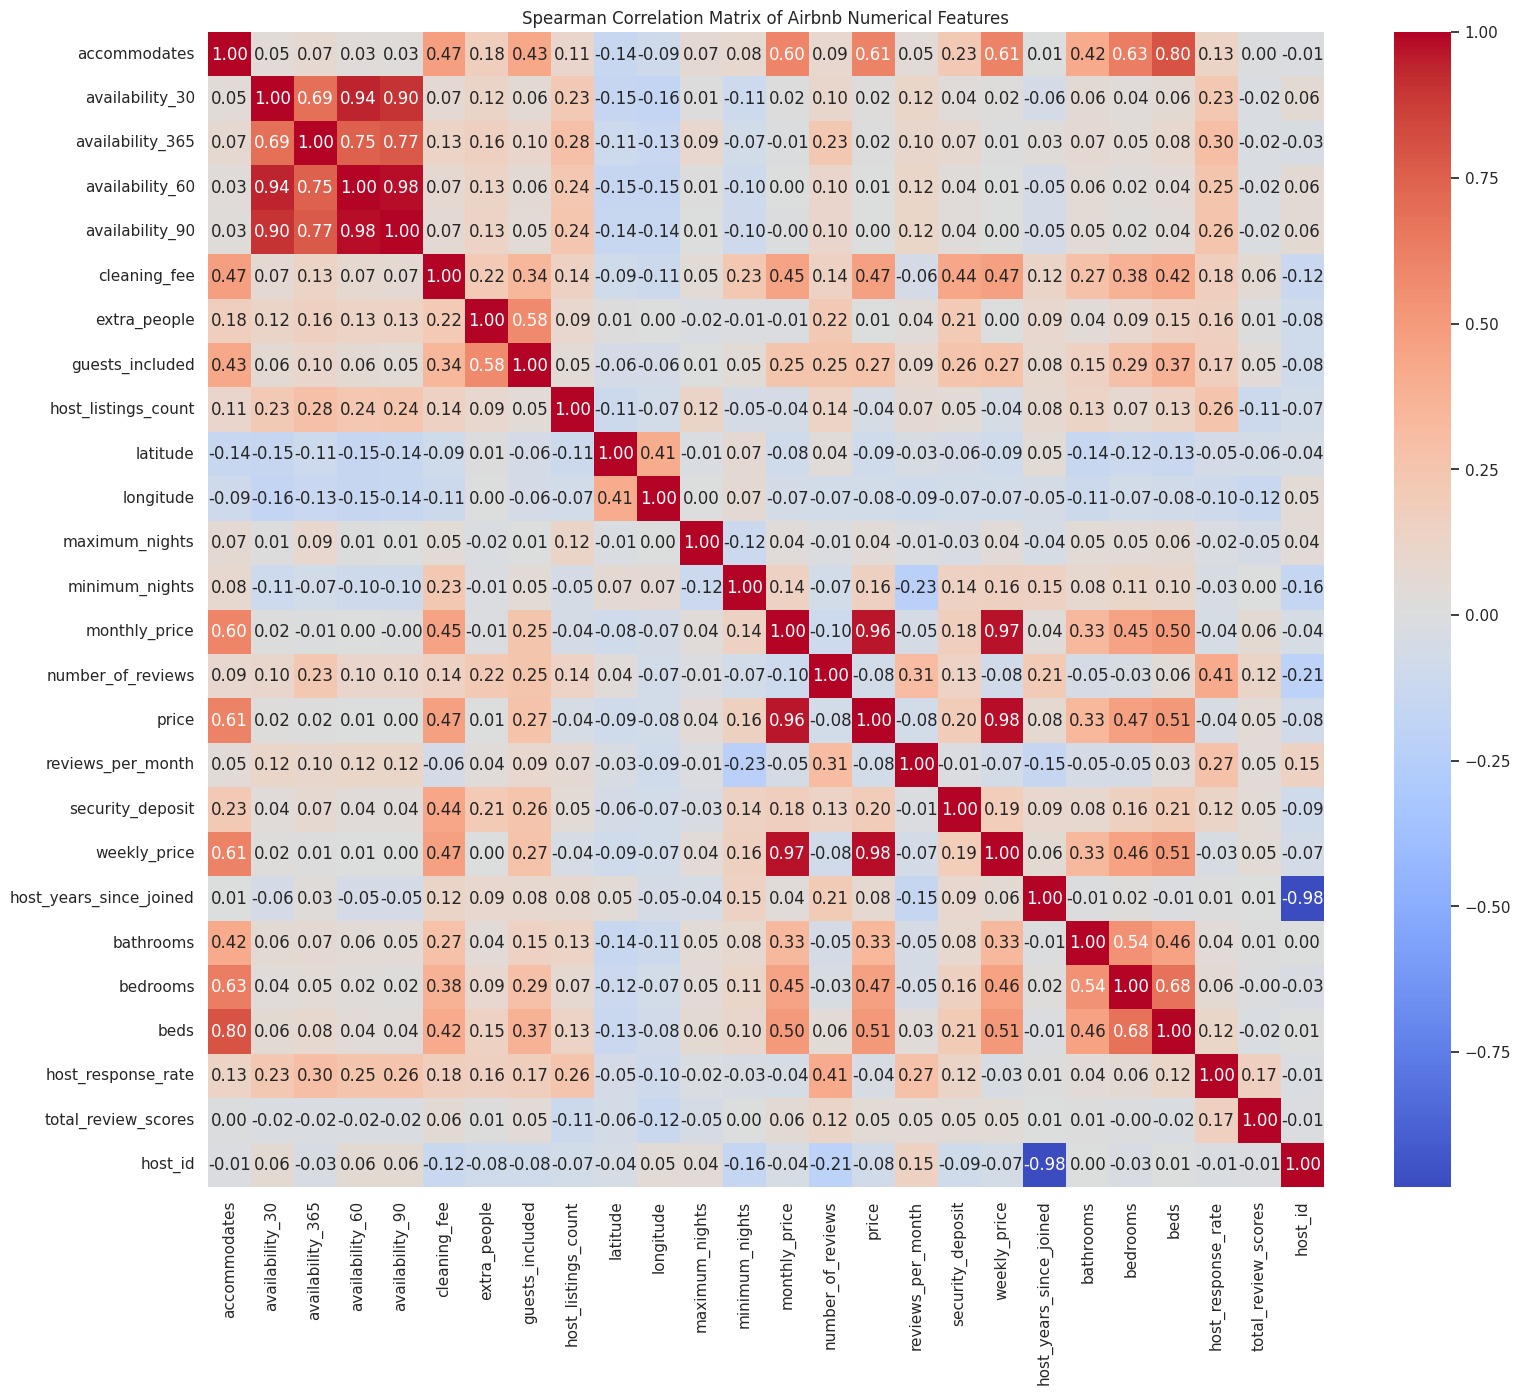

In [ ]:
spearman_corr_matrix = pandas_df.corr(method='spearman')

# To visualize this as a heatmap
plt.figure(figsize=(18, 15))
sns.heatmap(spearman_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Spearman Correlation Matrix of Airbnb Numerical Features")
plt.show()

From the Spearman correlation matrix, we observe exceptionally high correlations between both weekly_price and monthly_price with the target variable price, with correlation coefficients exceeding 0.97. This high correlation is expected since "monthly_price" and "weekly_price" are generally calculated by multiplying the daily price (price) by the number of days, often without any significant discounts. Therefore, to avoid multicolinearity we have decided to exclude weekly_price and monthly_price from our dataset, retaining only the daily price.

Additionally, for the same reason of multicolinearity we also remove the "accommodates" attribute due to its strong correlation with "beds". This decision is based on reducing the overlap of information provided by closely related features, which can distort the performance and outcomes of our predictive models.

Furthermore, the host_id column will be dropped because it shows a very high negative correlation of -0.98 with host_years_since_joined. This indicates that the information provided by host_id is largely redundant with respect to the years a host has been active.

In [ ]:
df = df.drop("weekly_price", "monthly_price", "host_id", "accommodates")

# PCA for availability column

As mentioned before, to deal with the high correlation of the availability columns we will perform dimensionality reduction using PCA. The result of these will be a new variable named availability_feature which will combine the information that availability_30", "availability_60", "availability_90", and  "availability_365" columns have.

In [ ]:
assembler = VectorAssembler(
    inputCols=["availability_30", "availability_60", "availability_90", "availability_365"],
    outputCol="availability_feature"
)

# Transform the data
transformed = assembler.transform(df)

# PCA to reduce dimensions
pca = PCA(k=1, inputCol="availability_feature", outputCol="Availability_pca")
model = pca.fit(transformed)
df = model.transform(transformed)

# Drop the columns after the pca
df = df.drop("availability_30", "availability_60", "availability_90", "availability_365", "availability_feature")

# Final DataFrame with PCA applied
df.select("Availability_pca").show()

+--------------------+
|    Availability_pca|
+--------------------+
|[-380.0717720409953]|
|[-326.83598673946...|
|[-304.75420884154...|
|               [0.0]|
|[-380.0717720409953]|
|[-183.3010053096216]|
|[-148.8143304069742]|
|[-158.59195716168...|
|[-137.15129711838...|
|               [0.0]|
|[-339.1480927072922]|
|[-380.0717720409953]|
|               [0.0]|
|               [0.0]|
|[-110.66524667596...|
|               [0.0]|
|[-99.01500942524586]|
|[-380.0717720409953]|
|               [0.0]|
|[-377.48283042972...|
+--------------------+
only showing top 20 rows



# Feature Importance

In [ ]:
# print schema to ensure data types
df.printSchema()

root
 |-- city: string (nullable = true)
 |-- amenities: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- bathrooms: double (nullable = true)
 |-- bed_type: string (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- beds: long (nullable = true)
 |-- cancellation_policy: string (nullable = true)
 |-- cleaning_fee: long (nullable = true)
 |-- extra_people: long (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- guests_included: long (nullable = true)
 |-- host_listings_count: long (nullable = true)
 |-- host_response_rate: long (nullable = true)
 |-- host_response_time: string (nullable = true)
 |-- host_total_listings_count: long (nullable = true)
 |-- host_verifications: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- maximum_nights: long (nullable =

In [ ]:
# Convert latitude, longitude and zipcode to DoubleType
df = df.withColumn("latitude", col("latitude").cast(DoubleType())) \
       .withColumn("longitude", col("longitude").cast(DoubleType()))\
       .withColumn("zipcode", col("zipcode").cast("double"))

By performing a count of null and nan for the zipcode column, we can notice that by transforming the column in doubletype, 26 null values are created and this is potentially due to some values of zip code being non numerical ones to deal with this. Since it's only 26 values we will drop these rows.

In [ ]:
df.filter((col("zipcode").isNull()) | (isnan(col("zipcode")))).count()

26

In [ ]:
# Ensuring the data has no null
df = df.filter(F.col("zipcode").isNotNull())

We select the categorical and the numerical features while we opt out of selecting the text columns since they are very sparse vectors having 30.000-50.000 unique words. This will add a lot of complexicity to the model while also making the computation and the runtime slower. Furthermore, in the stage of the exploratory analysis we didn't see any text column influencing the price variable.

In [ ]:
# Making a new Dataframe with categorical and numerical features
df3 = df.select("bathrooms", "bedrooms", "beds", "cleaning_fee", "extra_people",\
                  "guests_included", "host_listings_count", "host_response_rate","id", "name", "total_review_scores",\
                  "host_total_listings_count", "latitude", "longitude", "maximum_nights",\
                  "minimum_nights", "number_of_reviews", "reviews_per_month",\
                  "security_deposit", "host_years_since_joined", "total_review_scores", "zipcode",\
                "state_id", "room_type", "property_type", "host_response_time",\
                    "cancellation_policy", "bed_type", "city", "amenities", "host_verifications", "features", "price")

In [ ]:
# Indexing categorical columns and exploding array-type columns
categorical_cols = ["state_id", "room_type", "property_type", "host_response_time",
                    "cancellation_policy", "bed_type", "city"]

array_cols = ["amenities", "host_verifications", "features"]

# Define StringIndexers for all categorical columns
indexers = [StringIndexer(inputCol=c, outputCol=c + "_indexed") for c in categorical_cols]

# Explode array columns separately and index them
df_exploded = df3
for array_col in array_cols:
    # Explode the array into separate rows
    df_exploded = df_exploded.withColumn(array_col + "_item", explode(col(array_col)))

    # Create and fit a StringIndexer for the exploded array items
    indexer = StringIndexer(inputCol=array_col + "_item", outputCol=array_col + "_indexed")
    df_exploded = indexer.fit(df_exploded).transform(df_exploded)

    # Drop the original array column and the intermediate item column
    df_exploded = df_exploded.drop(array_col, array_col + "_item")

# Assemble numerical features directly without indexing
numerical_cols = ["bathrooms", "bedrooms", "beds", "cleaning_fee", "extra_people",
                  "guests_included", "host_listings_count", "host_response_rate",
                  "host_total_listings_count", "latitude", "longitude", "maximum_nights",
                  "minimum_nights", "number_of_reviews", "reviews_per_month",
                  "security_deposit", "host_years_since_joined", "total_review_scores", "zipcode"]
assembler_numerical = VectorAssembler(inputCols=numerical_cols, outputCol="features_numerical")

# Combine indexers and assemblers in one pipeline
pipeline_stages = indexers + [assembler_numerical]
pipeline = Pipeline(stages=pipeline_stages)
df_prepared = pipeline.fit(df_exploded).transform(df_exploded)

# Assemble all features
assembler_all = VectorAssembler(
    inputCols=[c + "_indexed" for c in categorical_cols + array_cols] + ["features_numerical"],
    outputCol="features_all"
    )

df_final = assembler_all.transform(df_prepared)

# Select the features and label for model fitting
final_df = df_final.select("features_all", "price")

In [ ]:
# Define and fit the RandomForest
rf = RandomForestRegressor(featuresCol="features_all", labelCol="price", maxBins=300)
model_combined = rf.fit(final_df)

# Getting feature importance score
importances_combined = model_combined.featureImportances

# Mapping feature names to their importances
feature_names_combined = [c + "_indexed" for c in categorical_cols + array_cols] + numerical_cols
importance_dict_combined = {feature_names_combined[i]: importances_combined[i] for i in range(len(feature_names_combined))}

# Print the values of feature importance
print("Feature Importances:")
for name, importance in importance_dict_combined.items():
    print(f"{name}: {importance}")

Feature Importances:
state_id_indexed: 0.005475511614095961
room_type_indexed: 0.10566675117126191
property_type_indexed: 0.00409722192397823
host_response_time_indexed: 0.0008079065879790405
cancellation_policy_indexed: 0.0
bed_type_indexed: 0.0
city_indexed: 0.060729024379516626
amenities_indexed: 0.0
host_verifications_indexed: 0.0
features_indexed: 0.0
bathrooms: 0.14374901621585975
bedrooms: 0.27016382300553005
beds: 0.11019992073362288
cleaning_fee: 0.2589762589869369
extra_people: 0.0025336249514387264
guests_included: 0.007511204598623563
host_listings_count: 0.0002702551893792626
host_response_rate: 0.0022960762121882936
host_total_listings_count: 0.00039332834912297253
latitude: 0.0003256243898266404
longitude: 0.0004635773898942477
maximum_nights: 0.0001699774079906347
minimum_nights: 0.0025597130726074265
number_of_reviews: 0.009180196966409869
reviews_per_month: 0.005838216362044342
security_deposit: 0.0028015619572723726
host_years_since_joined: 2.592164466182962e-05
tota

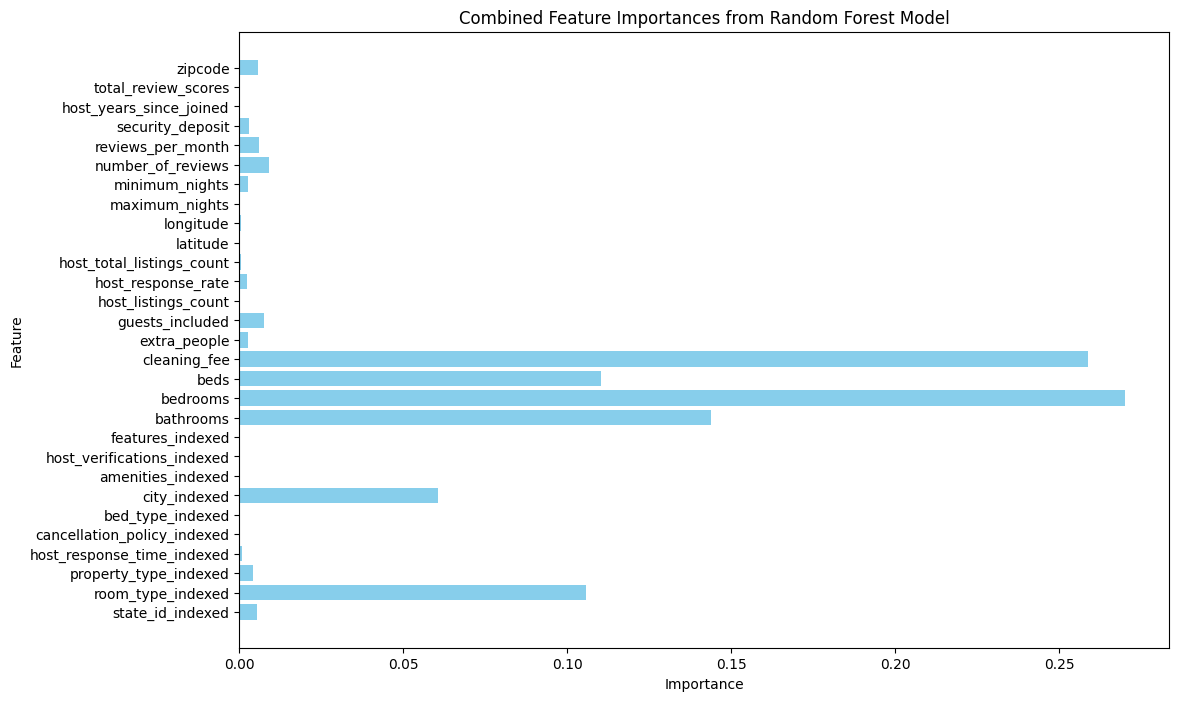

In [ ]:
# Visualize feature importances
labels = list(importance_dict_combined.keys())
values = list(importance_dict_combined.values())

# Create a bar plot for feature importances
plt.figure(figsize=(12, 8))
plt.barh(labels, values, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Combined Feature Importances from Random Forest Model')
plt.show()

The feature importance plot distinctly highlights that the cleaning_fee holds the most significant weight, contributing over 30% to the model's decision-making process. This underscores the critical impact of cleaning fees on the pricing of a listing. Following closely, the number of bedrooms and bathrooms also play crucial roles, reflecting substantial influences on price determination.

On a lower tier of importance yet notably impactful, room_type and city_indexed emerge as significant determinants, along with the number_of_reviews, which indicates a nuanced interplay between property type, location, and customer interactions in price setting.

Conversely, features like state_id, zipcode, and guests_included register lesser importance. Although they contribute less to the pricing model, they are recognized as significant factors, providing valuable insights into regional trends and the scale of accommodation. This nuanced understanding assists in tailoring strategies that address diverse market dynamics and customer preferences.

After obtaining the feature importance scores, we noticed that the three array-type features 'amenities', 'host_verifications', and 'features' were not considered significant. To optimize computational efficiency during model implementation, we decided to rerun the process without exploding the dataframe. This time, we solely apply string indexing and select the numerical and categorical features.

# Models

Our goal is to predict the price of Airbnb listings using three different regression models: RandomForestRegressor, GBTRegressor, and XGBoostRegressor.
First, select the most importance features we got from above , such as the number of bedrooms, cleaning fee, bathrooms, number of guests included, number of beds, number of reviews, city, room type, zipcode, and state. We then vectorized these features using the VectorAssembler from the PySpark library.
Next, we split the data into training and test sets. 80% of the data was used for training, and 20% for testing.
We trained each model using cross-validation and tuned hyperparameters to optimize their performance. RandomForestRegressor was trained with parameters maxDepth and numTrees, GBTRegressor with maxDepth and maxIter, and XGBoostRegressor with max_depth and we also put maxBins = 300 in all of them to account for the city category.

In [ ]:
# Define all numerical and categorical column names
numerical_cols = ["bathrooms", "bedrooms", "beds", "cleaning_fee", "extra_people",
                  "guests_included", "host_listings_count", "host_response_rate",
                  "host_total_listings_count", "latitude", "longitude", "maximum_nights",
                  "minimum_nights", "number_of_reviews", "reviews_per_month",
                  "security_deposit", "host_years_since_joined", "total_review_scores", "zipcode"]
categorical_cols = ["state_id", "room_type", "property_type", "host_response_time",
                    "cancellation_policy", "bed_type", "city"]

# Define StringIndexers for categorical columns
indexers = [StringIndexer(inputCol=c, outputCol=c + "_indexed") for c in categorical_cols]

# Assemble numerical features directly without indexing
assembler_numerical = VectorAssembler(inputCols=numerical_cols, outputCol="features_numerical")

# Assemble all features
assembler_all = VectorAssembler(
    inputCols=[c + "_indexed" for c in categorical_cols] + ["features_numerical"],
    outputCol="features_all"
)

# Combine indexers and assemblers in one pipeline
pipeline = Pipeline(stages=indexers + [assembler_numerical, assembler_all])
df_prepared_important_var = pipeline.fit(df3).transform(df3)

In [ ]:
# Select relevant columns
selected_columns = [
    "bedrooms",
    "cleaning_fee",
    "bathrooms",
    "guests_included",
    "beds",
    "number_of_reviews",
    "city_indexed",
    "room_type_indexed",
    "zipcode",
    "state_id_indexed",
    "guests_included",
    "price"
]

# Select the relevant columns from df_prepared
df_selected = df_prepared_important_var.select(selected_columns)

# Vectorize the selected columns
vectorizer = VectorAssembler(
    inputCols=[
    "bedrooms",
    "cleaning_fee",
    "bathrooms",
    "guests_included",
    "beds",
    "number_of_reviews",
    "city_indexed",
    "room_type_indexed",
    "zipcode",
    "state_id_indexed",
    "guests_included",
    ],
    outputCol="features_mod"
)

# Apply vectorization
df_features = vectorizer.transform(df_selected)

# Split the data into training and test sets with 80-20 split
(train_data, test_data) = df_features.randomSplit([0.8, 0.2], seed=42)

# Define RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features_mod", labelCol="price", maxBins=300)

# Define Gradient Boosting Tree Regressor
gbt = GBTRegressor(featuresCol="features_mod", labelCol="price", maxBins=300)

# Define XGBoost Regressor
xgb = SparkXGBRegressor(features_col="features_mod", label_col="price")

# Define the parameter grid for RandomForestRegressor
paramGrid_rf = (ParamGridBuilder()
                .addGrid(rf.maxDepth, [2, 4, 6])
                .addGrid(rf.numTrees, [10, 20])
                .build())

# Define the parameter grid for GBTRegressor
paramGrid_gbt = (ParamGridBuilder()
                 .addGrid(gbt.maxDepth, [2, 4, 6])
                 .addGrid(gbt.maxIter, [10, 20])
                 .build())

# Define the parameter grid for XGBoostRegressor
paramGrid_xgb = ParamGridBuilder() \
    .addGrid(xgb.max_depth, [5, 10]) \
    .build()


# Define evaluator
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")

# Define cross-validator for RandomForestRegressor
crossval_rf = CrossValidator(estimator=rf,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=evaluator,
                             numFolds=5)

# Define cross-validator for GBTRegressor
crossval_gbt = CrossValidator(estimator=gbt,
                              estimatorParamMaps=paramGrid_gbt,
                              evaluator=evaluator,
                              numFolds=5)

# Define cross-validator for XGBoostRegressor
crossval_xgb = CrossValidator(estimator=xgb,
                              estimatorParamMaps=paramGrid_xgb,
                              evaluator=evaluator,
                              numFolds=5)

# Train RandomForestRegressor model
rf_cv_model = crossval_rf.fit(train_data)

# Train GBTRegressor model
gbt_cv_model = crossval_gbt.fit(train_data)

# Train XGBoostRegressor model
xgb_cv_model = crossval_xgb.fit(train_data)

# Make predictions on test data for RandomForestRegressor
predictions_rf = rf_cv_model.transform(test_data)

# Make predictions on test data for GBTRegressor
predictions_gbt = gbt_cv_model.transform(test_data)

# Make predictions on test data for XGBoostRegressor
predictions_xgb = xgb_cv_model.transform(test_data)

# Evaluate models
r2_rf = evaluator.evaluate(predictions_rf)
r2_gbt = evaluator.evaluate(predictions_gbt)
r2_xgb = evaluator.evaluate(predictions_xgb)

print("R-Squared (r2) on test data for RandomForestRegressor = %g" % r2_rf)
print("R-Squared (r2) on test data for GBTRegressor = %g" % r2_gbt)
print("R-Squared (r2) on test data for XGBoostRegressor = %g" % r2_xgb)

INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'device': 'cpu', 'max_depth': 5, 'objective': 'reg:squarederror', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'device': 'cpu', 'max_depth': 10, 'objective': 'reg:squarederror', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'device': 'cpu', 'max_depth': 5, 'objective': 'reg:squarederror', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost

R-Squared (r2) on test data for RandomForestRegressor = 0.551391
R-Squared (r2) on test data for GBTRegressor = 0.572054
R-Squared (r2) on test data for XGBoostRegressor = 0.61142


The R2 values obtained on the test data provide insights into the performance of each regression model in predicting Airbnb listing prices.  
•	**RandomForestRegressor** achieved an R2 value of 0.551391, indicating that approximately 55.13% of the variance in the target variable (listing prices) is explained by the model.  
•	**GBTRegressor** performed slightly better, with an R2 value of 0.572054, explaining approximately 57.20% of the variance in the listing prices.  
•	However, **XGBoostRegressor** outperformed both models, achieving the highest R2 value of 0.61142, which means that approximately 61.14% of the variance in listing prices is explained by this model.


These results indicate that XGBoostRegressor provides the best fit to the test data, offering the highest level of accuracy in predicting Airbnb listing prices compared to RandomForestRegressor and GBTRegressor

# Recommendation Algorithm

After selecting the best features ,we create a recommendation algorithm that utilizes the MinHashLSH model, which is a sophisticated hashing technique for finding approximate nearest neighbors in high-dimensional spaces to recommend the top 3 listings that closely match the input listing provided by the user.

In [ ]:
# Select relevant columns
selected_columns = [
    "id",
    "name",
    "total_review_scores",
    "bedrooms",
    "cleaning_fee",
    "bathrooms",
    "guests_included",
    "beds",
    "number_of_reviews",
    "city_indexed",
    "room_type_indexed",
    "zipcode",
    "state_id_indexed",
    "guests_included",
    "price"
]

# Select the relevant columns and drop rows with null values
df_selected = df_prepared_important_var.select(selected_columns)

# Vectorize the selected columns
vectorizer = VectorAssembler(
    inputCols=[
        "bedrooms",
        "cleaning_fee",
        "bathrooms",
        "guests_included",
        "beds",
        "number_of_reviews",
        "city_indexed",
        "room_type_indexed",
        "zipcode",
        "state_id_indexed",
        "guests_included"
        ],
    outputCol="features_rec"
)

# Apply vectorization
df_features = vectorizer.transform(df_selected)

# Fit MinHashLSH model
mh = MinHashLSH(inputCol="features_rec", outputCol="hashes", seed=123)
model = mh.fit(df_features)

# Define a function to find similar listings based on a given listing
def find_similar_listings(listing_id, n=3):
    # Get features of the given listing
    features = df_features.filter(col("id") == listing_id).select("features_rec").collect()
    if not features:
        return []

    features = features[0]["features_rec"]

    # Transform the features to find nearest neighbors
    transformed_feature = model.approxNearestNeighbors(df_features, features, numNearestNeighbors=n + 1)

    # Get the ids of the similar listings
    similar_listings = transformed_feature.select("id", "name", "total_review_scores").collect()

    # Filter out the given listing id and format the result
    similar_listings = [(row["id"], row["name"], row["total_review_scores"]) for row in similar_listings if row["id"] != listing_id]

    return similar_listings[:n]

# Test the function with a random listing id
listing_id = "14251832"
similar_listings = find_similar_listings(listing_id)

print("Top", len(similar_listings), "similar listings for listing", listing_id, ":")
for idx, (listing_id, name, total_review_scores) in enumerate(similar_listings, start=1):
    print(f"{idx}. Listing ID: {listing_id}, Name: {name}, Total Review Scores: {total_review_scores}")

Top 3 similar listings for listing 14251832 :
1. Listing ID: 18431462, Name: PEACEFUL FLOWERY HOME AT FLUSHING, Total Review Scores: 9.6
2. Listing ID: 14353992, Name: Convenient furnished apartment in Sunnyside, Qns!, Total Review Scores: 9.6
3. Listing ID: 16827715, Name: Private One Bedroom/5 min. walk to train, Total Review Scores: 9.6


For example here by giving the id_listing=14251832 the algorithm recomend to us the top 3 similar listing by reterning their id name and also their Reviews score.

In [ ]:
# Test the function with a random listing id
listing_id1 = "14353992"
similar_listings1 = find_similar_listings(listing_id1)

print("Top", len(similar_listings1), "similar listings for listing", listing_id1, ":")
for idx, (listing_id1, name, total_review_scores) in enumerate(similar_listings1, start=1):
    print(f"{idx}. Listing ID: {listing_id1}, Name: {name}, Total Review Scores: {total_review_scores}")

Top 3 similar listings for listing 14353992 :
1. Listing ID: 18431462, Name: PEACEFUL FLOWERY HOME AT FLUSHING, Total Review Scores: 9.6
2. Listing ID: 16827715, Name: Private One Bedroom/5 min. walk to train, Total Review Scores: 9.6
3. Listing ID: 13800213, Name: Decent Room Near 7 train, NYC, Total Review Scores: 9.6


**How it works:**

MinHashLSH Model:
The MinHashLSH model efficiently identifies similar listings by hashing their feature vectors into a set of hash values.
These hash values are then compared to identify approximate nearest neighbors.

Recommendation Process:
Users input their desired listing, and our algorithm compares this listing with others in our database using the MinHashLSH model.
Based on the similarity analysis, the algorithm ranks the listings and recommends the top 3 listings that are most similar to the input listing.

**Benefits:**
This system simplifies the search process for users and ensures that the recommended listings closely align with their preferences and requirements.
The MinHashLSH model allows for efficient and accurate identification of similar listings, enhancing the overall user experience.